In [1]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os 
import sys
import urllib.request
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
random_state = 100 # Ensure reproducible results

# DoWhy
import pygraphviz
from IPython.display import Image, display
import dowhy
from dowhy import CausalModel
import econml

# Generic ML imports
from scipy.stats import uniform, truncnorm, randint
from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, CategoricalNB
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_roc_curve, roc_curve, auc
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import meta_model_helpers as mmh

In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_final.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

In [3]:
# DATA DAG features
data_features = ['age', 'stroke', 'ihd', 'thickness_sum', 'hospital', 'platelet',
                 'antiplatelet', 'metalvalve', 'drain', 'inr', 'recurrence']

In [4]:
# Categorical type conversion
categorical_features = ['stroke', 'antiplatelet', 'ihd', 'metalvalve', 'membranes', 'optype', 'recurrence',
                        'drain', 'hospital', 'bedrest', 'warfarin', 'density', 'membranes', 'burrhole_num',
                        'bedrest']

for feature in categorical_features:
    col = pd.Categorical(csdh[feature])
    csdh[feature] = col.codes

In [5]:
# Define reduced datasets
csdh_data = csdh[data_features]

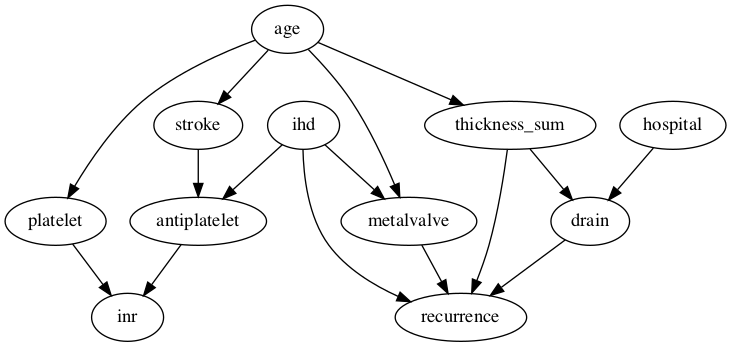

In [6]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

---
## Define set of classifiers to investigate

In [7]:
names = ['Dummy', 'LR', 'Linear SVM', 'RBF SVM', 'GB', 'RF', 'XGB']

In [8]:
# Naive Bayes exluded due to mixture of variable types
classifiers = [
    DummyClassifier(strategy='most_frequent'),
    LogisticRegression(max_iter=1000),
    SVC(kernel="linear", probability=True, random_state=random_state),
    SVC(kernel='rbf', probability=True, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state),
    XGBClassifier(random_state=random_state),
]

In [9]:
# define cross-validation structure
cv_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
cv_10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [10]:
# define classifiers and hyperparameters to search over
rf = RandomForestClassifier()
params_rf = {
    # randomly sample numbers from 10 to 200 estimators
    'rf__n_estimators':randint(10, 200),
    
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'rf__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'rf__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators.
    
    'rf__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'rf__max_features':['sqrt', 'log2', None],
    # random seed
    'rf__random_state':[random_state],
    # Whether bootstrap samples are used when building trees
    'rf__bootstrap':[True, False]
}

gb = GradientBoostingClassifier()
params_gb = {
    # randomly sample numbers from 10 to 200 estimators
    'gb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'gb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'gb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1.0],
        
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'gb__max_depth':randint(2, 15),
    # The number of features to consider when looking for the best split
    'gb__max_features':['sqrt', 'log2', None],
    # random seed
    'gb__random_state':[random_state]
}

xgb = XGBClassifier()
params_xgb = {
    # randomly sample numbers from 10 to 200 estimators
    'xgb__n_estimators':randint(10, 200),
    # fraction of samples to be used for fitting individual base learners
    'xgb__subsample':[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1],
    # learning rate
    'xgb__learning_rate':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1],
    # min_split_loss
    'xgb__gamma':[0.001, 0.003, 0.01, 0.03, 0.07, 0.1, 0.3],
 
    ### DONT TUNE THESE DUE TO DATASET SIZE ###
    # minimum number of samples required to split an internal node
    #'gb__min_samples_split':randint(1, 12),
    # minimum number of samples required to split a leaf
    #'gb__min_samples_leaf':randint(1, 50),
    # The maximum depth of the individual regression estimators
    
    'xgb__max_depth':randint(2, 15),
    # analagous to max_features in rf and gb
    'xgb__colsample_bytree':[0.6, 0.7, 0.8, 0.9, 1],
    # random seed
    'xgb__random_state':[random_state],
}


In [11]:
# define search spaces for random search tuning
search_space = [('rf', rf, params_rf), ('gb', gb, params_gb), ('xgb', xgb, params_xgb)]

---
## Predicting $T$ (drain) from controls $X, W$

In [12]:
y_drain_full = csdh_data['drain']
X_drain_full = csdh_data.drop(['drain', 'recurrence'], axis=1)

In [13]:
# Split into validation set and rest
X_drain_rest, X_drain_test, y_drain_rest, y_drain_test = train_test_split(X_drain_full, y_drain_full, 
                                                                        test_size=0.20,
                                                                        random_state=random_state,
                                                                        stratify=y_drain_full)

# Split rest into train and test set
X_drain_train, X_drain_val, y_drain_train, y_drain_val = train_test_split(X_drain_rest, y_drain_rest, 
                                                                            test_size=0.20,
                                                                            random_state=random_state,
                                                                            stratify=y_drain_rest)

In [14]:
drain_training_scores, drain_val_scores = mmh.train_and_validate_classifiers(X_drain_train, 
                                                                             y_drain_train,
                                                                             X_drain_val,
                                                                             y_drain_val,
                                                                             names,
                                                                             classifiers)

[13:47:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [15]:
mmh.print_metrics_table(drain_training_scores, drain_val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
LR            0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
Linear SVM    0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
RBF SVM       0.833    0.500    1.000    0.909   5.757    0.836    0.500    1.000    0.911    5.660
GB            0.817    0.550    0.950    0.896   6.332    0.943    0.827    1.000    0.967    1.959
RF            0.825    0.555    0.960    0.901   6.044    1.000    1.000    1.000    1.000    0.000
XGB           0.817    0.610    0.920    0.893 

## `model_t` K-Fold cross validation for hyperparameter tuning and model selection

In [16]:
# do the search
_,_, best_estimator_drain = mmh.randomized_search_cv(X_drain_rest, y_drain_rest, 
                                                     search_space, 
                                                     cv=cv_5,
                                                     refit=True,
                                                     score='roc_auc',
                                                     n_iter=5000, 
                                                     verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=136, random_state=100,
                                            subsample=0.6))])
cv score: [0.7775     0.77210526 0.69263158 0.71919192 0.86161616]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.8145     0.71526316 0.75578947 0.71515152 0.82929293]
----------------------------------------
Trial 12
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=94, random_state=100,
                                            subsample=0.9))])
cv score: [0.8175     0.76947368 0.71684211 0.72070707 0.85959596]
----------------------------------------
Trial 13
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.8305     0.76157895 0.78368421 0.75505051 0.86767677]
----------------------------------------
Trial 23
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=195,
                                        random_state=100))])
cv score: [0.644      0.74       0.69710526 0.68181818 0.82828283]
----------------------------------------
Trial 24
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, n_estimators=140,
                                      

cv score: [0.78725    0.75815789 0.75815789 0.76439394 0.81060606]
----------------------------------------
Trial 32
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.95))])
cv score: [0.79425    0.715      0.78947368 0.72550505 0.78560606]
----------------------------------------
Trial 33
----------------------------------------
Parameters {'xgb__n_estimators': 46, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.839      0.78052632 0.77473684 0.73080808 0.86767677]
----------------------------------------
Trial 43
----------------------------------------
Parameters {'xgb__n_estimators': 135, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=135,
                               n_jobs=None, num_parallel_tre

cv score: [0.81775    0.72789474 0.77578947 0.73636364 0.85555556]
----------------------------------------
Trial 55
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='sqrt',
                                            n_estimators=142, random_state=100,
                                            subsample=0.6))])
cv score: [0.749      0.75421053 0.74315789 0.70606061 0.82373737]
----------------------------------------
Trial 56
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
      

                               validate_parameters=None, verbosity=None))])
cv score: [0.7075     0.72894737 0.68631579 0.66313131 0.77828283]
----------------------------------------
Trial 67
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=61, random_state=100))])
cv score: [0.74275    0.72184211 0.68078947 0.72575758 0.83409091]
----------------------------------------
Trial 68
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
       

cv score: [0.7495     0.74842105 0.70421053 0.69494949 0.84343434]
----------------------------------------
Trial 78
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            n_estimators=146, random_state=100,
                                            subsample=0.75))])
cv score: [0.656      0.68315789 0.62263158 0.59393939 0.65      ]
----------------------------------------
Trial 79
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boost

cv score: [0.746      0.75157895 0.75736842 0.7040404  0.8459596 ]
----------------------------------------
Trial 89
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='log2',
                                            n_estimators=43, random_state=100,
                                            subsample=0.7))])
cv score: [0.708      0.65631579 0.65052632 0.62171717 0.75858586]
----------------------------------------
Trial 90
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootst

cv score: [0.774      0.77473684 0.70631579 0.70252525 0.82171717]
----------------------------------------
Trial 102
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            max_features='log2',
                                            n_estimators=102, random_state=100,
                                            subsample=0.75))])
cv score: [0.7865     0.78       0.72210526 0.73888889 0.87373737]
----------------------------------------
Trial 103
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.86325    0.76578947 0.80736842 0.7760101  0.84646465]
----------------------------------------
Trial 112
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='sqrt', n_estimators=185,
                                        random_state=100))])
cv score: [0.8145     0.77631579 0.73157895 0.75707071 0.86666667]
----------------------------------------
Trial 113
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                    

cv score: [0.6755     0.66947368 0.44894737 0.66868687 0.63181818]
----------------------------------------
Trial 126
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=105,
                               n_jobs=None, num_parallel_tre

cv score: [0.73725    0.73210526 0.71552632 0.62676768 0.75454545]
----------------------------------------
Trial 136
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=23,
                               n_jobs=None, num_parallel_

cv score: [0.7975     0.77473684 0.76684211 0.73838384 0.86969697]
----------------------------------------
Trial 150
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            n_estimators=24, random_state=100,
                                            subsample=0.95))])
cv score: [0.8245     0.77421053 0.78447368 0.75       0.8489899 ]
----------------------------------------
Trial 151
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,


cv score: [0.80825    0.73210526 0.73526316 0.70252525 0.84949495]
----------------------------------------
Trial 161
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
                                            n_estimators=176, random_state=100,
                                            subsample=0.95))])
cv score: [0.791      0.73473684 0.69842105 0.73636364 0.84191919]
----------------------------------------
Trial 162
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.7665     0.75684211 0.73736842 0.7030303  0.87474747]
----------------------------------------
Trial 171
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_t

cv score: [0.792      0.77421053 0.74263158 0.75757576 0.88181818]
----------------------------------------
Trial 180
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=96,
                                        random_state=100))])
cv score: [0.66125    0.59842105 0.56052632 0.63282828 0.66388889]
----------------------------------------
Trial 181
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                           

cv score: [0.807      0.75473684 0.76842105 0.73787879 0.84949495]
----------------------------------------
Trial 191
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=181,
                               n_jobs=None, num_parallel_tr

cv score: [0.806      0.77578947 0.76473684 0.77979798 0.86464646]
----------------------------------------
Trial 201
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=147, random_state=100))])
cv score: [0.7965     0.76263158 0.74052632 0.75707071 0.88106061]
----------------------------------------
Trial 202
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=146, random_state=100))])
cv score: [0.7935     0.75868421 0.74157895 0.75

cv score: [0.7945     0.75       0.76157895 0.72474747 0.85858586]
----------------------------------------
Trial 214
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.668      0.75473684 0.67105263 0.67575758 0.81262626]
----------------------------------------
Trial 224
----------------------------------------
Parameters {'xgb__n_estimators': 90, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=90,
                               n_jobs=None, num_parallel_t

cv score: [0.822      0.77368421 0.76052632 0.75050505 0.85555556]
----------------------------------------
Trial 234
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel_tre

cv score: [0.795      0.73684211 0.74157895 0.73383838 0.87828283]
----------------------------------------
Trial 244
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=188,
                                        random_state=100))])
cv score: [0.585      0.74263158 0.68578947 0.68131313 0.78585859]
----------------------------------------
Trial 245
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.71225    0.70368421 0.71026316 0.65454545 0.78257576]
----------------------------------------
Trial 254
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=

cv score: [0.7445     0.67842105 0.61789474 0.70707071 0.79949495]
----------------------------------------
Trial 267
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.846      0.79105263 0.77789474 0.76868687 0.85555556]
----------------------------------------
Trial 279
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=155,
                                        random_state=100))])
cv score: [0.818      0.80605263 0.72052632 0.76111111 0.86868687]
----------------------------------------
Trial 280
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.8        0.77052632 0.77       0.73030303 0.83484848]
----------------------------------------
Trial 287
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=77, random_state=100))])
cv score: [0.768      0.74394737 0.69263158 0.73181818 0.81489899]
----------------------------------------
Trial 288
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=154, random_state=100))])
cv score: [0.816      0.75131579 0.74184211 0.74

cv score: [0.7565     0.76789474 0.75210526 0.74444444 0.82929293]
----------------------------------------
Trial 297
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=39,
                               n_jobs=None, num_parallel_tre

cv score: [0.751      0.76894737 0.7        0.7020202  0.83131313]
----------------------------------------
Trial 304
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=26,
                                            random_state=100))])
cv score: [0.7905     0.72894737 0.67473684 0.72929293 0.82222222]
----------------------------------------
Trial 305
----------------------------------------
Parameters {'gb__n_estimators': 50, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoosting

cv score: [0.823      0.76631579 0.77368421 0.75656566 0.88232323]
----------------------------------------
Trial 316
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=10, random_state=100))])
cv score: [0.75425    0.76684211 0.73052632 0.73939394 0.8739899 ]
----------------------------------------
Trial 317
----------------------------------------
Parameters {'rf__n_estimators': 32, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=32, random_state=100))])
cv score: [0.71875    0.76921053 0.70315789 0.646969

cv score: [0.762      0.75157895 0.70736842 0.71565657 0.82575758]
----------------------------------------
Trial 329
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='log2',
                                            n_estimators=182, random_state=100,
                                            subsample=0.65))])
cv score: [0.6695     0.69473684 0.63631579 0.72929293 0.82070707]
----------------------------------------
Trial 330
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(b

cv score: [0.831      0.76263158 0.68421053 0.72676768 0.9       ]
----------------------------------------
Trial 340
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel

cv score: [0.831      0.79052632 0.75631579 0.76111111 0.85252525]
----------------------------------------
Trial 350
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=18,
                               n_jobs=None, num_parallel_t

cv score: [0.7995     0.74289474 0.75894737 0.74419192 0.81313131]
----------------------------------------
Trial 360
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=184,
                               n_jobs=None, num_parallel_tr

cv score: [0.821      0.76526316 0.76578947 0.7469697  0.86313131]
----------------------------------------
Trial 368
----------------------------------------
Parameters {'gb__n_estimators': 21, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=21, random_state=100,
                                            subsample=0.85))])
cv score: [0.683      0.74       0.58210526 0.65505051 0.72575758]
----------------------------------------
Trial 369
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps

cv score: [0.758      0.74157895 0.73842105 0.71515152 0.84949495]
----------------------------------------
Trial 378
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='log2',
                                            n_estimators=113, random_state=100,
                                            subsample=0.7))])
cv score: [0.791      0.72736842 0.75421053 0.72272727 0.86161616]
----------------------------------------
Trial 379
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.66125    0.59842105 0.56052632 0.63282828 0.66388889]
----------------------------------------
Trial 391
----------------------------------------
Parameters {'gb__n_estimators': 175, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=175, random_state=100,
                                            subsample=0.95))])
cv score: [0.798      0.74789474 0.70684211 0.7469697  0.86919192]
----------------------------------------
Trial 392
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.7735     0.75473684 0.74631579 0.72121212 0.83383838]
----------------------------------------
Trial 403
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=88, random_state=100))])
cv score: [0.7985     0.70842105 0.72684211 0.70555556 0.8510101 ]
----------------------------------------
Trial 404
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=10,
                                            n_estimators=75, random_state=100,
                

cv score: [0.775      0.75473684 0.72157895 0.7489899  0.85151515]
----------------------------------------
Trial 417
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=83, random_state=100,
                                            subsample=0.7))])
cv score: [0.817      0.77789474 0.69       0.71262626 0.86262626]
----------------------------------------
Trial 418
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.7975     0.77105263 0.74578947 0.76919192 0.87727273]
----------------------------------------
Trial 428
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=57, random_state=100))])
cv score: [0.79725    0.76631579 0.70684211 0.73888889 0.87222222]
----------------------------------------
Trial 429
----------------------------------------
Parameters {'gb__n_estimators': 56, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                 

cv score: [0.8075     0.77631579 0.74473684 0.75757576 0.86060606]
----------------------------------------
Trial 439
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=20, random_state=100))])
cv score: [0.828      0.74078947 0.72       0.68661616 0.84419192]
----------------------------------------
Trial 440
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=144,
                                        rando

cv score: [0.68       0.68421053 0.54421053 0.64848485 0.70707071]
----------------------------------------
Trial 453
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            n_estimators=128, random_state=100,
                                            subsample=0.9))])
cv score: [0.788      0.77921053 0.75263158 0.76717172 0.87929293]
----------------------------------------
Trial 454
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, n_estimators=51,
        

cv score: [0.593      0.74263158 0.67868421 0.67878788 0.80631313]
----------------------------------------
Trial 464
----------------------------------------
Parameters {'gb__n_estimators': 165, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=165, random_state=100,
                                            subsample=0.6))])
cv score: [0.712      0.69105263 0.65052632 0.64444444 0.75252525]
----------------------------------------
Trial 465
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(step

cv score: [0.7885     0.73684211 0.74947368 0.73636364 0.80909091]
----------------------------------------
Trial 475
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=91,
                                        random_state=100))])
cv score: [0.833      0.75631579 0.79789474 0.72373737 0.86717172]
----------------------------------------
Trial 476
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            n_estimators=173,
                                            random_state=100))])
cv score: [0.72225    0.71710526 0.78394737 0.72752525 0.81414141]
----------------------------------------
Trial 489
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=25, random_state=100,
                                            subsample=0.75))])
cv score: [0.78425    0.76842105 0.73868421 0.68282828 0.74747475]
----------------------------------------
Trial 490
-------

cv score: [0.7815     0.73894737 0.69157895 0.7010101  0.84040404]
----------------------------------------
Trial 499
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=172, random_state=100))])
cv score: [0.803      0.75657895 0.75052632 0.75126263 0.87626263]
----------------------------------------
Trial 500
----------------------------------------
Parameters {'rf__n_estimators': 121, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=121,
                                        random_stat

cv score: [0.76125    0.73026316 0.73105263 0.6989899  0.77979798]
----------------------------------------
Trial 512
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_para

cv score: [0.75       0.71736842 0.64421053 0.70959596 0.83686869]
----------------------------------------
Trial 522
----------------------------------------
Parameters {'gb__n_estimators': 112, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            max_features='log2',
                                            n_estimators=112, random_state=100,
                                            subsample=0.9))])
cv score: [0.735      0.67210526 0.63526316 0.69848485 0.7489899 ]
----------------------------------------
Trial 523
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.746      0.75789474 0.76842105 0.67070707 0.82424242]
----------------------------------------
Trial 531
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
                               n_jobs=None, num_parallel_tree

cv score: [0.819      0.78421053 0.74263158 0.78131313 0.87171717]
----------------------------------------
Trial 540
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=44, random_state=100))])
cv score: [0.7635     0.71105263 0.72210526 0.74242424 0.85707071]
----------------------------------------
Trial 541
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='log2',
                                            n_estimators=70, random_state=100,
                 

cv score: [0.7825     0.75815789 0.74736842 0.75707071 0.87676768]
----------------------------------------
Trial 553
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=188,
                               n_jobs=None, num_parallel_

cv score: [0.815      0.76789474 0.71947368 0.7510101  0.87070707]
----------------------------------------
Trial 564
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=13, random_state=100,
                                            subsample=0.75))])
cv score: [0.699      0.67684211 0.68105263 0.68282828 0.82626263]
----------------------------------------
Trial 565
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(step

cv score: [0.76925    0.77184211 0.73210526 0.70025253 0.81464646]
----------------------------------------
Trial 573
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=79, random_state=100))])
cv score: [0.7945     0.73631579 0.71947368 0.72171717 0.83484848]
----------------------------------------
Trial 574
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.6665     0.69684211 0.60052632 0.71212121 0.69343434]
----------------------------------------
Trial 582
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=31,
                               n_jobs=None, num_parallel_tre

cv score: [0.7155     0.68315789 0.63526316 0.72474747 0.82828283]
----------------------------------------
Trial 592
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=185,
                                        random_state=100))])
cv score: [0.86625    0.76       0.76605263 0.77045455 0.85934343]
----------------------------------------
Trial 593
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=34, random_state=10

cv score: [0.8275     0.76473684 0.76578947 0.75353535 0.88030303]
----------------------------------------
Trial 602
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=31,
                                        random_state=100))])
cv score: [0.78275    0.79421053 0.70473684 0.76212121 0.8739899 ]
----------------------------------------
Trial 603
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estima

cv score: [0.8225     0.73473684 0.74947368 0.75       0.89545455]
----------------------------------------
Trial 613
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='log2',
                                            n_estimators=197, random_state=100,
                                            subsample=0.8))])
cv score: [0.807      0.77157895 0.71947368 0.7459596  0.87525253]
----------------------------------------
Trial 614
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.761      0.76       0.7        0.70454545 0.77828283]
----------------------------------------
Trial 627
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=16,
                                        random_state=100))])
cv score: [0.7945     0.73684211 0.69605263 0.73939394 0.8510101 ]
----------------------------------------
Trial 628
----------------------------------------
Parameters {'xgb__n_estimators': 119, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.671      0.69526316 0.64526316 0.68737374 0.70151515]
----------------------------------------
Trial 637
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=56,
                                        random_state=100))])
cv score: [0.83625    0.77210526 0.74973684 0.77348485 0.8280303 ]
----------------------------------------
Trial 638
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                            

cv score: [0.79875    0.76526316 0.76526316 0.69722222 0.84141414]
----------------------------------------
Trial 646
----------------------------------------
Parameters {'xgb__n_estimators': 63, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=63,
                               n_jobs=None, num_parallel_tree

cv score: [0.7915     0.75421053 0.69631579 0.73080808 0.84292929]
----------------------------------------
Trial 656
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree

cv score: [0.744      0.75526316 0.70894737 0.72929293 0.86414141]
----------------------------------------
Trial 665
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=186, random_state=100,
                                            subsample=0.85))])
cv score: [0.79025    0.73394737 0.75394737 0.71363636 0.83030303]
----------------------------------------
Trial 666
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.8405     0.76631579 0.80263158 0.76994949 0.87525253]
----------------------------------------
Trial 674
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=73,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.77525    0.74       0.71947368 0.73838384 0.82121212]
----------------------------------------
Trial 685
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            max_features='log2',
                                            n_estimators=166, random_state=100,
                                            subsample=0.75))])
cv score: [0.7655     0.73421053 0.70368421 0.72020202 0.86060606]
----------------------------------------
Trial 686
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.8215     0.76736842 0.74578947 0.75353535 0.84242424]
----------------------------------------
Trial 699
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel_

cv score: [0.82675    0.75657895 0.70263158 0.74318182 0.82752525]
----------------------------------------
Trial 706
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
                               n_jobs=None, num_paralle

cv score: [0.78       0.77052632 0.75157895 0.72878788 0.87979798]
----------------------------------------
Trial 715
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='log2',
                                            n_estimators=130, random_state=100,
                                            subsample=0.8))])
cv score: [0.787      0.75263158 0.69631579 0.72979798 0.82777778]
----------------------------------------
Trial 716
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.833      0.75473684 0.79684211 0.72373737 0.86666667]
----------------------------------------
Trial 725
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=192, random_state=100,
                                            subsample=0.85))])
cv score: [0.8205     0.76263158 0.72210526 0.74545455 0.87424242]
----------------------------------------
Trial 726
----------------------------------------
Parameters {'xgb__n_estimators': 58, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.703      0.7        0.67842105 0.72929293 0.81010101]
----------------------------------------
Trial 737
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=52,
                                        random_state=100))])
cv score: [0.7915     0.67763158 0.67973684 0.69292929 0.75530303]
----------------------------------------
Trial 738
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=19

cv score: [0.8435     0.75631579 0.75842105 0.76338384 0.83787879]
----------------------------------------
Trial 747
----------------------------------------
Parameters {'xgb__n_estimators': 83, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=83,
                               n_jobs=None, num_parallel_tree=

cv score: [0.727      0.77157895 0.66210526 0.71212121 0.82575758]
----------------------------------------
Trial 758
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=151, random_state=100))])
cv score: [0.78075    0.75605263 0.70684211 0.72323232 0.84747475]
----------------------------------------
Trial 759
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=56,
                                        rando

cv score: [0.8115     0.76947368 0.73684211 0.75757576 0.86161616]
----------------------------------------
Trial 769
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=20,
                                        random_state=100))])
cv score: [0.763      0.73578947 0.72710526 0.74747475 0.78459596]
----------------------------------------
Trial 770
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.74375    0.72026316 0.68868421 0.72878788 0.83232323]
----------------------------------------
Trial 778
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, n_estimators=188,
                                            random_state=100, subsample=0.6))])
cv score: [0.7175     0.75105263 0.76157895 0.69343434 0.83686869]
----------------------------------------
Trial 779
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                            max_features='sqrt',
  

cv score: [0.59325    0.74157895 0.67868421 0.68181818 0.80631313]
----------------------------------------
Trial 790
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=149, random_state=100,
                                            subsample=0.65))])
cv score: [0.8085     0.75789474 0.73052632 0.72070707 0.88080808]
----------------------------------------
Trial 791
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.727      0.70894737 0.73       0.66010101 0.70505051]
----------------------------------------
Trial 801
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='log2',
                                            n_estimators=22, random_state=100,
                                            subsample=0.7))])
cv score: [0.75675    0.70815789 0.65789474 0.73358586 0.79343434]
----------------------------------------
Trial 802
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(boot

cv score: [0.819      0.77868421 0.76394737 0.78207071 0.8479798 ]
----------------------------------------
Trial 811
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=88, random_state=100))])
cv score: [0.836      0.75631579 0.78421053 0.74722222 0.8459596 ]
----------------------------------------
Trial 812
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            n_estimators=105,
                                        

cv score: [0.7925     0.73842105 0.74368421 0.73484848 0.87979798]
----------------------------------------
Trial 823
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=101, random_state=100))])
cv score: [0.79575    0.74315789 0.72157895 0.70555556 0.83333333]
----------------------------------------
Trial 824
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.8175     0.78       0.75894737 0.78030303 0.86767677]
----------------------------------------
Trial 833
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=126,
                                            random_state=100))])
cv score: [0.81175    0.74315789 0.78315789 0.73686869 0.86767677]
----------------------------------------
Trial 834
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoost

cv score: [0.7875     0.76631579 0.71473684 0.75606061 0.87727273]
----------------------------------------
Trial 845
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=77,
                               n_jobs=None, num_parallel_tr

cv score: [0.8385     0.78105263 0.75368421 0.77323232 0.85757576]
----------------------------------------
Trial 854
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=108,
                               n_jobs=None, num_parallel_tre

cv score: [0.8145     0.73736842 0.75105263 0.75707071 0.87777778]
----------------------------------------
Trial 866
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=74,
                                        random_state=100))])
cv score: [0.828      0.75578947 0.76105263 0.76212121 0.87373737]
----------------------------------------
Trial 867
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                      

cv score: [0.75       0.73236842 0.77842105 0.6530303  0.71868687]
----------------------------------------
Trial 879
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=130, random_state=100))])
cv score: [0.79825    0.77131579 0.74078947 0.74646465 0.87979798]
----------------------------------------
Trial 880
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                 

cv score: [0.6865     0.75157895 0.68631579 0.66363636 0.76161616]
----------------------------------------
Trial 890
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            n_estimators=136, random_state=100,
                                            subsample=0.9))])
cv score: [0.6895     0.68894737 0.66684211 0.69040404 0.82222222]
----------------------------------------
Trial 891
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
    

cv score: [0.7935     0.73421053 0.72631579 0.71464646 0.87070707]
----------------------------------------
Trial 901
----------------------------------------
Parameters {'gb__n_estimators': 19, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            n_estimators=19, random_state=100,
                                            subsample=0.95))])
cv score: [0.7665     0.72789474 0.76789474 0.74444444 0.87878788]
----------------------------------------
Trial 902
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
             

cv score: [0.7775     0.76526316 0.75052632 0.76893939 0.86616162]
----------------------------------------
Trial 910
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=117,
                                        random_state=100))])
cv score: [0.8225     0.74789474 0.77631579 0.7530303  0.87373737]
----------------------------------------
Trial 911
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=120, random_

cv score: [0.787      0.71       0.69736842 0.71515152 0.8510101 ]
----------------------------------------
Trial 921
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            n_estimators=177, random_state=100,
                                            subsample=0.65))])
cv score: [0.828      0.76578947 0.77105263 0.73888889 0.87626263]
----------------------------------------
Trial 922
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
  

cv score: [0.808      0.72368421 0.74315789 0.74646465 0.84646465]
----------------------------------------
Trial 933
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=192,
                                        random_state=100))])
cv score: [0.8185     0.79052632 0.71210526 0.75858586 0.88131313]
----------------------------------------
Trial 934
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimato

cv score: [0.8485     0.76763158 0.80763158 0.76666667 0.85656566]
----------------------------------------
Trial 944
----------------------------------------
Parameters {'gb__n_estimators': 153, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            max_features='log2',
                                            n_estimators=153, random_state=100,
                                            subsample=0.9))])
cv score: [0.7465     0.68894737 0.68368421 0.72171717 0.83030303]
----------------------------------------
Trial 945
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.5605     0.64368421 0.515      0.71313131 0.61313131]
----------------------------------------
Trial 954
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=182,
                                        random_state=100))])
cv score: [0.8285     0.76473684 0.76578947 0.7540404  0.87929293]
----------------------------------------
Trial 955
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.778      0.76947368 0.72789474 0.75656566 0.88939394]
----------------------------------------
Trial 965
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.807      0.76315789 0.77894737 0.73535354 0.81969697]
----------------------------------------
Trial 977
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
                               n_jobs=None, num_parallel_tr

cv score: [0.711      0.69052632 0.68473684 0.70555556 0.75909091]
----------------------------------------
Trial 987
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='log2',
                                            n_estimators=94, random_state=100,
                                            subsample=0.85))])
cv score: [0.741      0.74263158 0.74631579 0.71818182 0.81414141]
----------------------------------------
Trial 988
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,

cv score: [0.7235     0.73       0.69578947 0.73434343 0.83131313]
----------------------------------------
Trial 998
----------------------------------------
Parameters {'xgb__n_estimators': 149, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=149,
                               n_jobs=None, num_parallel_tr

cv score: [0.812      0.74052632 0.74368421 0.76010101 0.87323232]
----------------------------------------
Trial 1006
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=178, random_state=100))])
cv score: [0.844      0.74421053 0.77578947 0.75353535 0.87272727]
----------------------------------------
Trial 1007
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.7025     0.76210526 0.71157895 0.72929293 0.8540404 ]
----------------------------------------
Trial 1015
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=135,
                                        random_state=100))])
cv score: [0.8235     0.78684211 0.70631579 0.76515152 0.87626263]
----------------------------------------
Trial 1016
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.82       0.72315789 0.77157895 0.74141414 0.87878788]
----------------------------------------
Trial 1026
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=116,
                               n_jobs=None, num_paral

cv score: [0.7385     0.70526316 0.65789474 0.7030303  0.82474747]
----------------------------------------
Trial 1036
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=106,
                                        random_state=100))])
cv score: [0.59275    0.74263158 0.67868421 0.67979798 0.80631313]
----------------------------------------
Trial 1037
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=194, rando

cv score: [0.824      0.77421053 0.73526316 0.72020202 0.85353535]
----------------------------------------
Trial 1052
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=16,
                                            random_state=100,
                                            subsample=0.65))])
cv score: [0.7475     0.73789474 0.71       0.70454545 0.82777778]
----------------------------------------
Trial 1053
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                   

cv score: [0.814      0.76684211 0.78263158 0.73737374 0.87424242]
----------------------------------------
Trial 1064
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=18,
                                        random_state=100))])
cv score: [0.66125    0.59842105 0.56052632 0.63282828 0.66388889]
----------------------------------------
Trial 1065
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.675      0.64210526 0.66210526 0.66010101 0.72020202]
----------------------------------------
Trial 1076
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                                            n_estimators=96, random_state=100,
                                            subsample=0.95))])
cv score: [0.7345     0.73263158 0.66631579 0.72070707 0.8530303 ]
----------------------------------------
Trial 1077
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.828      0.76631579 0.80552632 0.7719697  0.85530303]
----------------------------------------
Trial 1086
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=14, random_state=100))])
cv score: [0.80875    0.73315789 0.65526316 0.69242424 0.79873737]
----------------------------------------
Trial 1087
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=93, random_state=100,
             

cv score: [0.821      0.75473684 0.78842105 0.74393939 0.85707071]
----------------------------------------
Trial 1096
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            n_estimators=70, random_state=100,
                                            subsample=0.8))])
cv score: [0.763      0.76157895 0.67157895 0.73888889 0.87777778]
----------------------------------------
Trial 1097
----------------------------------------
Parameters {'xgb__n_estimators': 59, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booste

cv score: [0.71       0.73631579 0.67368421 0.65909091 0.77878788]
----------------------------------------
Trial 1106
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            n_estimators=39, random_state=100,
                                            subsample=0.7))])
cv score: [0.632      0.63       0.49684211 0.72828283 0.79494949]
----------------------------------------
Trial 1107
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                   

cv score: [0.7745     0.73684211 0.78105263 0.67323232 0.83585859]
----------------------------------------
Trial 1119
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=188,
                               n_jobs=None, num_parallel_t

cv score: [0.748      0.74842105 0.73736842 0.67171717 0.77525253]
----------------------------------------
Trial 1128
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=103,
                               n_jobs=None, num_parallel

cv score: [0.6515     0.775      0.79052632 0.71439394 0.78611111]
----------------------------------------
Trial 1138
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, n_estimators=47,
                                            random_state=100, subsample=0.6))])
cv score: [0.777      0.76315789 0.72       0.71111111 0.86565657]
----------------------------------------
Trial 1139
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
     

cv score: [0.7855     0.73631579 0.73105263 0.69494949 0.84040404]
----------------------------------------
Trial 1148
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=181,
                                        random_state=100))])
cv score: [0.76125    0.73026316 0.73105263 0.6989899  0.77979798]
----------------------------------------
Trial 1149
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                 

cv score: [0.8025     0.77105263 0.73578947 0.7510101  0.86868687]
----------------------------------------
Trial 1160
----------------------------------------
Parameters {'gb__n_estimators': 187, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=187, random_state=100,
                                            subsample=0.65))])
cv score: [0.8115     0.76052632 0.75105263 0.72777778 0.89494949]
----------------------------------------
Trial 1161
----------------------------------------
Parameters {'xgb__n_estimators': 149, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.7335     0.74157895 0.68736842 0.73737374 0.81161616]
----------------------------------------
Trial 1172
----------------------------------------
Parameters {'gb__n_estimators': 121, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            n_estimators=121, random_state=100,
                                            subsample=0.85))])
cv score: [0.839      0.77684211 0.76526316 0.73636364 0.88030303]
----------------------------------------
Trial 1173
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
   

cv score: [0.8025     0.77526316 0.74263158 0.76616162 0.87323232]
----------------------------------------
Trial 1184
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                                            n_estimators=59, random_state=100,
                                            subsample=0.8))])
cv score: [0.793      0.73526316 0.70684211 0.68257576 0.7760101 ]
----------------------------------------
Trial 1185
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.7335     0.77421053 0.73315789 0.69444444 0.80555556]
----------------------------------------
Trial 1195
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=97, random_state=100))])
cv score: [0.8385     0.75921053 0.77789474 0.7530303  0.87676768]
----------------------------------------
Trial 1196
----------------------------------------
Parameters {'rf__n_estimators': 39, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=39,
                                        random_state=100)

cv score: [0.7215     0.71       0.67947368 0.73030303 0.77929293]
----------------------------------------
Trial 1208
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.757      0.72421053 0.72368421 0.71464646 0.83838384]
----------------------------------------
Trial 1217
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            n_estimators=65, random_state=100,
                                            subsample=0.65))])
cv score: [0.8055     0.75105263 0.72210526 0.74292929 0.78358586]
----------------------------------------
Trial 1218
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
               

cv score: [0.77925    0.76578947 0.76526316 0.70606061 0.83686869]
----------------------------------------
Trial 1229
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                            n_estimators=180, random_state=100,
                                            subsample=0.6))])
cv score: [0.5625     0.72578947 0.39394737 0.69444444 0.53636364]
----------------------------------------
Trial 1230
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.82275    0.755      0.79263158 0.76540404 0.83257576]
----------------------------------------
Trial 1241
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='log2',
                                            n_estimators=49, random_state=100,
                                            subsample=0.65))])
cv score: [0.687      0.70473684 0.68736842 0.67070707 0.85252525]
----------------------------------------
Trial 1242
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.719      0.74789474 0.63315789 0.66262626 0.75606061]
----------------------------------------
Trial 1251
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=162,
                                        random_state=100))])
cv score: [0.8195     0.80394737 0.72210526 0.75909091 0.87020202]
----------------------------------------
Trial 1252
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=88, rando

cv score: [0.816      0.775      0.71       0.78989899 0.87525253]
----------------------------------------
Trial 1260
----------------------------------------
Parameters {'xgb__n_estimators': 11, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=11,
                               n_jobs=None, num_parallel_tr

cv score: [0.814      0.75526316 0.76368421 0.72979798 0.85858586]
----------------------------------------
Trial 1271
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=124,
                               n_jobs=None, num_parall

cv score: [0.815      0.80605263 0.72157895 0.76161616 0.86969697]
----------------------------------------
Trial 1281
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=92,
                               n_jobs=None, num_parallel

cv score: [0.7945     0.78894737 0.72       0.74393939 0.88181818]
----------------------------------------
Trial 1294
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=63,
                                        random_state=100))])
cv score: [0.66125    0.59842105 0.56052632 0.63282828 0.66388889]
----------------------------------------
Trial 1295
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                           

cv score: [0.773      0.75105263 0.71052632 0.73787879 0.82878788]
----------------------------------------
Trial 1305
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=98,
                                        random_state=100))])
cv score: [0.8245     0.78842105 0.71605263 0.75631313 0.88207071]
----------------------------------------
Trial 1306
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimato

cv score: [0.691      0.72842105 0.65       0.63282828 0.76313131]
----------------------------------------
Trial 1318
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_t

cv score: [0.734      0.74421053 0.71473684 0.71515152 0.80151515]
----------------------------------------
Trial 1328
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=28,
                               n_jobs=None, num_parallel_tre

Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            n_estimators=136, random_state=100,
                                            subsample=0.95))])
cv score: [0.802      0.75684211 0.76631579 0.73661616 0.82348485]
----------------------------------------
Trial 1340
----------------------------------------
Parameters {'xgb__n_estimators': 127, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
  

cv score: [0.795      0.78684211 0.72947368 0.7459596  0.85757576]
----------------------------------------
Trial 1350
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=161,
                               n_jobs=None, num_parallel_t

cv score: [0.8235     0.77394737 0.78131579 0.76464646 0.82449495]
----------------------------------------
Trial 1359
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=136,
                               n_jobs=None, num_parallel_t

cv score: [0.76225    0.73026316 0.74736842 0.69393939 0.77727273]
----------------------------------------
Trial 1368
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=52,
                                        random_state=100))])
cv score: [0.8115     0.76421053 0.71763158 0.73535354 0.87777778]
----------------------------------------
Trial 1369
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_f

cv score: [0.6365     0.64052632 0.64052632 0.56515152 0.64141414]
----------------------------------------
Trial 1379
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, n_estimators=62,
                                            random_state=100, subsample=0.6))])
cv score: [0.787      0.72947368 0.78947368 0.72979798 0.83333333]
----------------------------------------
Trial 1380
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel

cv score: [0.8165     0.78921053 0.70842105 0.76035354 0.88232323]
----------------------------------------
Trial 1391
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=74, random_state=100))])
cv score: [0.7885     0.73684211 0.69368421 0.73106061 0.84469697]
----------------------------------------
Trial 1392
----------------------------------------
Parameters {'rf__n_estimators': 29, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=29,
                                        random_st

cv score: [0.7655     0.76473684 0.69421053 0.67373737 0.81111111]
----------------------------------------
Trial 1401
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.6))])
cv score: [0.719      0.79105263 0.61578947 0.68383838 0.83737374]
----------------------------------------
Trial 1402
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.8425     0.78473684 0.79026316 0.77752525 0.83030303]
----------------------------------------
Trial 1409
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_paralle

cv score: [0.8035     0.76842105 0.73578947 0.72929293 0.88282828]
----------------------------------------
Trial 1419
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=88,
                                        random_state=100))])
cv score: [0.818      0.80947368 0.72078947 0.74393939 0.86616162]
----------------------------------------
Trial 1420
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estima

cv score: [0.8255     0.75578947 0.75578947 0.74873737 0.88838384]
----------------------------------------
Trial 1430
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=101, random_state=100,
                                            subsample=0.75))])
cv score: [0.784      0.72736842 0.68736842 0.70454545 0.83030303]
----------------------------------------
Trial 1431
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.7645     0.76947368 0.73421053 0.73838384 0.85858586]
----------------------------------------
Trial 1441
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=50,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.6575     0.74578947 0.64736842 0.68585859 0.79747475]
----------------------------------------
Trial 1452
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=134,
                                        random_state=100))])
cv score: [0.8185     0.77736842 0.74210526 0.7479798  0.86414141]
----------------------------------------
Trial 1453
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
                              

cv score: [0.792      0.77473684 0.71526316 0.7459596  0.8530303 ]
----------------------------------------
Trial 1465
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel_

cv score: [0.763      0.76368421 0.71631579 0.69545455 0.82979798]
----------------------------------------
Trial 1475
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=56,
                                        random_state=100))])
cv score: [0.8395     0.75684211 0.77973684 0.72424242 0.86161616]
----------------------------------------
Trial 1476
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                   

cv score: [0.8175     0.74421053 0.70578947 0.73585859 0.84949495]
----------------------------------------
Trial 1486
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=44,
                               n_jobs=None, num_parallel_tre

cv score: [0.753      0.73842105 0.73315789 0.76414141 0.86919192]
----------------------------------------
Trial 1498
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            n_estimators=192, random_state=100,
                                            subsample=0.9))])
cv score: [0.744      0.72       0.60789474 0.71111111 0.83181818]
----------------------------------------
Trial 1499
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
 

cv score: [0.8355     0.78763158 0.76447368 0.78737374 0.8479798 ]
----------------------------------------
Trial 1509
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='log2',
                                            n_estimators=188, random_state=100,
                                            subsample=0.6))])
cv score: [0.802      0.75631579 0.76210526 0.73131313 0.89494949]
----------------------------------------
Trial 1510
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.8075     0.76894737 0.73736842 0.7459596  0.86767677]
----------------------------------------
Trial 1520
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='log2',
                                            n_estimators=186, random_state=100,
                                            subsample=0.65))])
cv score: [0.737      0.72210526 0.66315789 0.75353535 0.78838384]
----------------------------------------
Trial 1521
----------------------------------------
Parameters {'rf__n_estimators': 139, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.808      0.71947368 0.73842105 0.71363636 0.89090909]
----------------------------------------
Trial 1532
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tree=

cv score: [0.8255     0.73368421 0.77315789 0.75984848 0.87676768]
----------------------------------------
Trial 1543
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=162,
                               n_jobs=None, num_parallel_t

cv score: [0.847      0.76763158 0.79       0.74848485 0.88636364]
----------------------------------------
Trial 1554
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=78, random_state=100,
                                            subsample=0.6))])
cv score: [0.4905     0.60789474 0.61473684 0.69747475 0.76262626]
----------------------------------------
Trial 1555
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                               

cv score: [0.8        0.76078947 0.75473684 0.74823232 0.84393939]
----------------------------------------
Trial 1566
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_

cv score: [0.775      0.74105263 0.70157895 0.69444444 0.83484848]
----------------------------------------
Trial 1575
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=132,
                               n_jobs=None, num_parallel_

cv score: [0.821      0.77342105 0.79026316 0.78257576 0.84722222]
----------------------------------------
Trial 1587
----------------------------------------
Parameters {'xgb__n_estimators': 158, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=158,
                               n_jobs=None, num_parallel

cv score: [0.8145     0.77578947 0.78052632 0.71313131 0.86515152]
----------------------------------------
Trial 1599
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=93, random_state=100))])
cv score: [0.8165     0.76157895 0.71263158 0.72020202 0.86666667]
----------------------------------------
Trial 1600
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='log2',
                                            n_estimators=98, random_state=100,
             

cv score: [0.845      0.77210526 0.77842105 0.73787879 0.88434343]
----------------------------------------
Trial 1611
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=40, random_state=100,
                                            subsample=0.6))])
cv score: [0.727      0.75315789 0.66105263 0.69545455 0.85606061]
----------------------------------------
Trial 1612
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.7505     0.74052632 0.66157895 0.7479798  0.8239899 ]
----------------------------------------
Trial 1623
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_t

cv score: [0.8435     0.78210526 0.77789474 0.77222222 0.8459596 ]
----------------------------------------
Trial 1631
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=189, random_state=100))])
cv score: [0.8045     0.76368421 0.73368421 0.73333333 0.88333333]
----------------------------------------
Trial 1632
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.7735     0.75842105 0.69578947 0.69191919 0.84646465]
----------------------------------------
Trial 1642
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=51,
                                        random_state=100))])
cv score: [0.82275    0.70631579 0.74315789 0.75151515 0.79520202]
----------------------------------------
Trial 1643
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                      

cv score: [0.857      0.78105263 0.77526316 0.76414141 0.85808081]
----------------------------------------
Trial 1653
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=198, random_state=100))])
cv score: [0.783      0.75526316 0.68894737 0.72727273 0.85555556]
----------------------------------------
Trial 1654
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=105, random_state=100))])
cv score: [0.807      0.76473684 0.722

cv score: [0.8185     0.78789474 0.74631579 0.77474747 0.85      ]
----------------------------------------
Trial 1664
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=118, random_state=100,
                                            subsample=0.8))])
cv score: [0.725      0.75421053 0.64526316 0.70858586 0.79141414]
----------------------------------------
Trial 1665
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                  

cv score: [0.7945     0.73157895 0.70368421 0.7489899  0.83484848]
----------------------------------------
Trial 1675
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=134, random_state=100,
                                            subsample=0.9))])
cv score: [0.799      0.75421053 0.74263158 0.74191919 0.87626263]
----------------------------------------
Trial 1676
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.8445     0.77210526 0.78421053 0.77550505 0.84949495]
----------------------------------------
Trial 1686
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=73,
                                        random_state=100))])
cv score: [0.6185     0.73921053 0.70315789 0.67449495 0.81060606]
----------------------------------------
Trial 1687
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.72075    0.71421053 0.71052632 0.61262626 0.75050505]
----------------------------------------
Trial 1697
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=189, random_state=100))])
cv score: [0.7955     0.73315789 0.74894737 0.68333333 0.81464646]
----------------------------------------
Trial 1698
----------------------------------------
Parameters {'rf__n_estimators': 82, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=82,
                                        random_st

cv score: [0.8175     0.72473684 0.77578947 0.7        0.84292929]
----------------------------------------
Trial 1709
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=102,
                               n_jobs=None, num_parallel

cv score: [0.8235     0.77421053 0.76421053 0.76363636 0.86111111]
----------------------------------------
Trial 1718
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.779      0.75473684 0.73526316 0.73737374 0.87222222]
----------------------------------------
Trial 1729
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=135, random_state=100))])
cv score: [0.828      0.75894737 0.78       0.7459596  0.85656566]
----------------------------------------
Trial 1730
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            n_estimators=75, random_state=100,
                

cv score: [0.81375    0.76078947 0.74894737 0.72651515 0.84444444]
----------------------------------------
Trial 1741
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_t

cv score: [0.838      0.75473684 0.75684211 0.75858586 0.87626263]
----------------------------------------
Trial 1752
----------------------------------------
Parameters {'rf__n_estimators': 17, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=17,
                                        random_state=100))])
cv score: [0.876      0.74736842 0.69921053 0.76338384 0.82575758]
----------------------------------------
Trial 1753
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                        

cv score: [0.8245     0.78631579 0.70789474 0.76515152 0.8739899 ]
----------------------------------------
Trial 1764
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=53,
                                        random_state=100))])
cv score: [0.808      0.75394737 0.69789474 0.76262626 0.875     ]
----------------------------------------
Trial 1765
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                      

cv score: [0.7975     0.76631579 0.72657895 0.73863636 0.87828283]
----------------------------------------
Trial 1777
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_t

cv score: [0.7805     0.77263158 0.69894737 0.7489899  0.87525253]
----------------------------------------
Trial 1786
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=68, random_state=100))])
cv score: [0.79225    0.755      0.755      0.75782828 0.8469697 ]
----------------------------------------
Trial 1787
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
       

cv score: [0.7645     0.74157895 0.70052632 0.6969697  0.85808081]
----------------------------------------
Trial 1797
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=69, random_state=100,
                                            subsample=0.85))])
cv score: [0.6715     0.65894737 0.71684211 0.66262626 0.80353535]
----------------------------------------
Trial 1798
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.7035     0.71210526 0.68894737 0.68030303 0.81363636]
----------------------------------------
Trial 1810
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=74, random_state=100))])
cv score: [0.78325    0.73315789 0.70947368 0.72323232 0.82525253]
----------------------------------------
Trial 1811
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.7015     0.72789474 0.70263158 0.65707071 0.80353535]
----------------------------------------
Trial 1820
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.65, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='log2',
                                            n_estimators=57, random_state=100,
                                            subsample=0.65))])
cv score: [0.6565     0.68473684 0.71263158 0.58737374 0.70505051]
----------------------------------------
Trial 1821
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.7275     0.78184211 0.74868421 0.71919192 0.84722222]
----------------------------------------
Trial 1835
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='log2',
                                            n_estimators=147, random_state=100,
                                            subsample=0.8))])
cv score: [0.7885     0.72894737 0.66       0.74494949 0.82929293]
----------------------------------------
Trial 1836
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                              

cv score: [0.758      0.75421053 0.70789474 0.69040404 0.75606061]
----------------------------------------
Trial 1846
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=87,
                                        random_state=100))])
cv score: [0.8355     0.75894737 0.79421053 0.72575758 0.87121212]
----------------------------------------
Trial 1847
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                   

cv score: [0.845      0.79105263 0.78263158 0.77424242 0.86414141]
----------------------------------------
Trial 1858
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
                               n_jobs=None, num_parall

cv score: [0.8295     0.74894737 0.77157895 0.75707071 0.88434343]
----------------------------------------
Trial 1868
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                            n_estimators=65, random_state=100,
                                            subsample=0.6))])
cv score: [0.827      0.75421053 0.74       0.73333333 0.86767677]
----------------------------------------
Trial 1869
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.8465     0.78578947 0.78315789 0.77323232 0.86414141]
----------------------------------------
Trial 1879
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=96,
                               n_jobs=None, num_parallel_tree=

cv score: [0.7475     0.71789474 0.69526316 0.66111111 0.80555556]
----------------------------------------
Trial 1892
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=151,
                               n_jobs=None, num_paralle

cv score: [0.6905     0.75368421 0.7        0.66111111 0.78989899]
----------------------------------------
Trial 1903
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel

cv score: [0.783      0.76894737 0.75105263 0.72676768 0.8489899 ]
----------------------------------------
Trial 1913
----------------------------------------
Parameters {'gb__n_estimators': 25, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=25,
                                            random_state=100, subsample=0.6))])
cv score: [0.7325     0.73894737 0.73315789 0.74141414 0.85707071]
----------------------------------------
Trial 1914
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=16, random_state=100))])
cv score: [0.8405     0.7

cv score: [0.727      0.73526316 0.75157895 0.70454545 0.85883838]
----------------------------------------
Trial 1925
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=123, random_state=100))])
cv score: [0.8155     0.72368421 0.77315789 0.70707071 0.83787879]
----------------------------------------
Trial 1926
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=130, random_state=100))])
cv score: [0.79675    0.73421053 0.7621052

cv score: [0.717      0.71       0.64       0.72424242 0.83232323]
----------------------------------------
Trial 1934
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_paral

cv score: [0.715      0.72684211 0.67315789 0.64646465 0.81010101]
----------------------------------------
Trial 1942
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=76,
                                            random_state=100))])
cv score: [0.724      0.72842105 0.69631579 0.69444444 0.79090909]
----------------------------------------
Trial 1943
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
   

cv score: [0.789      0.75894737 0.73368421 0.75909091 0.84393939]
----------------------------------------
Trial 1952
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=80,
                                        random_state=100))])
cv score: [0.8155     0.77736842 0.74631579 0.75050505 0.86515152]
----------------------------------------
Trial 1953
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimato

cv score: [0.7465     0.76368421 0.73842105 0.68888889 0.7959596 ]
----------------------------------------
Trial 1964
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=53,
                               n_jobs=None, num_parallel_t

cv score: [0.73       0.73736842 0.69421053 0.66060606 0.80353535]
----------------------------------------
Trial 1974
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='log2',
                                            n_estimators=27, random_state=100,
                                            subsample=0.65))])
cv score: [0.7445     0.73894737 0.68315789 0.70606061 0.86616162]
----------------------------------------
Trial 1975
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
        

cv score: [0.814      0.75263158 0.80394737 0.7489899  0.86464646]
----------------------------------------
Trial 1986
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=46,
                                        random_state=100))])
cv score: [0.82925    0.70473684 0.75289474 0.75353535 0.79671717]
----------------------------------------
Trial 1987
----------------------------------------
Parameters {'gb__n_estimators': 95, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                      

cv score: [0.817      0.72105263 0.75052632 0.71060606 0.83484848]
----------------------------------------
Trial 1999
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=186,
                               n_jobs=None, num_parallel_

cv score: [0.852      0.78315789 0.79       0.77222222 0.84494949]
----------------------------------------
Trial 2011
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='log2',
                                            n_estimators=122, random_state=100,
                                            subsample=0.9))])
cv score: [0.804      0.74894737 0.66421053 0.74848485 0.84646465]
----------------------------------------
Trial 2012
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.8045     0.73368421 0.73789474 0.69747475 0.84949495]
----------------------------------------
Trial 2022
----------------------------------------
Parameters {'xgb__n_estimators': 17, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=17,
                               n_jobs=None, num_parallel_tre

cv score: [0.82       0.76842105 0.74368421 0.76060606 0.87525253]
----------------------------------------
Trial 2029
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            n_estimators=154, random_state=100,
                                            subsample=0.7))])
cv score: [0.8225     0.75631579 0.76236842 0.74873737 0.8469697 ]
----------------------------------------
Trial 2030
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
             

cv score: [0.822      0.76368421 0.76473684 0.74393939 0.86919192]
----------------------------------------
Trial 2041
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=90,
                                        random_state=100))])
cv score: [0.825      0.77473684 0.76       0.75454545 0.87323232]
----------------------------------------
Trial 2042
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=184, random_stat

cv score: [0.7755     0.71       0.72421053 0.72575758 0.83737374]
----------------------------------------
Trial 2052
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=9,
                                            n_estimators=149, random_state=100,
                                            subsample=0.75))])
cv score: [0.7655     0.74789474 0.70052632 0.73030303 0.86363636]
----------------------------------------
Trial 2053
----------------------------------------
Parameters {'rf__n_estimators': 60, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                

cv score: [0.79       0.79078947 0.74763158 0.7540404  0.80479798]
----------------------------------------
Trial 2062
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=147, random_state=100,
                                            subsample=0.85))])
cv score: [0.776      0.73578947 0.7        0.72424242 0.83585859]
----------------------------------------
Trial 2063
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.7335     0.72631579 0.74578947 0.75757576 0.81464646]
----------------------------------------
Trial 2074
----------------------------------------
Parameters {'gb__n_estimators': 110, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=110, random_state=100,
                                            subsample=0.7))])
cv score: [0.656      0.70052632 0.50789474 0.69444444 0.7479798 ]
----------------------------------------
Trial 2075
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.818      0.74526316 0.76315789 0.72676768 0.86818182]
----------------------------------------
Trial 2085
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=163,
                                        random_state=100))])
cv score: [0.8035     0.73315789 0.76394737 0.74090909 0.80353535]
----------------------------------------
Trial 2086
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_est

cv score: [0.783      0.76105263 0.71631579 0.72070707 0.85353535]
----------------------------------------
Trial 2098
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=125,
                                            random_state=100))])
cv score: [0.828      0.74315789 0.74631579 0.72373737 0.88333333]
----------------------------------------
Trial 2099
----------------------------------------
Parameters {'xgb__n_estimators': 71, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
  

cv score: [0.789      0.73526316 0.76684211 0.71464646 0.82020202]
----------------------------------------
Trial 2111
----------------------------------------
Parameters {'gb__n_estimators': 175, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=175,
                                            random_state=100))])
cv score: [0.8105     0.71973684 0.80026316 0.74823232 0.86515152]
----------------------------------------
Trial 2112
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBo

cv score: [0.8375     0.77789474 0.80631579 0.77171717 0.85      ]
----------------------------------------
Trial 2122
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='log2',
                                            n_estimators=168, random_state=100,
                                            subsample=0.85))])
cv score: [0.8045     0.75263158 0.72052632 0.74646465 0.87171717]
----------------------------------------
Trial 2123
----------------------------------------
Parameters {'rf__n_estimators': 29, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClas

cv score: [0.811      0.76526316 0.75105263 0.75050505 0.88434343]
----------------------------------------
Trial 2133
----------------------------------------
Parameters {'xgb__n_estimators': 113, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=113,
                               n_jobs=None, num_para

cv score: [0.712      0.72736842 0.64736842 0.61262626 0.77727273]
----------------------------------------
Trial 2144
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
                               n_jobs=None, num_parallel_

cv score: [0.7685     0.68684211 0.66263158 0.71212121 0.7989899 ]
----------------------------------------
Trial 2155
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_paralle

cv score: [0.8255     0.76105263 0.74947368 0.75959596 0.89393939]
----------------------------------------
Trial 2164
----------------------------------------
Parameters {'xgb__n_estimators': 171, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=171,
                               n_jobs=None, num_parallel_tre

cv score: [0.67675    0.70789474 0.66052632 0.63232323 0.67626263]
----------------------------------------
Trial 2172
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=114, random_state=100))])
cv score: [0.79275    0.73263158 0.76526316 0.66666667 0.8020202 ]
----------------------------------------
Trial 2173
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=53, random_state=100))])
cv score: [0.7965     0.71052632 0.69578947 

cv score: [0.8195     0.80684211 0.71631579 0.75353535 0.86868687]
----------------------------------------
Trial 2185
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=28, random_state=100,
                                            subsample=0.9))])
cv score: [0.7035     0.69263158 0.70210526 0.73131313 0.75959596]
----------------------------------------
Trial 2186
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.778      0.76736842 0.73263158 0.73232323 0.87373737]
----------------------------------------
Trial 2197
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=76,
                               n_jobs=None, num_parallel_tr

cv score: [0.791      0.79342105 0.77289474 0.75454545 0.84242424]
----------------------------------------
Trial 2209
----------------------------------------
Parameters {'rf__n_estimators': 47, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=47, random_state=100))])
cv score: [0.7385     0.71552632 0.68736842 0.73005051 0.82373737]
----------------------------------------
Trial 2210
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=41,
                                        random_st

cv score: [0.783      0.73789474 0.71526316 0.69949495 0.83939394]
----------------------------------------
Trial 2220
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=28, random_state=100))])
cv score: [0.72775    0.71263158 0.79421053 0.62853535 0.74444444]
----------------------------------------
Trial 2221
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=23,
                                        random_st

cv score: [0.7345     0.70473684 0.61526316 0.67727273 0.83434343]
----------------------------------------
Trial 2230
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='log2',
                                            n_estimators=109,
                                            random_state=100))])
cv score: [0.78025    0.73947368 0.79210526 0.71919192 0.87272727]
----------------------------------------
Trial 2231
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
             

cv score: [0.8225     0.78131579 0.76763158 0.78207071 0.8489899 ]
----------------------------------------
Trial 2240
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=125,
                                            random_state=100))])
cv score: [0.7345     0.71947368 0.63263158 0.72575758 0.83333333]
----------------------------------------
Trial 2241
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
 

cv score: [0.4515     0.56578947 0.46184211 0.43964646 0.66464646]
----------------------------------------
Trial 2251
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel_tree=

cv score: [0.7925     0.78315789 0.73842105 0.77373737 0.86616162]
----------------------------------------
Trial 2260
----------------------------------------
Parameters {'xgb__n_estimators': 85, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=85,
                               n_jobs=None, num_parallel_t

cv score: [0.7415     0.76315789 0.69736842 0.71212121 0.80606061]
----------------------------------------
Trial 2269
----------------------------------------
Parameters {'rf__n_estimators': 24, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=24,
                                        random_state=100))])
cv score: [0.58225    0.74342105 0.68447368 0.68055556 0.78636364]
----------------------------------------
Trial 2270
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                      

cv score: [0.5345     0.57631579 0.56315789 0.71313131 0.4780303 ]
----------------------------------------
Trial 2282
----------------------------------------
Parameters {'gb__n_estimators': 82, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='log2',
                                            n_estimators=82, random_state=100,
                                            subsample=0.85))])
cv score: [0.7525     0.72736842 0.67631579 0.7020202  0.82070707]
----------------------------------------
Trial 2283
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.789      0.72210526 0.68421053 0.71212121 0.87676768]
----------------------------------------
Trial 2295
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=102, random_state=100))])
cv score: [0.8015     0.75210526 0.75421053 0.7459596  0.84494949]
----------------------------------------
Trial 2296
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            max_features='log2',
                             

cv score: [0.7875     0.74894737 0.76789474 0.70909091 0.85858586]
----------------------------------------
Trial 2305
----------------------------------------
Parameters {'rf__n_estimators': 167, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=167, random_state=100))])
cv score: [0.787      0.74631579 0.70368421 0.71565657 0.87121212]
----------------------------------------
Trial 2306
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=132,
                                        rando

cv score: [0.8345     0.77763158 0.78052632 0.77828283 0.84141414]
----------------------------------------
Trial 2317
----------------------------------------
Parameters {'xgb__n_estimators': 174, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=174,
                               n_jobs=None, num_paralle

cv score: [0.58475    0.74342105 0.68578947 0.68181818 0.78585859]
----------------------------------------
Trial 2327
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=26, random_state=100))])
cv score: [0.811      0.755      0.72526316 0.70580808 0.87348485]
----------------------------------------
Trial 2328
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            n_estimators=184, random_state=100,
              

cv score: [0.8095     0.75684211 0.73157895 0.72727273 0.84747475]
----------------------------------------
Trial 2339
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=22,
                                        random_state=100))])
cv score: [0.835      0.75       0.71578947 0.74090909 0.86919192]
----------------------------------------
Trial 2340
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=108, random_stat

cv score: [0.8575     0.78736842 0.77210526 0.75808081 0.87272727]
----------------------------------------
Trial 2351
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=103,
                               n_jobs=None, num_parallel_t

cv score: [0.6845     0.70421053 0.66315789 0.67525253 0.77474747]
----------------------------------------
Trial 2362
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=130, random_state=100,
                                            subsample=0.7))])
cv score: [0.8055     0.73157895 0.79210526 0.72373737 0.87373737]
----------------------------------------
Trial 2363
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.697      0.71631579 0.66684211 0.68484848 0.76212121]
----------------------------------------
Trial 2372
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_t

cv score: [0.802      0.735      0.81026316 0.74343434 0.88459596]
----------------------------------------
Trial 2382
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=106,
                                        random_state=100))])
cv score: [0.66125    0.59842105 0.56052632 0.63282828 0.66388889]
----------------------------------------
Trial 2383
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=

cv score: [0.585      0.74263158 0.68605263 0.68232323 0.78585859]
----------------------------------------
Trial 2396
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=55, random_state=100))])
cv score: [0.7695     0.72342105 0.69236842 0.73055556 0.83661616]
----------------------------------------
Trial 2397
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.8215     0.78473684 0.77263158 0.77525253 0.87828283]
----------------------------------------
Trial 2408
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
                               n_jobs=None, num_parallel_tr

cv score: [0.794      0.75842105 0.72105263 0.74646465 0.85353535]
----------------------------------------
Trial 2418
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=66,
                               n_jobs=None, num_parallel_tre

cv score: [0.69075    0.76947368 0.68       0.74065657 0.78686869]
----------------------------------------
Trial 2429
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=108, random_state=100,
                                            subsample=0.8))])
cv score: [0.7135     0.65684211 0.67947368 0.7459596  0.82323232]
----------------------------------------
Trial 2430
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.804      0.74789474 0.80526316 0.68535354 0.86262626]
----------------------------------------
Trial 2439
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=185, random_state=100,
                                            subsample=0.8))])
cv score: [0.6765     0.67421053 0.54263158 0.6479798  0.71313131]
----------------------------------------
Trial 2440
----------------------------------------
Parameters {'rf__n_estimators': 100, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.77       0.76947368 0.74       0.7530303  0.86666667]
----------------------------------------
Trial 2453
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=98,
                                        random_state=100))])
cv score: [0.576      0.74526316 0.68552632 0.67929293 0.78611111]
----------------------------------------
Trial 2454
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                       

cv score: [0.8265     0.76421053 0.73526316 0.75252525 0.87424242]
----------------------------------------
Trial 2464
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=176,
                               n_jobs=None, num_paral

cv score: [0.66075    0.71631579 0.67973684 0.72878788 0.76439394]
----------------------------------------
Trial 2474
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=90, random_state=100,
                                            subsample=0.9))])
cv score: [0.744      0.72842105 0.69263158 0.71414141 0.80959596]
----------------------------------------
Trial 2475
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.735      0.75736842 0.72315789 0.67525253 0.86717172]
----------------------------------------
Trial 2484
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='sqrt',
                                            n_estimators=71, random_state=100,
                                            subsample=0.75))])
cv score: [0.80525    0.76131579 0.71184211 0.74494949 0.81060606]
----------------------------------------
Trial 2485
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gra

cv score: [0.7835     0.76052632 0.71421053 0.71717172 0.85505051]
----------------------------------------
Trial 2495
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            n_estimators=66,
                                            random_state=100))])
cv score: [0.69675    0.73289474 0.59210526 0.64090909 0.79772727]
----------------------------------------
Trial 2496
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                  

cv score: [0.736      0.75842105 0.71473684 0.66767677 0.85606061]
----------------------------------------
Trial 2505
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            n_estimators=22, random_state=100,
                                            subsample=0.75))])
cv score: [0.605      0.69736842 0.49947368 0.67777778 0.61464646]
----------------------------------------
Trial 2506
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
 

cv score: [0.735      0.75       0.69894737 0.6959596  0.80606061]
----------------------------------------
Trial 2515
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=45,
                                        random_state=100))])
cv score: [0.86625    0.76       0.76605263 0.77045455 0.85934343]
----------------------------------------
Trial 2516
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimat

cv score: [0.6985     0.74       0.69526316 0.67575758 0.76313131]
----------------------------------------
Trial 2527
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10,
                                            max_features='log2',
                                            n_estimators=35, random_state=100,
                                            subsample=0.8))])
cv score: [0.8145     0.75736842 0.76631579 0.7510101  0.8510101 ]
----------------------------------------
Trial 2528
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.7865     0.76052632 0.71315789 0.71515152 0.84343434]
----------------------------------------
Trial 2539
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=189, random_state=100))])
cv score: [0.8395     0.75736842 0.76736842 0.75555556 0.88282828]
----------------------------------------
Trial 2540
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=173, random_state=100))])
cv score: [0.819      0.75763158 0.76315789 0.7540

cv score: [0.791      0.75052632 0.70263158 0.7469697  0.86060606]
----------------------------------------
Trial 2551
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=75, random_state=100,
                                            subsample=0.7))])
cv score: [0.7785     0.75526316 0.71421053 0.7459596  0.87878788]
----------------------------------------
Trial 2552
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.818      0.76578947 0.78263158 0.75606061 0.87222222]
----------------------------------------
Trial 2565
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=56, random_state=100))])
cv score: [0.823      0.75368421 0.75263158 0.74974747 0.88737374]
----------------------------------------
Trial 2566
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                              

cv score: [0.746      0.71947368 0.63       0.72020202 0.87272727]
----------------------------------------
Trial 2577
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=4,
                                            n_estimators=40, random_state=100,
                                            subsample=0.8))])
cv score: [0.692      0.62894737 0.65052632 0.5969697  0.72777778]
----------------------------------------
Trial 2578
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        

cv score: [0.779      0.76736842 0.69815789 0.74090909 0.83737374]
----------------------------------------
Trial 2589
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            n_estimators=185, random_state=100,
                                            subsample=0.6))])
cv score: [0.8325     0.75842105 0.77947368 0.7489899  0.85909091]
----------------------------------------
Trial 2590
----------------------------------------
Parameters {'gb__n_estimators': 183, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=5,
  

cv score: [0.842      0.75315789 0.75921053 0.76944444 0.83989899]
----------------------------------------
Trial 2601
----------------------------------------
Parameters {'gb__n_estimators': 172, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=172, random_state=100,
                                            subsample=0.6))])
cv score: [0.6425     0.72157895 0.47473684 0.61515152 0.49646465]
----------------------------------------
Trial 2602
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.855      0.77631579 0.79210526 0.78333333 0.85151515]
----------------------------------------
Trial 2610
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=124, random_state=100,
                                            subsample=0.8))])
cv score: [0.79       0.75631579 0.82052632 0.76363636 0.8540404 ]
----------------------------------------
Trial 2611
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                 

cv score: [0.814      0.78052632 0.77157895 0.75858586 0.87424242]
----------------------------------------
Trial 2620
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=49,
                                        random_state=100))])
cv score: [0.816      0.765      0.715      0.73030303 0.87727273]
----------------------------------------
Trial 2621
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                  

Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=93, random_state=100,
                                            subsample=0.65))])
cv score: [0.68       0.59157895 0.67052632 0.53989899 0.55959596]
----------------------------------------
Trial 2633
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.833      0.77157895 0.76368421 0.72121212 0.83434343]
----------------------------------------
Trial 2641
----------------------------------------
Parameters {'rf__n_estimators': 52, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=52, random_state=100))])
cv score: [0.79       0.71       0.7        0.71363636 0.85909091]
----------------------------------------
Trial 2642
----------------------------------------
Parameters {'rf__n_estimators': 193, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=193, random_state=100))])
cv score: [0.793      0.75157895 0.7121052

cv score: [0.52025    0.55789474 0.58684211 0.41186869 0.54343434]
----------------------------------------
Trial 2653
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=40,
                               n_jobs=None, num_parallel_

cv score: [0.811      0.78157895 0.74631579 0.78737374 0.86717172]
----------------------------------------
Trial 2662
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=105, random_state=100,
                                            subsample=0.9))])
cv score: [0.7285     0.67421053 0.56736842 0.73939394 0.75353535]
----------------------------------------
Trial 2663
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.80775    0.73157895 0.74052632 0.70454545 0.8530303 ]
----------------------------------------
Trial 2676
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                            n_estimators=43,
                                            random_state=100))])
cv score: [0.713      0.74631579 0.63421053 0.68737374 0.82474747]
----------------------------------------
Trial 2677
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
             

cv score: [0.8175     0.77315789 0.72684211 0.75505051 0.87626263]
----------------------------------------
Trial 2688
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=117,
                               n_jobs=None, num_paralle

cv score: [0.8035     0.75657895 0.74657895 0.75479798 0.87727273]
----------------------------------------
Trial 2698
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=147, random_state=100,
                                            subsample=0.85))])
cv score: [0.7855     0.74578947 0.73526316 0.74494949 0.86464646]
----------------------------------------
Trial 2699
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.7845     0.78421053 0.73842105 0.73383838 0.85808081]
----------------------------------------
Trial 2711
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
                               n_jobs=None, num_para

cv score: [0.816      0.77973684 0.78184211 0.76919192 0.83383838]
----------------------------------------
Trial 2720
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=70,
                                        random_state=100))])
cv score: [0.803      0.77105263 0.73447368 0.7510101  0.87070707]
----------------------------------------
Trial 2721
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                

cv score: [0.83       0.74842105 0.79578947 0.72676768 0.86414141]
----------------------------------------
Trial 2731
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=124,
                               n_jobs=None, num_parallel_tree

cv score: [0.848      0.76894737 0.77578947 0.73030303 0.84090909]
----------------------------------------
Trial 2743
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                        n_estimators=91, random_state=100))])
cv score: [0.8025     0.71157895 0.72736842 0.70505051 0.85454545]
----------------------------------------
Trial 2744
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.784      0.755      0.76842105 0.72828283 0.87424242]
----------------------------------------
Trial 2756
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            n_estimators=167, random_state=100,
                                            subsample=0.8))])
cv score: [0.6505     0.65473684 0.59631579 0.72727273 0.81060606]
----------------------------------------
Trial 2757
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
   

cv score: [0.807      0.74789474 0.72684211 0.73030303 0.8510101 ]
----------------------------------------
Trial 2766
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=122, random_state=100))])
cv score: [0.844      0.75263158 0.78157895 0.75606061 0.87020202]
----------------------------------------
Trial 2767
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='log2',
                                            

cv score: [0.855      0.775      0.77842105 0.76414141 0.8520202 ]
----------------------------------------
Trial 2778
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=96,
                                        random_state=100))])
cv score: [0.6185     0.73947368 0.70315789 0.67449495 0.81060606]
----------------------------------------
Trial 2779
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_fea

cv score: [0.8035     0.77421053 0.76236842 0.76161616 0.82954545]
----------------------------------------
Trial 2791
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            max_features='log2',
                                            n_estimators=13, random_state=100,
                                            subsample=0.65))])
cv score: [0.7065     0.73394737 0.69578947 0.67449495 0.83510101]
----------------------------------------
Trial 2792
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.6945     0.77157895 0.73315789 0.61464646 0.81313131]
----------------------------------------
Trial 2803
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tree

cv score: [0.797      0.75631579 0.71684211 0.73787879 0.87979798]
----------------------------------------
Trial 2815
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_estimators=33,
                                        random_state=100))])
cv score: [0.7885     0.74473684 0.70342105 0.74570707 0.88888889]
----------------------------------------
Trial 2816
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                   

cv score: [0.713      0.73421053 0.67631579 0.69444444 0.80505051]
----------------------------------------
Trial 2825
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=64, random_state=100))])
cv score: [0.782      0.71105263 0.71210526 0.72222222 0.83383838]
----------------------------------------
Trial 2826
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='log2',
                            

cv score: [0.791      0.76052632 0.75526316 0.76313131 0.86515152]
----------------------------------------
Trial 2838
----------------------------------------
Parameters {'xgb__n_estimators': 31, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=31,
                               n_jobs=None, num_parallel_tree

cv score: [0.7475     0.70157895 0.60789474 0.8040404  0.82575758]
----------------------------------------
Trial 2848
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_parallel

cv score: [0.8475     0.77842105 0.75368421 0.7770202  0.80353535]
----------------------------------------
Trial 2859
----------------------------------------
Parameters {'gb__n_estimators': 153, 'gb__subsample': 0.95, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=153, random_state=100,
                                            subsample=0.95))])
cv score: [0.7375     0.75473684 0.70842105 0.77373737 0.85      ]
----------------------------------------
Trial 2860
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, b

cv score: [0.83925    0.77       0.74973684 0.77348485 0.8280303 ]
----------------------------------------
Trial 2869
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_tree

cv score: [0.817      0.76184211 0.72       0.72121212 0.86515152]
----------------------------------------
Trial 2879
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
                               n_jobs=None, num_paralle

cv score: [0.75625    0.75921053 0.68105263 0.65530303 0.80883838]
----------------------------------------
Trial 2890
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=136,
                                        random_state=100))])
cv score: [0.83625    0.77       0.74973684 0.77348485 0.8280303 ]
----------------------------------------
Trial 2891
----------------------------------------
Parameters {'xgb__n_estimators': 53, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.7235     0.70157895 0.67815789 0.64343434 0.71111111]
----------------------------------------
Trial 2899
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.799      0.76052632 0.74631579 0.75378788 0.88257576]
----------------------------------------
Trial 2910
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            n_estimators=85, random_state=100,
                                            subsample=0.85))])
cv score: [0.6375     0.62315789 0.63473684 0.75151515 0.68585859]
----------------------------------------
Trial 2911
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=10

cv score: [0.6835     0.71789474 0.71894737 0.66414141 0.77828283]
----------------------------------------
Trial 2922
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=87, random_state=100))])
cv score: [0.7955     0.765      0.71763158 0.73737374 0.87752525]
----------------------------------------
Trial 2923
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.7965     0.73526316 0.61421053 0.68636364 0.8540404 ]
----------------------------------------
Trial 2933
----------------------------------------
Parameters {'xgb__n_estimators': 150, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=150,
                               n_jobs=None, num_parallel_tre

cv score: [0.71975    0.71526316 0.70526316 0.61464646 0.74848485]
----------------------------------------
Trial 2942
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=22,
                               n_jobs=None, num_parallel_tre

cv score: [0.8015     0.73736842 0.71       0.73939394 0.88585859]
----------------------------------------
Trial 2953
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
                               n_jobs=None, num_parallel_t

cv score: [0.722      0.76368421 0.66789474 0.7        0.73434343]
----------------------------------------
Trial 2960
----------------------------------------
Parameters {'gb__n_estimators': 150, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            n_estimators=150, random_state=100,
                                            subsample=0.75))])
cv score: [0.793      0.76763158 0.75157895 0.74141414 0.87323232]
----------------------------------------
Trial 2961
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                          

cv score: [0.7465     0.74315789 0.66526316 0.72121212 0.84141414]
----------------------------------------
Trial 2969
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.8245     0.72631579 0.78631579 0.72727273 0.80454545]
----------------------------------------
Trial 2981
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel

cv score: [0.6935     0.67947368 0.70894737 0.63333333 0.74848485]
----------------------------------------
Trial 2991
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                                            n_estimators=65, random_state=100,
                                            subsample=0.8))])
cv score: [0.713      0.70684211 0.66631579 0.67373737 0.83787879]
----------------------------------------
Trial 2992
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 G

cv score: [0.758      0.69789474 0.67736842 0.64747475 0.78636364]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_

cv score: [0.8495     0.79473684 0.77157895 0.76868687 0.85505051]
----------------------------------------
Trial 3012
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=111,
                                        random_state=100))])
cv score: [0.823      0.76526316 0.75789474 0.76111111 0.87979798]
----------------------------------------
Trial 3013
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=27, rando

cv score: [0.797      0.75394737 0.81605263 0.7280303  0.84747475]
----------------------------------------
Trial 3025
----------------------------------------
Parameters {'rf__n_estimators': 188, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=188, random_state=100))])
cv score: [0.79175    0.75289474 0.69894737 0.67929293 0.81818182]
----------------------------------------
Trial 3026
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.7565     0.70052632 0.68210526 0.68333333 0.79040404]
----------------------------------------
Trial 3036
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
                               n_jobs=None, num_parallel_tree=

cv score: [0.8115     0.76105263 0.76368421 0.75505051 0.89191919]
----------------------------------------
Trial 3046
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            max_features='log2',
                                            n_estimators=133, random_state=100,
                                            subsample=0.85))])
cv score: [0.7545     0.71842105 0.71315789 0.72020202 0.83838384]
----------------------------------------
Trial 3047
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.876      0.74736842 0.69921053 0.76338384 0.82575758]
----------------------------------------
Trial 3059
----------------------------------------
Parameters {'rf__n_estimators': 140, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=140, random_state=100))])
cv score: [0.8085     0.76789474 0.73263158 0.73181818 0.88737374]
----------------------------------------
Trial 3060
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=73, random_state=100))])
cv score: [0.83       0.75842105 0.76263158 0.

cv score: [0.8265     0.78263158 0.76210526 0.76161616 0.84444444]
----------------------------------------
Trial 3070
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=145, random_state=100))])
cv score: [0.7925     0.73526316 0.73947368 0.73434343 0.87929293]
----------------------------------------
Trial 3071
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=23,
                                        rando

cv score: [0.819      0.73105263 0.77421053 0.72878788 0.87777778]
----------------------------------------
Trial 3080
----------------------------------------
Parameters {'gb__n_estimators': 41, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            n_estimators=41, random_state=100,
                                            subsample=0.75))])
cv score: [0.776      0.75736842 0.75052632 0.73383838 0.86818182]
----------------------------------------
Trial 3081
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                 

cv score: [0.814      0.78473684 0.74       0.78131313 0.87626263]
----------------------------------------
Trial 3091
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_tree=

cv score: [0.61875    0.73868421 0.70315789 0.675      0.81060606]
----------------------------------------
Trial 3101
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            max_features='log2',
                                            n_estimators=91,
                                            random_state=100))])
cv score: [0.74       0.68526316 0.68947368 0.7        0.81565657]
----------------------------------------
Trial 3102
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoos

cv score: [0.75       0.76736842 0.70526316 0.67828283 0.8040404 ]
----------------------------------------
Trial 3112
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=125, random_state=100,
                                            subsample=0.6))])
cv score: [0.7945     0.75473684 0.70842105 0.72323232 0.82777778]
----------------------------------------
Trial 3113
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.777      0.77289474 0.73368421 0.75025253 0.82474747]
----------------------------------------
Trial 3124
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=162,
                                        random_state=100))])
cv score: [0.76175    0.73026316 0.74631579 0.69343434 0.77626263]
----------------------------------------
Trial 3125
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=162, rando

cv score: [0.81       0.76631579 0.75421053 0.75959596 0.88636364]
----------------------------------------
Trial 3135
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='log2',
                                            n_estimators=161, random_state=100,
                                            subsample=0.85))])
cv score: [0.754      0.71736842 0.69526316 0.72979798 0.81818182]
----------------------------------------
Trial 3136
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                          

cv score: [0.7545     0.70368421 0.72736842 0.62828283 0.78737374]
----------------------------------------
Trial 3147
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=143,
                               n_jobs=None, num_parallel_

cv score: [0.819      0.75052632 0.75736842 0.72777778 0.86969697]
----------------------------------------
Trial 3156
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=147, random_state=100,
                                            subsample=0.6))])
cv score: [0.794      0.76315789 0.70631579 0.70959596 0.88030303]
----------------------------------------
Trial 3157
----------------------------------------
Parameters {'xgb__n_estimators': 67, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.846      0.75947368 0.74736842 0.72020202 0.84747475]
----------------------------------------
Trial 3167
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=110,
                                        random_state=100))])
cv score: [0.8115     0.77605263 0.71421053 0.75606061 0.87020202]
----------------------------------------
Trial 3168
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                

cv score: [0.812      0.76631579 0.71921053 0.74040404 0.87878788]
----------------------------------------
Trial 3180
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=91,
                                        random_state=100))])
cv score: [0.86625    0.76       0.76605263 0.77045455 0.85934343]
----------------------------------------
Trial 3181
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                           

cv score: [0.749      0.34973684 0.66473684 0.66212121 0.69191919]
----------------------------------------
Trial 3189
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=18,
                                        random_state=100))])
cv score: [0.6205     0.73973684 0.70315789 0.67449495 0.81060606]
----------------------------------------
Trial 3190
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                     

cv score: [0.836      0.78421053 0.76684211 0.76666667 0.83888889]
----------------------------------------
Trial 3200
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tr

cv score: [0.6395     0.79157895 0.70526316 0.61262626 0.71060606]
----------------------------------------
Trial 3210
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_tree=

cv score: [0.807      0.75736842 0.74421053 0.73989899 0.8520202 ]
----------------------------------------
Trial 3223
----------------------------------------
Parameters {'xgb__n_estimators': 155, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=155,
                               n_jobs=None, num_parallel

cv score: [0.7405     0.74789474 0.72105263 0.68080808 0.8489899 ]
----------------------------------------
Trial 3233
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
                               n_jobs=None, num_parallel_

cv score: [0.81025    0.73789474 0.74368421 0.70606061 0.8510101 ]
----------------------------------------
Trial 3245
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            n_estimators=143, random_state=100,
                                            subsample=0.95))])
cv score: [0.8205     0.77842105 0.78526316 0.74494949 0.87171717]
----------------------------------------
Trial 3246
----------------------------------------
Parameters {'rf__n_estimators': 124, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                              

cv score: [0.811      0.74105263 0.73526316 0.7010101  0.84545455]
----------------------------------------
Trial 3255
----------------------------------------
Parameters {'rf__n_estimators': 26, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=26,
                                        random_state=100))])
cv score: [0.83625    0.76263158 0.78368421 0.71742424 0.86414141]
----------------------------------------
Trial 3256
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_esti

cv score: [0.818      0.81236842 0.71631579 0.74393939 0.86666667]
----------------------------------------
Trial 3266
----------------------------------------
Parameters {'gb__n_estimators': 116, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=116, random_state=100,
                                            subsample=0.75))])
cv score: [0.813      0.77789474 0.76736842 0.76060606 0.87676768]
----------------------------------------
Trial 3267
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClas

cv score: [0.7915     0.76789474 0.74526316 0.7520202  0.84090909]
----------------------------------------
Trial 3275
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_t

cv score: [0.702      0.68315789 0.66105263 0.65151515 0.77171717]
----------------------------------------
Trial 3287
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=168,
                               n_jobs=None, num_parallel_t

cv score: [0.75425    0.74210526 0.73368421 0.63131313 0.76212121]
----------------------------------------
Trial 3297
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=162,
                               n_jobs=None, num_parallel_tree=

cv score: [0.803      0.77105263 0.72894737 0.72878788 0.88080808]
----------------------------------------
Trial 3307
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=37,
                               n_jobs=None, num_parallel_t

cv score: [0.8315     0.73421053 0.76368421 0.75353535 0.89545455]
----------------------------------------
Trial 3315
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_t

cv score: [0.831      0.78131579 0.78394737 0.77323232 0.81616162]
----------------------------------------
Trial 3326
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=120, random_state=100))])
cv score: [0.7995     0.72736842 0.74       0.70858586 0.86565657]
----------------------------------------
Trial 3327
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='log2',
                       

cv score: [0.664      0.67736842 0.76342105 0.64520202 0.77272727]
----------------------------------------
Trial 3339
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=138,
                               n_jobs=None, num_parallel_

cv score: [0.7765     0.76842105 0.75736842 0.74444444 0.87525253]
----------------------------------------
Trial 3348
----------------------------------------
Parameters {'xgb__n_estimators': 95, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=95,
                               n_jobs=None, num_paralle

cv score: [0.7045     0.75315789 0.69       0.70555556 0.83282828]
----------------------------------------
Trial 3357
----------------------------------------
Parameters {'xgb__n_estimators': 35, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=35,
                               n_jobs=None, num_parallel_tr

cv score: [0.741      0.72631579 0.71315789 0.70909091 0.80606061]
----------------------------------------
Trial 3365
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            max_features='log2',
                                            n_estimators=157, random_state=100,
                                            subsample=0.9))])
cv score: [0.722      0.70684211 0.66157895 0.73989899 0.81464646]
----------------------------------------
Trial 3366
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(ma

cv score: [0.8155     0.81184211 0.72105263 0.74444444 0.86666667]
----------------------------------------
Trial 3376
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_tre

cv score: [0.764      0.77       0.68684211 0.7        0.84292929]
----------------------------------------
Trial 3388
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=154,
                               n_jobs=None, num_parallel_tr

cv score: [0.8125     0.76157895 0.72684211 0.73131313 0.86515152]
----------------------------------------
Trial 3398
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_

cv score: [0.814      0.75894737 0.70368421 0.7479798  0.87222222]
----------------------------------------
Trial 3411
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
                                            n_estimators=13, random_state=100,
                                            subsample=0.9))])
cv score: [0.834      0.76       0.76789474 0.73989899 0.85858586]
----------------------------------------
Trial 3412
----------------------------------------
Parameters {'gb__n_estimators': 82, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.834      0.79157895 0.77157895 0.75959596 0.88131313]
----------------------------------------
Trial 3422
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=157,
                                        random_state=100))])
cv score: [0.815      0.76578947 0.74473684 0.77171717 0.87525253]
----------------------------------------
Trial 3423
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                               

cv score: [0.768      0.74       0.71157895 0.71161616 0.8530303 ]
----------------------------------------
Trial 3432
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='log2',
                                            n_estimators=151,
                                            random_state=100))])
cv score: [0.7265     0.70052632 0.67526316 0.73383838 0.76969697]
----------------------------------------
Trial 3433
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fal

cv score: [0.746      0.73684211 0.70368421 0.70050505 0.83585859]
----------------------------------------
Trial 3442
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=102,
                               n_jobs=None, num_parallel_tre

cv score: [0.7035     0.74578947 0.68947368 0.69343434 0.79949495]
----------------------------------------
Trial 3452
----------------------------------------
Parameters {'xgb__n_estimators': 63, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=63,
                               n_jobs=None, num_parallel_t

cv score: [0.649      0.76947368 0.67157895 0.70151515 0.68181818]
----------------------------------------
Trial 3461
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
                               n_jobs=None, num_parallel_tre

cv score: [0.8055     0.72473684 0.76210526 0.70757576 0.85959596]
----------------------------------------
Trial 3470
----------------------------------------
Parameters {'xgb__n_estimators': 180, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=180,
                               n_jobs=None, num_parallel_t

cv score: [0.77675    0.73263158 0.71473684 0.71666667 0.83181818]
----------------------------------------
Trial 3482
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=63,
                                        random_state=100))])
cv score: [0.583      0.74526316 0.68578947 0.68080808 0.78585859]
----------------------------------------
Trial 3483
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.7645     0.71368421 0.65842105 0.68131313 0.78282828]
----------------------------------------
Trial 3491
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=76, random_state=100))])
cv score: [0.8015     0.73105263 0.71947368 0.73181818 0.86565657]
----------------------------------------
Trial 3492
----------------------------------------
Parameters {'xgb__n_estimators': 187, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.7515     0.76315789 0.71473684 0.6979798  0.84393939]
----------------------------------------
Trial 3500
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=104,
                               n_jobs=None, num_parall

cv score: [0.8175     0.76368421 0.72684211 0.75252525 0.86767677]
----------------------------------------
Trial 3514
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=158, random_state=100))])
cv score: [0.802      0.75315789 0.73842105 0.72323232 0.85909091]
----------------------------------------
Trial 3515
----------------------------------------
Parameters {'xgb__n_estimators': 117, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.7215     0.64578947 0.68473684 0.74747475 0.82020202]
----------------------------------------
Trial 3527
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=70,
                               n_jobs=None, num_parallel_t

cv score: [0.825      0.76289474 0.81157895 0.74318182 0.86313131]
----------------------------------------
Trial 3537
----------------------------------------
Parameters {'xgb__n_estimators': 142, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=142,
                               n_jobs=None, num_parallel_

cv score: [0.8135     0.77       0.70026316 0.76515152 0.87626263]
----------------------------------------
Trial 3546
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='log2',
                                            n_estimators=84, random_state=100,
                                            subsample=0.6))])
cv score: [0.445      0.68026316 0.65894737 0.48131313 0.66212121]
----------------------------------------
Trial 3547
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.792      0.75947368 0.74052632 0.70606061 0.86060606]
----------------------------------------
Trial 3555
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=35,
                                        random_state=100))])
cv score: [0.6185     0.74026316 0.70315789 0.675      0.81111111]
----------------------------------------
Trial 3556
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=12,
                                     

cv score: [0.82       0.77526316 0.76210526 0.75606061 0.86616162]
----------------------------------------
Trial 3567
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.95))])
cv score: [0.8105     0.76210526 0.75421053 0.74848485 0.86818182]
----------------------------------------
Trial 3568
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.8355     0.77315789 0.79052632 0.72777778 0.8469697 ]
----------------------------------------
Trial 3579
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=173,
                                        random_state=100))])
cv score: [0.824      0.78631579 0.71052632 0.76010101 0.88333333]
----------------------------------------
Trial 3580
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n

cv score: [0.6445     0.68789474 0.52263158 0.60429293 0.79646465]
----------------------------------------
Trial 3590
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=159, random_state=100))])
cv score: [0.7895     0.75       0.71210526 0.71464646 0.87171717]
----------------------------------------
Trial 3591
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=52, random_state=100,
          

cv score: [0.758      0.70368421 0.72578947 0.72777778 0.8540404 ]
----------------------------------------
Trial 3603
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=18, random_state=100))])
cv score: [0.83275    0.72921053 0.71526316 0.68661616 0.84772727]
----------------------------------------
Trial 3604
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=145, random_state=100))])
cv score: [0.7925     0.73526316 0.7394736

cv score: [0.8165     0.79210526 0.75105263 0.78686869 0.87272727]
----------------------------------------
Trial 3614
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='log2',
                                            n_estimators=14, random_state=100,
                                            subsample=0.95))])
cv score: [0.826      0.75842105 0.67578947 0.67146465 0.83737374]
----------------------------------------
Trial 3615
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.821      0.76315789 0.75842105 0.72373737 0.85707071]
----------------------------------------
Trial 3627
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=169, random_state=100))])
cv score: [0.8405     0.75657895 0.76631579 0.75353535 0.88131313]
----------------------------------------
Trial 3628
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='log2',
                             

cv score: [0.798      0.70684211 0.70263158 0.71111111 0.86464646]
----------------------------------------
Trial 3638
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=41, random_state=100))])
cv score: [0.77       0.70026316 0.66105263 0.69343434 0.83484848]
----------------------------------------
Trial 3639
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='log2',
                         

cv score: [0.7675     0.73578947 0.63947368 0.7489899  0.83282828]
----------------------------------------
Trial 3649
----------------------------------------
Parameters {'xgb__n_estimators': 25, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=25,
                               n_jobs=None, num_parallel_t

cv score: [0.806      0.73842105 0.78263158 0.69949495 0.8459596 ]
----------------------------------------
Trial 3661
----------------------------------------
Parameters {'gb__n_estimators': 164, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=164, random_state=100,
                                            subsample=0.95))])
cv score: [0.797      0.75578947 0.72368421 0.73787879 0.87020202]
----------------------------------------
Trial 3662
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.8475     0.79052632 0.79       0.76616162 0.85      ]
----------------------------------------
Trial 3675
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=69,
                                        random_state=100))])
cv score: [0.8315     0.75894737 0.76052632 0.75909091 0.87474747]
----------------------------------------
Trial 3676
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.7335     0.63578947 0.70526316 0.61994949 0.71616162]
----------------------------------------
Trial 3684
----------------------------------------
Parameters {'gb__n_estimators': 79, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7,
                                            max_features='log2',
                                            n_estimators=79, random_state=100,
                                            subsample=0.7))])
cv score: [0.6905     0.68631579 0.51263158 0.68282828 0.72020202]
----------------------------------------
Trial 3685
----------------------------------------
Parameters {'xgb__n_estimators': 70, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
    

cv score: [0.793      0.75421053 0.71947368 0.73535354 0.82272727]
----------------------------------------
Trial 3694
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.6))])
cv score: [0.7595     0.67947368 0.69631579 0.72070707 0.72979798]
----------------------------------------
Trial 3695
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.7885     0.76052632 0.75263158 0.73989899 0.85454545]
----------------------------------------
Trial 3705
----------------------------------------
Parameters {'gb__n_estimators': 176, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            n_estimators=176,
                                            random_state=100))])
cv score: [0.8595     0.76421053 0.76421053 0.76666667 0.84722222]
----------------------------------------
Trial 3706
----------------------------------------
Parameters {'xgb__n_estimators': 136, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,


cv score: [0.72       0.71052632 0.64263158 0.72828283 0.83282828]
----------------------------------------
Trial 3715
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='log2',
                                            n_estimators=151, random_state=100,
                                            subsample=0.6))])
cv score: [0.797      0.73473684 0.70157895 0.73585859 0.85606061]
----------------------------------------
Trial 3716
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.84       0.76842105 0.79842105 0.76515152 0.86565657]
----------------------------------------
Trial 3725
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=57, random_state=100))])
cv score: [0.72675    0.71526316 0.71526316 0.60580808 0.73888889]
----------------------------------------
Trial 3726
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.8155     0.77684211 0.76736842 0.72323232 0.85252525]
----------------------------------------
Trial 3736
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=168,
                               n_jobs=None, num_paralle

cv score: [0.82       0.76736842 0.79526316 0.78762626 0.83510101]
----------------------------------------
Trial 3744
----------------------------------------
Parameters {'rf__n_estimators': 173, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=173, random_state=100))])
cv score: [0.802      0.76736842 0.73210526 0.72929293 0.87979798]
----------------------------------------
Trial 3745
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=102,
                                            random_state=100,
                          

cv score: [0.781      0.65157895 0.68842105 0.72171717 0.73787879]
----------------------------------------
Trial 3756
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                                        n_estimators=20, random_state=100))])
cv score: [0.7495     0.755      0.64421053 0.71161616 0.80858586]
----------------------------------------
Trial 3757
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.728      0.73473684 0.68263158 0.70353535 0.79949495]
----------------------------------------
Trial 3766
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=33, random_state=100,
                                            subsample=0.85))])
cv score: [0.788      0.68421053 0.70421053 0.72878788 0.81868687]
----------------------------------------
Trial 3767
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.809      0.73157895 0.78947368 0.71717172 0.85858586]
----------------------------------------
Trial 3776
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=139,
                               n_jobs=None, num_parall

cv score: [0.7645     0.75210526 0.68894737 0.68535354 0.81262626]
----------------------------------------
Trial 3786
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.7105     0.71736842 0.63       0.66868687 0.7489899 ]
----------------------------------------
Trial 3797
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=186, random_state=100))])
cv score: [0.7975     0.76605263 0.74894737 0.75959596 0.88409091]
----------------------------------------
Trial 3798
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=178, random_state=100))])
cv score: [0.74425    0.74052632 0.72842105 

cv score: [0.7465     0.71052632 0.63473684 0.72727273 0.79494949]
----------------------------------------
Trial 3810
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=186,
                                        random_state=100))])
cv score: [0.8165     0.76315789 0.71947368 0.75252525 0.87020202]
----------------------------------------
Trial 3811
----------------------------------------
Parameters {'xgb__n_estimators': 28, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                  

cv score: [0.7735     0.72684211 0.68789474 0.75050505 0.80252525]
----------------------------------------
Trial 3821
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=43,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.8005     0.78105263 0.74368421 0.7530303  0.87626263]
----------------------------------------
Trial 3833
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_parallel_tree

cv score: [0.82       0.76578947 0.75263158 0.75555556 0.89141414]
----------------------------------------
Trial 3843
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='log2',
                                            n_estimators=160, random_state=100,
                                            subsample=0.65))])
cv score: [0.4515     0.56578947 0.46184211 0.63787879 0.66464646]
----------------------------------------
Trial 3844
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb'

cv score: [0.7585     0.75631579 0.71105263 0.71464646 0.8530303 ]
----------------------------------------
Trial 3854
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=175,
                                        random_state=100))])
cv score: [0.585      0.74263158 0.68605263 0.68232323 0.78585859]
----------------------------------------
Trial 3855
----------------------------------------
Parameters {'xgb__n_estimators': 195, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.7505     0.76105263 0.75578947 0.73989899 0.86060606]
----------------------------------------
Trial 3864
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=184,
                               n_jobs=None, num_parallel_t

cv score: [0.654      0.71789474 0.65473684 0.68787879 0.77727273]
----------------------------------------
Trial 3875
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            n_estimators=192, random_state=100,
                                            subsample=0.8))])
cv score: [0.6835     0.70052632 0.68736842 0.69040404 0.77575758]
----------------------------------------
Trial 3876
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                    

cv score: [0.744      0.74315789 0.74684211 0.70505051 0.84040404]
----------------------------------------
Trial 3886
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=141,
                               n_jobs=None, num_parallel

cv score: [0.787      0.78789474 0.74842105 0.76161616 0.87424242]
----------------------------------------
Trial 3896
----------------------------------------
Parameters {'rf__n_estimators': 172, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=172, random_state=100))])
cv score: [0.846      0.74578947 0.77578947 0.7530303  0.87121212]
----------------------------------------
Trial 3897
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.72175    0.75710526 0.79263158 0.77424242 0.83686869]
----------------------------------------
Trial 3907
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=12,
                                            random_state=100))])
cv score: [0.684      0.60421053 0.64789474 0.70555556 0.68282828]
----------------------------------------
Trial 3908
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
   

cv score: [0.81025    0.70947368 0.75289474 0.78737374 0.77020202]
----------------------------------------
Trial 3918
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=170,
                                        random_state=100))])
cv score: [0.8295     0.73631579 0.78789474 0.74545455 0.8530303 ]
----------------------------------------
Trial 3919
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                   

cv score: [0.7905     0.76421053 0.72842105 0.7459596  0.87929293]
----------------------------------------
Trial 3930
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=92,
                                        random_state=100))])
cv score: [0.818      0.81236842 0.71631579 0.74393939 0.86666667]
----------------------------------------
Trial 3931
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=75, random_stat

cv score: [0.793      0.72684211 0.72368421 0.73939394 0.86212121]
----------------------------------------
Trial 3940
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=90, random_state=100))])
cv score: [0.832      0.76078947 0.77421053 0.75151515 0.87272727]
----------------------------------------
Trial 3941
----------------------------------------
Parameters {'rf__n_estimators': 79, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=79, random_state=100))])
cv score: [0.79175    0.73421053 0.71578947 0.7196

cv score: [0.768      0.73421053 0.72631579 0.71262626 0.84141414]
----------------------------------------
Trial 3952
----------------------------------------
Parameters {'xgb__n_estimators': 47, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=47,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.7665     0.74631579 0.74473684 0.67626263 0.81414141]
----------------------------------------
Trial 3961
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=149,
                                        random_state=100))])
cv score: [0.817      0.80631579 0.72052632 0.76060606 0.86919192]
----------------------------------------
Trial 3962
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                   

cv score: [0.818      0.77526316 0.72052632 0.74949495 0.87575758]
----------------------------------------
Trial 3971
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=86, random_state=100,
                                            subsample=0.65))])
cv score: [0.606      0.65526316 0.66       0.67070707 0.74090909]
----------------------------------------
Trial 3972
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.86625    0.76       0.76605263 0.77045455 0.85934343]
----------------------------------------
Trial 3983
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            n_estimators=184, random_state=100,
                                            subsample=0.8))])
cv score: [0.7275     0.74157895 0.71157895 0.70808081 0.88080808]
----------------------------------------
Trial 3984
----------------------------------------
Parameters {'gb__n_estimators': 127, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='sqrt',
               

cv score: [0.8215     0.78578947 0.76736842 0.76944444 0.83535354]
----------------------------------------
Trial 3994
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=140,
                               n_jobs=None, num_parallel

cv score: [0.846      0.77078947 0.78868421 0.78484848 0.84015152]
----------------------------------------
Trial 4004
----------------------------------------
Parameters {'rf__n_estimators': 74, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=74, random_state=100))])
cv score: [0.78925    0.75763158 0.71078947 0.75580808 0.88156566]
----------------------------------------
Trial 4005
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=143, random_state=100,
             

cv score: [0.765      0.71631579 0.63842105 0.61565657 0.72979798]
----------------------------------------
Trial 4017
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_t

cv score: [0.805      0.76894737 0.73578947 0.72525253 0.88282828]
----------------------------------------
Trial 4027
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=34, random_state=100))])
cv score: [0.78575    0.71078947 0.72105263 0.73535354 0.84141414]
----------------------------------------
Trial 4028
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
   

cv score: [0.8575     0.77236842 0.80842105 0.77424242 0.84040404]
----------------------------------------
Trial 4039
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=65,
                                        random_state=100))])
cv score: [0.83375    0.73394737 0.76394737 0.7530303  0.84444444]
----------------------------------------
Trial 4040
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.8405     0.77157895 0.77947368 0.76313131 0.87323232]
----------------------------------------
Trial 4048
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
                               n_jobs=None, num_paralle

cv score: [0.7305     0.76       0.70368421 0.69747475 0.84191919]
----------------------------------------
Trial 4058
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=197, random_state=100,
                                            subsample=0.6))])
cv score: [0.7585     0.71684211 0.70052632 0.68232323 0.84747475]
----------------------------------------
Trial 4059
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.8285     0.78684211 0.76684211 0.75959596 0.87828283]
----------------------------------------
Trial 4069
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=191,
                               n_jobs=None, num_parallel_

cv score: [0.829      0.76578947 0.78105263 0.75252525 0.88787879]
----------------------------------------
Trial 4080
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=20,
                               n_jobs=None, num_parallel_tree=

cv score: [0.85375    0.77710526 0.77368421 0.76237374 0.85782828]
----------------------------------------
Trial 4090
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            n_estimators=96, random_state=100,
                                            subsample=0.6))])
cv score: [0.7905     0.75526316 0.70578947 0.75       0.86717172]
----------------------------------------
Trial 4091
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                

cv score: [0.732      0.65421053 0.65       0.60505051 0.72626263]
----------------------------------------
Trial 4103
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='log2',
                                            n_estimators=69, random_state=100,
                                            subsample=0.75))])
cv score: [0.6885     0.71842105 0.55684211 0.70909091 0.74848485]
----------------------------------------
Trial 4104
----------------------------------------
Parameters {'rf__n_estimators': 31, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(ma

cv score: [0.7765     0.72447368 0.72578947 0.76439394 0.78156566]
----------------------------------------
Trial 4116
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_t

cv score: [0.7985     0.77157895 0.78210526 0.72070707 0.86818182]
----------------------------------------
Trial 4125
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=55, random_state=100,
                                            subsample=0.6))])
cv score: [0.6795     0.66684211 0.70789474 0.66313131 0.76212121]
----------------------------------------
Trial 4126
----------------------------------------
Parameters {'gb__n_estimators': 85, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.727      0.74105263 0.67473684 0.70454545 0.85050505]
----------------------------------------
Trial 4138
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=45,
                                        random_state=100))])
cv score: [0.83675    0.75447368 0.76184211 0.74343434 0.85454545]
----------------------------------------
Trial 4139
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                   

cv score: [0.804      0.76368421 0.72736842 0.71212121 0.88484848]
----------------------------------------
Trial 4149
----------------------------------------
Parameters {'gb__n_estimators': 23, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, n_estimators=23,
                                            random_state=100, subsample=0.6))])
cv score: [0.77475    0.71       0.76263158 0.73459596 0.80479798]
----------------------------------------
Trial 4150
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=12,
                                            max_features='log

cv score: [0.755      0.72421053 0.69973684 0.71161616 0.79015152]
----------------------------------------
Trial 4160
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=184,
                                        random_state=100))])
cv score: [0.819      0.79631579 0.71947368 0.75858586 0.86666667]
----------------------------------------
Trial 4161
----------------------------------------
Parameters {'rf__n_estimators': 175, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=175, ran

cv score: [0.798      0.75894737 0.77421053 0.73989899 0.87979798]
----------------------------------------
Trial 4173
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=38,
                                        random_state=100))])
cv score: [0.842      0.75447368 0.73052632 0.75151515 0.86464646]
----------------------------------------
Trial 4174
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                      

cv score: [0.81       0.77342105 0.72210526 0.74090909 0.87424242]
----------------------------------------
Trial 4184
----------------------------------------
Parameters {'rf__n_estimators': 98, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=98,
                                        random_state=100))])
cv score: [0.8185     0.80947368 0.71947368 0.74545455 0.86919192]
----------------------------------------
Trial 4185
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                 

cv score: [0.706      0.76210526 0.71684211 0.72575758 0.85858586]
----------------------------------------
Trial 4195
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=115,
                               n_jobs=None, num_parallel_t

Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=85, random_state=100))])
cv score: [0.79       0.74710526 0.70447368 0.72777778 0.84722222]
----------------------------------------
Trial 4206
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
               

cv score: [0.8135     0.76421053 0.72157895 0.72272727 0.88131313]
----------------------------------------
Trial 4216
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='log2',
                                            n_estimators=163, random_state=100,
                                            subsample=0.9))])
cv score: [0.665      0.70421053 0.69210526 0.71060606 0.76060606]
----------------------------------------
Trial 4217
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline

cv score: [0.6955     0.71473684 0.70052632 0.68383838 0.81262626]
----------------------------------------
Trial 4226
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_parallel_tr

cv score: [0.721      0.75210526 0.70631579 0.71616162 0.77979798]
----------------------------------------
Trial 4236
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_features='sqrt',
                                            n_estimators=126, random_state=100,
                                            subsample=0.7))])
cv score: [0.8        0.74894737 0.74368421 0.71868687 0.82575758]
----------------------------------------
Trial 4237
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=

cv score: [0.8325     0.78210526 0.79263158 0.76868687 0.85555556]
----------------------------------------
Trial 4249
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=26, random_state=100,
                                            subsample=0.95))])
cv score: [0.77725    0.76526316 0.75868421 0.7510101  0.86969697]
----------------------------------------
Trial 4250
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9

cv score: [0.8285     0.75473684 0.76315789 0.75909091 0.87626263]
----------------------------------------
Trial 4261
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.7105     0.72210526 0.69105263 0.68434343 0.77626263]
----------------------------------------
Trial 4268
----------------------------------------
Parameters {'xgb__n_estimators': 196, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=196,
                               n_jobs=None, num_paralle

cv score: [0.7605     0.76578947 0.73157895 0.74292929 0.84292929]
----------------------------------------
Trial 4278
----------------------------------------
Parameters {'xgb__n_estimators': 194, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=194,
                               n_jobs=None, num_parall

cv score: [0.8265     0.76       0.79684211 0.73232323 0.87121212]
----------------------------------------
Trial 4289
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            n_estimators=163, random_state=100,
                                            subsample=0.85))])
cv score: [0.8225     0.75236842 0.75052632 0.74570707 0.83005051]
----------------------------------------
Trial 4290
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_es

cv score: [0.712      0.76578947 0.72052632 0.70454545 0.78989899]
----------------------------------------
Trial 4301
----------------------------------------
Parameters {'xgb__n_estimators': 52, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=52,
                               n_jobs=None, num_parallel_

cv score: [0.674      0.68473684 0.65947368 0.6540404  0.77171717]
----------------------------------------
Trial 4310
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
                               n_jobs=None, num_parallel

cv score: [0.686      0.76368421 0.64684211 0.66565657 0.71868687]
----------------------------------------
Trial 4321
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=141,
                               n_jobs=None, num_parallel_tre

cv score: [0.83475    0.77289474 0.80842105 0.73333333 0.83560606]
----------------------------------------
Trial 4332
----------------------------------------
Parameters {'gb__n_estimators': 164, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=164, random_state=100,
                                            subsample=0.65))])
cv score: [0.813      0.73473684 0.73052632 0.71212121 0.86161616]
----------------------------------------
Trial 4333
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
      

cv score: [0.8015     0.77368421 0.76052632 0.7479798  0.86313131]
----------------------------------------
Trial 4342
----------------------------------------
Parameters {'rf__n_estimators': 189, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=189,
                                        random_state=100))])
cv score: [0.818      0.73473684 0.78052632 0.74242424 0.81919192]
----------------------------------------
Trial 4343
----------------------------------------
Parameters {'xgb__n_estimators': 157, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.7635     0.70947368 0.74684211 0.7469697  0.8479798 ]
----------------------------------------
Trial 4352
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=18,
                               n_jobs=None, num_parallel_t

cv score: [0.737      0.73947368 0.74368421 0.67979798 0.76111111]
----------------------------------------
Trial 4363
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=5, max_features='log2',
                                            n_estimators=87, random_state=100,
                                            subsample=0.95))])
cv score: [0.783      0.76421053 0.72368421 0.72474747 0.81969697]
----------------------------------------
Trial 4364
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.799      0.75157895 0.75473684 0.71868687 0.86868687]
----------------------------------------
Trial 4375
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=13, max_features='sqrt',
                                            n_estimators=152,
                                            random_state=100))])
cv score: [0.779      0.74736842 0.67157895 0.70353535 0.8540404 ]
----------------------------------------
Trial 4376
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
  

cv score: [0.75       0.73526316 0.68       0.6489899  0.78232323]
----------------------------------------
Trial 4385
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=82,
                               n_jobs=None, num_parallel_

cv score: [0.781      0.72184211 0.71578947 0.75454545 0.78686869]
----------------------------------------
Trial 4392
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=33, random_state=100))])
cv score: [0.71875    0.77184211 0.70315789 0.64747475 0.74419192]
----------------------------------------
Trial 4393
----------------------------------------
Parameters {'xgb__n_estimators': 151, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.786      0.73789474 0.72526316 0.73535354 0.86666667]
----------------------------------------
Trial 4404
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=16,
                                        random_state=100))])
cv score: [0.819      0.73947368 0.70552632 0.7459596  0.85353535]
----------------------------------------
Trial 4405
----------------------------------------
Parameters {'xgb__n_estimators': 101, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                  

cv score: [0.81575    0.74447368 0.73131579 0.75555556 0.83080808]
----------------------------------------
Trial 4413
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=118,
                               n_jobs=None, num_parallel_tre

cv score: [0.693      0.67894737 0.68210526 0.6989899  0.75909091]
----------------------------------------
Trial 4422
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=190,
                                        random_state=100))])
cv score: [0.82       0.73526316 0.78052632 0.74343434 0.81919192]
----------------------------------------
Trial 4423
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=144, ran

cv score: [0.839      0.76289474 0.76684211 0.75606061 0.87222222]
----------------------------------------
Trial 4432
----------------------------------------
Parameters {'rf__n_estimators': 81, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=81, random_state=100))])
cv score: [0.73575    0.73421053 0.70894737 0.61666667 0.71919192]
----------------------------------------
Trial 4433
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=147,
                                        random_

cv score: [0.768      0.73894737 0.74157895 0.74393939 0.85353535]
----------------------------------------
Trial 4445
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=117, random_state=100))])
cv score: [0.811      0.76263158 0.75263158 0.74646465 0.87525253]
----------------------------------------
Trial 4446
----------------------------------------
Parameters {'gb__n_estimators': 171, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='sqrt',
                                 

cv score: [0.7945     0.73210526 0.71210526 0.70050505 0.87878788]
----------------------------------------
Trial 4457
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=104, random_state=100))])
cv score: [0.79625    0.73263158 0.76947368 0.66565657 0.80808081]
----------------------------------------
Trial 4458
----------------------------------------
Parameters {'gb__n_estimators': 120, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='log2',
                            

cv score: [0.783      0.74789474 0.71315789 0.71414141 0.86919192]
----------------------------------------
Trial 4467
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='log2',
                                            n_estimators=77, random_state=100,
                                            subsample=0.85))])
cv score: [0.8325     0.75315789 0.71263158 0.72828283 0.88030303]
----------------------------------------
Trial 4468
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.783      0.75157895 0.69368421 0.72070707 0.85      ]
----------------------------------------
Trial 4478
----------------------------------------
Parameters {'xgb__n_estimators': 147, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=147,
                               n_jobs=None, num_parallel_tre

cv score: [0.66075    0.71526316 0.67973684 0.72878788 0.74318182]
----------------------------------------
Trial 4489
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=159,
                                            random_state=100))])
cv score: [0.768      0.71315789 0.68421053 0.75       0.82020202]
----------------------------------------
Trial 4490
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
  

cv score: [0.7415     0.72842105 0.70526316 0.73131313 0.83989899]
----------------------------------------
Trial 4502
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=96,
                               n_jobs=None, num_parallel_

cv score: [0.777      0.75315789 0.72421053 0.76464646 0.87474747]
----------------------------------------
Trial 4511
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=14,
                                        random_state=100))])
cv score: [0.7815     0.73263158 0.71605263 0.74267677 0.77954545]
----------------------------------------
Trial 4512
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                     

cv score: [0.8035     0.76368421 0.73631579 0.72828283 0.88484848]
----------------------------------------
Trial 4522
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
                               n_jobs=None, num_parallel_tre

cv score: [0.812      0.76157895 0.74105263 0.75909091 0.87222222]
----------------------------------------
Trial 4535
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=45, random_state=100))])
cv score: [0.832      0.76526316 0.77631579 0.75353535 0.87121212]
----------------------------------------
Trial 4536
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=170,
                                        random_stat

cv score: [0.777      0.73       0.68894737 0.72070707 0.84343434]
----------------------------------------
Trial 4548
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, num_parallel_

cv score: [0.81675    0.72736842 0.75526316 0.73156566 0.82070707]
----------------------------------------
Trial 4558
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=185,
                               n_jobs=None, num_parallel_t

cv score: [0.8245     0.77736842 0.76105263 0.77828283 0.87676768]
----------------------------------------
Trial 4568
----------------------------------------
Parameters {'gb__n_estimators': 149, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=149, random_state=100,
                                            subsample=0.9))])
cv score: [0.819      0.73736842 0.70736842 0.7469697  0.86717172]
----------------------------------------
Trial 4569
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.82       0.71842105 0.76736842 0.7040404  0.83181818]
----------------------------------------
Trial 4579
----------------------------------------
Parameters {'xgb__n_estimators': 29, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=29,
                               n_jobs=None, num_parallel_

cv score: [0.793      0.72947368 0.70263158 0.70909091 0.85808081]
----------------------------------------
Trial 4592
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='log2',
                                            n_estimators=129, random_state=100,
                                            subsample=0.8))])
cv score: [0.639      0.61657895 0.51947368 0.7219697  0.77474747]
----------------------------------------
Trial 4593
----------------------------------------
Parameters {'gb__n_estimators': 67, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.818      0.76473684 0.74789474 0.75151515 0.87979798]
----------------------------------------
Trial 4600
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=164,
                               n_jobs=None, num_parallel_tree=

cv score: [0.7835     0.76368421 0.73736842 0.74090909 0.87424242]
----------------------------------------
Trial 4609
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, max_features='sqrt',
                                            n_estimators=39, random_state=100,
                                            subsample=0.65))])
cv score: [0.772      0.71052632 0.73157895 0.64747475 0.82474747]
----------------------------------------
Trial 4610
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                  

cv score: [0.831      0.80026316 0.76578947 0.7540404  0.86919192]
----------------------------------------
Trial 4621
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=199,
                                        random_state=100))])
cv score: [0.735      0.73473684 0.75210526 0.70909091 0.85782828]
----------------------------------------
Trial 4622
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=11, random_state=10

cv score: [0.757      0.73263158 0.70526316 0.71818182 0.80252525]
----------------------------------------
Trial 4632
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=168,
                                        random_state=100))])
cv score: [0.8285     0.75       0.76789474 0.75909091 0.88484848]
----------------------------------------
Trial 4633
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='log2', n_es

cv score: [0.782      0.75894737 0.75105263 0.73181818 0.83939394]
----------------------------------------
Trial 4645
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=None, num_parallel_t

cv score: [0.8385     0.78026316 0.78815789 0.78106061 0.84292929]
----------------------------------------
Trial 4658
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=164,
                               n_jobs=None, num_parallel_tr

cv score: [0.8265     0.77631579 0.74842105 0.73333333 0.84343434]
----------------------------------------
Trial 4669
----------------------------------------
Parameters {'gb__n_estimators': 122, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=8,
                                            max_features='log2',
                                            n_estimators=122, random_state=100,
                                            subsample=0.65))])
cv score: [0.78       0.74421053 0.68052632 0.71414141 0.85858586]
----------------------------------------
Trial 4670
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.86       0.79       0.77736842 0.77121212 0.86868687]
----------------------------------------
Trial 4679
----------------------------------------
Parameters {'rf__n_estimators': 53, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=53, random_state=100))])
cv score: [0.78075    0.73684211 0.70789474 0.71767677 0.83131313]
----------------------------------------
Trial 4680
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=6,
                                            max_features='log2',
                             

cv score: [0.796      0.79526316 0.80473684 0.75126263 0.82777778]
----------------------------------------
Trial 4693
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=192,
                               n_jobs=None, num_parallel_t

cv score: [0.753      0.72421053 0.69       0.72373737 0.85252525]
----------------------------------------
Trial 4702
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tr

cv score: [0.7205     0.70736842 0.57631579 0.69747475 0.79292929]
----------------------------------------
Trial 4710
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=102, random_state=100,
                                            subsample=0.9))])
cv score: [0.8325     0.76421053 0.71052632 0.71868687 0.88232323]
----------------------------------------
Trial 4711
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.8115     0.72763158 0.75368421 0.76565657 0.84545455]
----------------------------------------
Trial 4720
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tr

cv score: [0.7575     0.75105263 0.71473684 0.72474747 0.8510101 ]
----------------------------------------
Trial 4730
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='log2', n_estimators=67,
                                        random_state=100))])
cv score: [0.813      0.75473684 0.74421053 0.76767677 0.88131313]
----------------------------------------
Trial 4731
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                    

cv score: [0.8225     0.77052632 0.80368421 0.78964646 0.86010101]
----------------------------------------
Trial 4742
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=96,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.802      0.76736842 0.74947368 0.74040404 0.88434343]
----------------------------------------
Trial 4751
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel

cv score: [0.822      0.73631579 0.78631579 0.74545455 0.81464646]
----------------------------------------
Trial 4764
----------------------------------------
Parameters {'xgb__n_estimators': 12, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=12,
                               n_jobs=None, num_parallel_tre

cv score: [0.793      0.76157895 0.81368421 0.70757576 0.84848485]
----------------------------------------
Trial 4775
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=58, random_state=100))])
cv score: [0.8205     0.75105263 0.74947368 0.75277778 0.88636364]
----------------------------------------
Trial 4776
----------------------------------------
Parameters {'xgb__n_estimators': 184, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.796      0.77789474 0.75052632 0.74545455 0.86616162]
----------------------------------------
Trial 4786
----------------------------------------
Parameters {'xgb__n_estimators': 22, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=22,
                               n_jobs=None, num_parallel_tre

cv score: [0.7085     0.73263158 0.68315789 0.68080808 0.79949495]
----------------------------------------
Trial 4796
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_tre

cv score: [0.824      0.76210526 0.74842105 0.73282828 0.86515152]
----------------------------------------
Trial 4806
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=4,
                                            max_features='log2',
                                            n_estimators=46, random_state=100,
                                            subsample=0.95))])
cv score: [0.8135     0.73236842 0.69578947 0.7489899  0.8290404 ]
----------------------------------------
Trial 4807
----------------------------------------
Parameters {'gb__n_estimators': 52, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.7985     0.74684211 0.76578947 0.75757576 0.87828283]
----------------------------------------
Trial 4818
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=49,
                               n_jobs=None, num_parallel_tree=

cv score: [0.812      0.75210526 0.74631579 0.73181818 0.86969697]
----------------------------------------
Trial 4828
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            n_estimators=108, random_state=100,
                                            subsample=0.9))])
cv score: [0.72       0.71315789 0.65684211 0.67979798 0.81868687]
----------------------------------------
Trial 4829
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.86625    0.76       0.76605263 0.77045455 0.85934343]
----------------------------------------
Trial 4840
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=17, random_state=100,
                                            subsample=0.85))])
cv score: [0.8345     0.72789474 0.68684211 0.72525253 0.85707071]
----------------------------------------
Trial 4841
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.816      0.74052632 0.74631579 0.73686869 0.82626263]
----------------------------------------
Trial 4854
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=150, random_state=100))])
cv score: [0.81       0.73105263 0.76631579 0.70707071 0.84545455]
----------------------------------------
Trial 4855
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=100, reg_alpha=None,
                               reg_lambda=None, scale_pos_weight=None,
          

cv score: [0.8155     0.78552632 0.76921053 0.77449495 0.85252525]
----------------------------------------
Trial 4874
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=105,
                                        random_state=100))])
cv score: [0.59325    0.74263158 0.67868421 0.67954545 0.80631313]
----------------------------------------
Trial 4875
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                     

cv score: [0.768      0.75052632 0.79842105 0.74848485 0.83535354]
----------------------------------------
Trial 4883
----------------------------------------
Parameters {'xgb__n_estimators': 186, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=186,
                               n_jobs=None, num_parallel_tr

cv score: [0.76575    0.76684211 0.68631579 0.73055556 0.825     ]
----------------------------------------
Trial 4892
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            n_estimators=73, random_state=100,
                                            subsample=0.65))])
cv score: [0.773      0.76263158 0.75526316 0.7530303  0.85505051]
----------------------------------------
Trial 4893
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt'

cv score: [0.7335     0.72105263 0.63578947 0.71818182 0.86515152]
----------------------------------------
Trial 4903
----------------------------------------
Parameters {'gb__n_estimators': 135, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                            n_estimators=135, random_state=100,
                                            subsample=0.95))])
cv score: [0.8215     0.78       0.78421053 0.74494949 0.87222222]
----------------------------------------
Trial 4904
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                              

cv score: [0.849      0.77368421 0.80421053 0.76414141 0.86616162]
----------------------------------------
Trial 4914
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=115,
                               n_jobs=None, num_parallel_t

cv score: [0.797      0.74631579 0.79157895 0.73333333 0.83939394]
----------------------------------------
Trial 4925
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
                               n_jobs=None, num_paralle

cv score: [0.8555     0.78263158 0.80157895 0.76616162 0.83484848]
----------------------------------------
Trial 4934
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=56,
                                        random_state=100))])
cv score: [0.751      0.72421053 0.77842105 0.65454545 0.71868687]
----------------------------------------
Trial 4935
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                     

cv score: [0.802      0.74947368 0.70157895 0.71666667 0.85909091]
----------------------------------------
Trial 4944
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=29, random_state=100,
                                            subsample=0.7))])
cv score: [0.732      0.70210526 0.80315789 0.71010101 0.82323232]
----------------------------------------
Trial 4945
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(

cv score: [0.759      0.77473684 0.72684211 0.75707071 0.84747475]
----------------------------------------
Trial 4954
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=120,
                                        random_state=100))])
cv score: [0.817      0.78973684 0.70947368 0.75909091 0.87954545]
----------------------------------------
Trial 4955
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                   

cv score: [0.7645     0.74789474 0.71894737 0.72676768 0.83383838]
----------------------------------------
Trial 4965
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                            max_features='log2',
                                            n_estimators=102, random_state=100,
                                            subsample=0.85))])
cv score: [0.803      0.72368421 0.77526316 0.71161616 0.89292929]
----------------------------------------
Trial 4966
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.7595     0.74315789 0.71736842 0.72323232 0.82626263]
----------------------------------------
Trial 4977
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=111,
                                            random_state=100))])
cv score: [0.802      0.71842105 0.68684211 0.73282828 0.83232323]
----------------------------------------
Trial 4978
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoo

cv score: [0.77       0.76315789 0.72210526 0.71111111 0.83434343]
----------------------------------------
Trial 4989
----------------------------------------
Parameters {'gb__n_estimators': 185, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=185, random_state=100,
                                            subsample=0.75))])
cv score: [0.783      0.75157895 0.73842105 0.7510101  0.86464646]
----------------------------------------
Trial 4990
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=Non

cv score: [0.8295     0.76473684 0.76473684 0.75454545 0.88282828]
----------------------------------------
Trial 4999
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_paralle

In [37]:
best_estimator_drain = GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            n_estimators=161, random_state=100,
                                            subsample=0.65)

In [38]:
best_estimator_drain.fit(X_drain_rest, y_drain_rest)

GradientBoostingClassifier(learning_rate=0.001, max_depth=11, n_estimators=161,
                           random_state=100, subsample=0.65)

In [39]:
mmh.get_test_scores(X_drain_rest, y_drain_rest, X_drain_test, y_drain_test, best_estimator_drain)

Performance on the test set
Classification accuracy: 0.8322147651006712
AUROC: 0.5
Recall: 1.0
F1 Score: 0.9084249084249084
Log-loss: 5.795230871198136


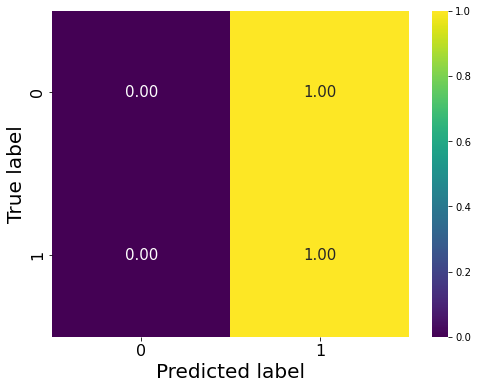

In [40]:
cm_drain_test = confusion_matrix(y_drain_test, best_estimator_drain.predict(X_drain_test), normalize='true')
mmh.plot_confusion_matrix(cm_drain_test, [0, 1])

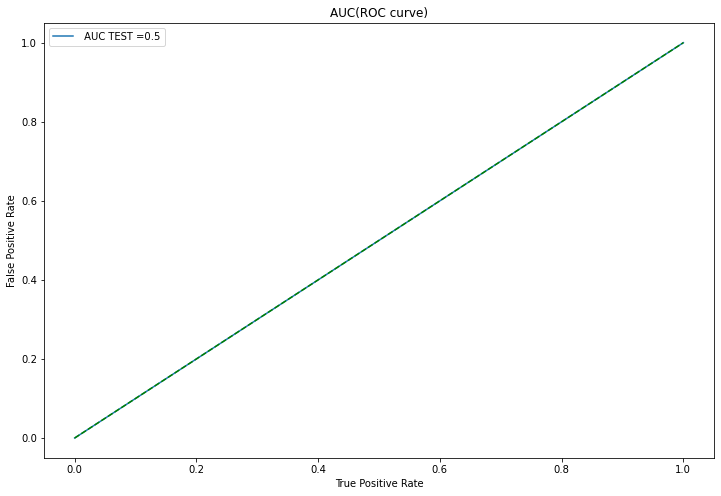

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
test_fpr, test_tpr, te_thresholds = roc_curve(y_drain_test, best_estimator_drain.predict(X_drain_test))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)

# _Doubly Robust Learning_: include `drain` as a feature into `model_y`.
- In doubly robust estimators of ATEs and CATES, the treatment variable is included in `model_y`

In [22]:
y_full = csdh_data['recurrence']
X_full = csdh_data.drop(['recurrence'], axis=1)

In [23]:
# Split into validation set and rest
X_rest, X_test, y_rest, y_test = train_test_split(X_full, y_full, 
                                                test_size=0.20,
                                                random_state=random_state,
                                                stratify=y_full)

# Split rest into train and test set
X_train, X_val, y_train, y_val = train_test_split(X_rest, y_rest, 
                                                    test_size=0.20,
                                                    random_state=random_state,
                                                    stratify=y_rest)

In [24]:
training_scores, val_scores = mmh.train_and_validate_classifiers(X_train, 
                                                                 y_train,
                                                                 X_val,
                                                                 y_val,
                                                                 names,
                                                                 classifiers)

[16:58:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
mmh.print_metrics_table(training_scores, val_scores, names)

Classification performance on validation set: 

             ----------------Validation-----------------   -----------------Training------------------
Method         Acc↑   AUROC↑  Recall↑      F1↑      LL↓     Acc↑   AUROC↑  Recall↑      F1↑      LL↓
----------------------------------------------------------------------------------------------------
Dummy         0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
LR            0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
Linear SVM    0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
RBF SVM       0.908    0.500    0.000    0.000   3.166    0.908    0.500    0.000    0.000    3.193
GB            0.908    0.541    0.091    0.154   3.166    0.962    0.795    0.591    0.743    1.306
RF            0.908    0.500    0.000    0.000   3.166    1.000    1.000    1.000    1.000    0.000
XGB           0.875    0.482    0.000    0.000 

## `model_y` K-Fold cross validation for hyperparameter tuning and model selection

In [26]:
# do the search
_,_, best_estimator = mmh.randomized_search_cv(X_rest, y_rest, 
                                               search_space, 
                                               cv=cv_5,
                                               refit=True,
                                               score='roc_auc',
                                               n_iter=5000, 
                                               verbose=True)

cv strategy StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
----------------------------------------
Trial 0
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            n_estimators=35, random_state=100,
                                            subsample=0.8))])
cv score: [0.64637198 0.70791246 0.64057239 0.39267677 0.45875421]
----------------------------------------
Trial 1
----------------------------------------
Parameters {'gb__n_estimators': 35, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
  

cv score: [0.63469558 0.6026936  0.58459596 0.43434343 0.43013468]
----------------------------------------
Trial 11
----------------------------------------
Parameters {'gb__n_estimators': 160, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                                            max_features='log2',
                                            n_estimators=160, random_state=100,
                                            subsample=0.7))])
cv score: [0.64386989 0.73653199 0.47895623 0.53114478 0.41161616]
----------------------------------------
Trial 12
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 G

cv score: [0.6618015  0.63762626 0.55050505 0.42424242 0.47138047]
----------------------------------------
Trial 24
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=51,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.67472894 0.76515152 0.54292929 0.5513468  0.42255892]
----------------------------------------
Trial 35
----------------------------------------
Parameters {'gb__n_estimators': 38, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=38, random_state=100,
                                            subsample=0.65))])
cv score: [0.60467056 0.56818182 0.56313131 0.42929293 0.43181818]
----------------------------------------
Trial 36
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
               

cv score: [0.68140117 0.65572391 0.51178451 0.50084175 0.44781145]
----------------------------------------
Trial 46
----------------------------------------
Parameters {'xgb__n_estimators': 18, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=18,
                               n_jobs=None, num_parallel_tr

cv score: [0.55796497 0.61616162 0.52441077 0.43434343 0.38215488]
----------------------------------------
Trial 56
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=125,
                               n_jobs=None, num_parallel_tre

cv score: [0.58215179 0.62542088 0.44781145 0.48232323 0.43939394]
----------------------------------------
Trial 66
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_features='sqrt',
                                            n_estimators=181, random_state=100,
                                            subsample=0.7))])
cv score: [0.68723937 0.66498316 0.5547138  0.53367003 0.47474747]
----------------------------------------
Trial 67
----------------------------------------
Parameters {'gb__n_estimators': 90, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoos

cv score: [0.70725605 0.71380471 0.60858586 0.50084175 0.58880471]
----------------------------------------
Trial 77
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=115, random_state=100,
                                            subsample=0.8))])
cv score: [0.58798999 0.76094276 0.48737374 0.53703704 0.31818182]
----------------------------------------
Trial 78
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, b

cv score: [0.71017515 0.69486532 0.62121212 0.51515152 0.51936027]
----------------------------------------
Trial 89
----------------------------------------
Parameters {'rf__n_estimators': 121, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=121,
                                        random_state=100))])
cv score: [0.5        0.63257576 0.49074074 0.4726431  0.47222222]
----------------------------------------
Trial 90
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                           

cv score: [0.56880734 0.67087542 0.47138047 0.45117845 0.38973064]
----------------------------------------
Trial 100
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=134,
                                        random_state=100))])
cv score: [0.49541284 0.621633   0.62289562 0.46212121 0.47222222]
----------------------------------------
Trial 101
----------------------------------------
Parameters {'gb__n_estimators': 169, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
                                      

cv score: [0.61801501 0.61784512 0.48569024 0.50757576 0.36700337]
----------------------------------------
Trial 111
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=51, random_state=100,
                                            subsample=0.65))])
cv score: [0.52210175 0.61026936 0.50757576 0.50757576 0.4006734 ]
----------------------------------------
Trial 112
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.64386989 0.71464646 0.6523569  0.59806397 0.55723906]
----------------------------------------
Trial 121
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=86, random_state=100,
                                            subsample=0.9))])
cv score: [0.50792327 0.67340067 0.45791246 0.49242424 0.37457912]
----------------------------------------
Trial 122
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.66388657 0.62710438 0.41666667 0.43013468 0.4486532 ]
----------------------------------------
Trial 132
----------------------------------------
Parameters {'xgb__n_estimators': 126, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=126,
                               n_jobs=None, num_parallel_tree

cv score: [0.66055046 0.66750842 0.57239057 0.46296296 0.52525253]
----------------------------------------
Trial 141
----------------------------------------
Parameters {'rf__n_estimators': 180, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=180, random_state=100))])
cv score: [0.70141785 0.69360269 0.6010101  0.51936027 0.53030303]
----------------------------------------
Trial 142
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.67472894 0.77356902 0.60185185 0.48737374 0.51683502]
----------------------------------------
Trial 152
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
                               n_jobs=None, num_parallel_tree

cv score: [0.64845705 0.65740741 0.58249158 0.56818182 0.5479798 ]
----------------------------------------
Trial 165
----------------------------------------
Parameters {'xgb__n_estimators': 128, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=128,
                               n_jobs=None, num_parallel_

cv score: [0.66388657 0.66582492 0.56228956 0.48569024 0.47685185]
----------------------------------------
Trial 175
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=77,
                               n_jobs=None, num_parallel_tree=

cv score: [0.63969975 0.74410774 0.55555556 0.52693603 0.56313131]
----------------------------------------
Trial 186
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=72,
                                        random_state=100))])
cv score: [0.6530442  0.67508418 0.5547138  0.48063973 0.53114478]
----------------------------------------
Trial 187
----------------------------------------
Parameters {'gb__n_estimators': 82, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=82, random_state=100,
                                       

cv score: [0.49541284 0.621633   0.62289562 0.46212121 0.47222222]
----------------------------------------
Trial 199
----------------------------------------
Parameters {'gb__n_estimators': 14, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=14, random_state=100,
                                            subsample=0.65))])
cv score: [0.73019183 0.73021886 0.57912458 0.50126263 0.45917508]
----------------------------------------
Trial 200
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.56713928 0.3510101  0.66666667 0.50673401 0.56397306]
----------------------------------------
Trial 212
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=146,
                                        random_state=100))])
cv score: [0.47789825 0.48106061 0.61321549 0.46969697 0.48905724]
----------------------------------------
Trial 213
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                         

cv score: [0.70141785 0.72390572 0.62373737 0.47053872 0.5513468 ]
----------------------------------------
Trial 223
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tre

cv score: [0.62301918 0.6473064  0.54545455 0.51515152 0.40656566]
----------------------------------------
Trial 234
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=114,
                                        random_state=100))])
cv score: [0.71142619 0.71885522 0.61195286 0.4983165  0.58796296]
----------------------------------------
Trial 235
----------------------------------------
Parameters {'xgb__n_estimators': 109, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.67139283 0.69612795 0.61574074 0.57112795 0.54713805]
----------------------------------------
Trial 246
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_t

cv score: [0.68056714 0.69823232 0.61069024 0.57744108 0.56397306]
----------------------------------------
Trial 255
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=89,
                               n_jobs=None, num_parallel_t

cv score: [0.63135947 0.6473064  0.52525253 0.50084175 0.38636364]
----------------------------------------
Trial 266
----------------------------------------
Parameters {'xgb__n_estimators': 158, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=158,
                               n_jobs=None, num_parallel_tree

cv score: [0.65638032 0.75673401 0.39478114 0.49747475 0.47474747]
----------------------------------------
Trial 276
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=73, random_state=100))])
cv score: [0.68974145 0.70959596 0.59343434 0.5        0.49074074]
----------------------------------------
Trial 277
----------------------------------------
Parameters {'xgb__n_estimators': 124, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
      

cv score: [0.69641368 0.72643098 0.5547138  0.52020202 0.52356902]
----------------------------------------
Trial 287
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=99,
                                        random_state=100))])
cv score: [0.70475396 0.70159933 0.59343434 0.49284512 0.55723906]
----------------------------------------
Trial 288
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                   

cv score: [0.62885738 0.66666667 0.62373737 0.57407407 0.52441077]
----------------------------------------
Trial 299
----------------------------------------
Parameters {'gb__n_estimators': 104, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
                                            n_estimators=104, random_state=100,
                                            subsample=0.65))])
cv score: [0.6705588  0.70117845 0.57996633 0.55808081 0.53956229]
----------------------------------------
Trial 300
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.61968307 0.6489899  0.43771044 0.50420875 0.44949495]
----------------------------------------
Trial 311
----------------------------------------
Parameters {'rf__n_estimators': 129, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=129, random_state=100))])
cv score: [0.7030859  0.73905724 0.57323232 0.46801347 0.47222222]
----------------------------------------
Trial 312
----------------------------------------
Parameters {'gb__n_estimators': 57, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            n_estimators=57, random_state=100,
               

cv score: [0.60216847 0.64646465 0.51936027 0.49410774 0.42171717]
----------------------------------------
Trial 321
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='log2',
                                            n_estimators=71,
                                            random_state=100))])
cv score: [0.65221018 0.67087542 0.3956229  0.44949495 0.48737374]
----------------------------------------
Trial 322
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoos

cv score: [0.64804003 0.61952862 0.48653199 0.47727273 0.34343434]
----------------------------------------
Trial 331
----------------------------------------
Parameters {'xgb__n_estimators': 171, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=171,
                               n_jobs=None, num_parallel_tr

cv score: [0.60550459 0.61279461 0.52188552 0.45538721 0.39478114]
----------------------------------------
Trial 344
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_

cv score: [0.63135947 0.69991582 0.64436027 0.59848485 0.54292929]
----------------------------------------
Trial 354
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_t

cv score: [0.48123436 0.59175084 0.59427609 0.37626263 0.47222222]
----------------------------------------
Trial 363
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=8,
                                            n_estimators=10, random_state=100,
                                            subsample=0.6))])
cv score: [0.59049208 0.69023569 0.62247475 0.35016835 0.4503367 ]
----------------------------------------
Trial 364
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                      

cv score: [0.70475396 0.71632997 0.57070707 0.50252525 0.496633  ]
----------------------------------------
Trial 374
----------------------------------------
Parameters {'rf__n_estimators': 40, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=40,
                                        random_state=100))])
cv score: [0.72768974 0.55429293 0.6266835  0.40277778 0.37794613]
----------------------------------------
Trial 375
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=

cv score: [0.55713094 0.60521886 0.50252525 0.53198653 0.38888889]
----------------------------------------
Trial 383
----------------------------------------
Parameters {'rf__n_estimators': 67, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features=None,
                                        n_estimators=67, random_state=100))])
cv score: [0.66930776 0.64436027 0.50589226 0.503367   0.49789562]
----------------------------------------
Trial 384
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=48,
                                        random_stat

cv score: [0.58215179 0.62457912 0.46969697 0.49242424 0.39814815]
----------------------------------------
Trial 394
----------------------------------------
Parameters {'gb__n_estimators': 17, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=17, random_state=100,
                                            subsample=0.6))])
cv score: [0.54378649 0.61195286 0.53451178 0.54882155 0.42255892]
----------------------------------------
Trial 395
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boost

cv score: [0.58882402 0.65572391 0.41919192 0.55723906 0.35942761]
----------------------------------------
Trial 404
----------------------------------------
Parameters {'rf__n_estimators': 87, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=87, random_state=100))])
cv score: [0.65471226 0.67592593 0.65909091 0.46127946 0.49494949]
----------------------------------------
Trial 405
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
          

cv score: [0.59299416 0.62542088 0.51599327 0.47979798 0.3989899 ]
----------------------------------------
Trial 414
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=68, random_state=100))])
cv score: [0.63969975 0.72053872 0.59090909 0.50505051 0.41161616]
----------------------------------------
Trial 415
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
     

cv score: [0.58715596 0.6473064  0.56902357 0.47643098 0.35185185]
----------------------------------------
Trial 425
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=136,
                                        random_state=100))])
cv score: [0.6647206  0.70622896 0.49747475 0.48484848 0.49326599]
----------------------------------------
Trial 426
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.66055046 0.57491582 0.47053872 0.43181818 0.4452862 ]
----------------------------------------
Trial 436
----------------------------------------
Parameters {'gb__n_estimators': 162, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='log2',
                                            n_estimators=162, random_state=100,
                                            subsample=0.9))])
cv score: [0.64470392 0.73063973 0.46969697 0.47222222 0.42340067]
----------------------------------------
Trial 437
----------------------------------------
Parameters {'gb__n_estimators': 74, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
              

cv score: [0.64970809 0.66245791 0.503367   0.49242424 0.36952862]
----------------------------------------
Trial 448
----------------------------------------
Parameters {'rf__n_estimators': 144, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=144,
                                        random_state=100))])
cv score: [0.69057548 0.69023569 0.62457912 0.49494949 0.5719697 ]
----------------------------------------
Trial 449
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=35, random_st

cv score: [0.53586322 0.71464646 0.4537037  0.46885522 0.57996633]
----------------------------------------
Trial 459
----------------------------------------
Parameters {'gb__n_estimators': 147, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=147, random_state=100,
                                            subsample=0.65))])
cv score: [0.60467056 0.40572391 0.54292929 0.51262626 0.32070707]
----------------------------------------
Trial 460
----------------------------------------
Parameters {'xgb__n_estimators': 162, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.69057548 0.753367   0.59006734 0.49074074 0.47138047]
----------------------------------------
Trial 470
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=105,
                               n_jobs=None, num_parallel_

cv score: [0.59549625 0.61952862 0.46885522 0.52861953 0.40740741]
----------------------------------------
Trial 480
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=57,
                                        random_state=100))])
cv score: [0.72977481 0.67929293 0.57786195 0.50084175 0.57323232]
----------------------------------------
Trial 481
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=45, random_stat

cv score: [0.68390325 0.76346801 0.55639731 0.47979798 0.53198653]
----------------------------------------
Trial 494
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=11,
                                        random_state=100))])
cv score: [0.68557131 0.6712963  0.58164983 0.51515152 0.59638047]
----------------------------------------
Trial 495
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_f

cv score: [0.63886572 0.64351852 0.62920875 0.6043771  0.50968013]
----------------------------------------
Trial 505
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='log2',
                                            n_estimators=148, random_state=100,
                                            subsample=0.75))])
cv score: [0.61718098 0.70454545 0.50925926 0.50505051 0.38888889]
----------------------------------------
Trial 506
----------------------------------------
Parameters {'gb__n_estimators': 72, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
             

cv score: [0.59966639 0.64478114 0.49579125 0.51515152 0.3956229 ]
----------------------------------------
Trial 517
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='log2',
                                            n_estimators=170, random_state=100,
                                            subsample=0.85))])
cv score: [0.62468724 0.71043771 0.41666667 0.48737374 0.41919192]
----------------------------------------
Trial 518
----------------------------------------
Parameters {'rf__n_estimators': 75, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.66055046 0.68939394 0.53787879 0.59343434 0.54208754]
----------------------------------------
Trial 527
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parallel_

cv score: [0.65804837 0.68013468 0.496633   0.52104377 0.49242424]
----------------------------------------
Trial 538
----------------------------------------
Parameters {'xgb__n_estimators': 114, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=114,
                               n_jobs=None, num_parallel_tre

cv score: [0.49541284 0.621633   0.62289562 0.46212121 0.47222222]
----------------------------------------
Trial 548
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=23,
                               n_jobs=None, num_parallel_tree

cv score: [0.65554629 0.63468013 0.45538721 0.46380471 0.43518519]
----------------------------------------
Trial 559
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_tree=

cv score: [0.55045872 0.67592593 0.53535354 0.50505051 0.43518519]
----------------------------------------
Trial 569
----------------------------------------
Parameters {'xgb__n_estimators': 41, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=41,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.61551293 0.61026936 0.47811448 0.52188552 0.37121212]
----------------------------------------
Trial 580
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
                               n_jobs=None, num_parallel

cv score: [0.74603837 0.51262626 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 590
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=140,
                               n_jobs=None, num_parallel_tree

cv score: [0.62885738 0.74747475 0.45622896 0.43518519 0.39393939]
----------------------------------------
Trial 600
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=84, random_state=100,
                                            subsample=0.9))])
cv score: [0.52793995 0.59259259 0.59680135 0.45454545 0.36616162]
----------------------------------------
Trial 601
----------------------------------------
Parameters {'rf__n_estimators': 10, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bo

cv score: [0.60050042 0.70454545 0.4983165  0.48316498 0.42424242]
----------------------------------------
Trial 611
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=28, random_state=100,
                                            subsample=0.6))])
cv score: [0.68890742 0.55976431 0.58501684 0.50420875 0.50547138]
----------------------------------------
Trial 612
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.55129274 0.61279461 0.38804714 0.46885522 0.38131313]
----------------------------------------
Trial 622
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            n_estimators=148, random_state=100,
                                            subsample=0.8))])
cv score: [0.63886572 0.62794613 0.61363636 0.5530303  0.3030303 ]
----------------------------------------
Trial 623
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                  

cv score: [0.65471226 0.67255892 0.61111111 0.56902357 0.52356902]
----------------------------------------
Trial 634
----------------------------------------
Parameters {'rf__n_estimators': 97, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=97, random_state=100))])
cv score: [0.69474562 0.68518519 0.56734007 0.51430976 0.53619529]
----------------------------------------
Trial 635
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=80,
                                        random_state=100)

cv score: [0.59466222 0.67424242 0.53451178 0.46717172 0.25673401]
----------------------------------------
Trial 644
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            n_estimators=166, random_state=100,
                                            subsample=0.75))])
cv score: [0.69140951 0.71127946 0.49915825 0.4040404  0.45454545]
----------------------------------------
Trial 645
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
               

cv score: [0.62135113 0.70538721 0.57491582 0.50505051 0.46043771]
----------------------------------------
Trial 655
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=105, random_state=100))])
cv score: [0.64720601 0.64393939 0.55723906 0.46632997 0.51010101]
----------------------------------------
Trial 656
----------------------------------------
Parameters {'rf__n_estimators': 152, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=152,
                                        random_stat

cv score: [0.60800667 0.76515152 0.55513468 0.50210438 0.48316498]
----------------------------------------
Trial 668
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=86,
                                        random_state=100))])
cv score: [0.70725605 0.75420875 0.54713805 0.50925926 0.53451178]
----------------------------------------
Trial 669
----------------------------------------
Parameters {'gb__n_estimators': 140, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                    

cv score: [0.49624687 0.66414141 0.48400673 0.47811448 0.48737374]
----------------------------------------
Trial 677
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel

cv score: [0.55462886 0.62205387 0.50589226 0.44444444 0.41498316]
----------------------------------------
Trial 684
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_t

cv score: [0.65471226 0.69149832 0.42340067 0.55555556 0.48989899]
----------------------------------------
Trial 695
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, num_parallel_tree=Non

cv score: [0.55629691 0.67508418 0.54208754 0.5513468  0.36447811]
----------------------------------------
Trial 706
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=151,
                                            random_state=100,
                                            subsample=0.85))])
cv score: [0.61301084 0.70959596 0.44276094 0.51599327 0.36447811]
----------------------------------------
Trial 707
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                     

cv score: [0.62718932 0.72138047 0.54545455 0.41245791 0.36784512]
----------------------------------------
Trial 718
----------------------------------------
Parameters {'xgb__n_estimators': 13, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=13,
                               n_jobs=None, num_parallel_tree

cv score: [0.6205171  0.66498316 0.49158249 0.37710438 0.36784512]
----------------------------------------
Trial 727
----------------------------------------
Parameters {'rf__n_estimators': 125, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=125, random_state=100))])
cv score: [0.69724771 0.76178451 0.55976431 0.52861953 0.41666667]
----------------------------------------
Trial 728
----------------------------------------
Parameters {'rf__n_estimators': 56, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features='sqrt', n_estimators=56,
                                        random_

cv score: [0.64136781 0.65656566 0.45959596 0.44023569 0.44781145]
----------------------------------------
Trial 738
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=77,
                               n_jobs=None, num_parallel_tree

cv score: [0.62885738 0.63299663 0.496633   0.47895623 0.41077441]
----------------------------------------
Trial 748
----------------------------------------
Parameters {'xgb__n_estimators': 92, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=92,
                               n_jobs=None, num_parallel_tree

cv score: [0.62468724 0.74579125 0.56228956 0.51683502 0.47390572]
----------------------------------------
Trial 758
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_tr

cv score: [0.69891576 0.66582492 0.57491582 0.45622896 0.51430976]
----------------------------------------
Trial 769
----------------------------------------
Parameters {'gb__n_estimators': 103, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='sqrt',
                                            n_estimators=103, random_state=100,
                                            subsample=0.85))])
cv score: [0.53711426 0.6026936  0.56144781 0.46085859 0.44107744]
----------------------------------------
Trial 770
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
 

cv score: [0.50792327 0.62373737 0.53367003 0.54124579 0.50252525]
----------------------------------------
Trial 779
----------------------------------------
Parameters {'rf__n_estimators': 73, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=73,
                                        random_state=100))])
cv score: [0.49541284 0.621633   0.62289562 0.46212121 0.47222222]
----------------------------------------
Trial 780
----------------------------------------
Parameters {'gb__n_estimators': 198, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n

cv score: [0.61551293 0.61363636 0.43771044 0.41877104 0.3956229 ]
----------------------------------------
Trial 789
----------------------------------------
Parameters {'xgb__n_estimators': 54, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=54,
                               n_jobs=None, num_parallel_tree

cv score: [0.53044204 0.41245791 0.55639731 0.58838384 0.39983165]
----------------------------------------
Trial 800
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=83, random_state=100))])
cv score: [0.62969141 0.75505051 0.57659933 0.51262626 0.42508418]
----------------------------------------
Trial 801
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                            max_features='sqrt',
                                 

cv score: [0.53794829 0.70707071 0.51010101 0.44023569 0.44023569]
----------------------------------------
Trial 812
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=158, random_state=100,
                                            subsample=0.6))])
cv score: [0.60550459 0.64478114 0.48148148 0.46632997 0.42508418]
----------------------------------------
Trial 813
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.63886572 0.68013468 0.55976431 0.53282828 0.48484848]
----------------------------------------
Trial 822
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                            n_estimators=117, random_state=100,
                                            subsample=0.75))])
cv score: [0.62301918 0.61616162 0.52272727 0.47811448 0.46885522]
----------------------------------------
Trial 823
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=Non

cv score: [0.66722269 0.66414141 0.54713805 0.50925926 0.48400673]
----------------------------------------
Trial 830
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_tre

cv score: [0.66430359 0.66456229 0.54335017 0.57070707 0.59806397]
----------------------------------------
Trial 841
----------------------------------------
Parameters {'rf__n_estimators': 57, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=57, random_state=100))])
cv score: [0.74478732 0.67340067 0.59427609 0.51851852 0.46717172]
----------------------------------------
Trial 842
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 1.0, 'gb__learning_rate': 0.01, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=12,
                                            max_features='sqrt',
                              

cv score: [0.61968307 0.70117845 0.40151515 0.46212121 0.41498316]
----------------------------------------
Trial 855
----------------------------------------
Parameters {'rf__n_estimators': 55, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=55, random_state=100))])
cv score: [0.60383653 0.65740741 0.5513468  0.55808081 0.503367  ]
----------------------------------------
Trial 856
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimators=136,
                                        random_state=10

cv score: [0.65221018 0.8047138  0.56818182 0.49242424 0.46464646]
----------------------------------------
Trial 868
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=157, random_state=100,
                                            subsample=0.95))])
cv score: [0.46872394 0.53956229 0.56565657 0.46127946 0.38215488]
----------------------------------------
Trial 869
----------------------------------------
Parameters {'rf__n_estimators': 117, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(ma

cv score: [0.6530442  0.71380471 0.52104377 0.48400673 0.53198653]
----------------------------------------
Trial 879
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=66,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.62718932 0.67508418 0.4520202  0.47138047 0.41498316]
----------------------------------------
Trial 889
----------------------------------------
Parameters {'gb__n_estimators': 23, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            n_estimators=23,
                                            random_state=100))])
cv score: [0.72226856 0.55892256 0.63299663 0.45244108 0.50505051]
----------------------------------------
Trial 890
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimat

cv score: [0.65804837 0.80639731 0.57912458 0.48400673 0.46632997]
----------------------------------------
Trial 900
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=23,
                                        random_state=100))])
cv score: [0.5733945  0.6473064  0.52693603 0.48106061 0.52819865]
----------------------------------------
Trial 901
----------------------------------------
Parameters {'rf__n_estimators': 77, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=77, random_state=

cv score: [0.63928274 0.70917508 0.60690236 0.53956229 0.55429293]
----------------------------------------
Trial 916
----------------------------------------
Parameters {'rf__n_estimators': 121, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=121,
                                        random_state=100))])
cv score: [0.67556297 0.69360269 0.52525253 0.47979798 0.5016835 ]
----------------------------------------
Trial 917
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.62218515 0.6043771  0.49579125 0.52188552 0.42340067]
----------------------------------------
Trial 925
----------------------------------------
Parameters {'rf__n_estimators': 23, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=23, random_state=100))])
cv score: [0.70642202 0.76515152 0.51936027 0.45707071 0.46885522]
----------------------------------------
Trial 926
----------------------------------------
Parameters {'xgb__n_estimators': 188, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.57130942 0.64478114 0.55976431 0.47474747 0.42845118]
----------------------------------------
Trial 937
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=35,
                                        random_state=100))])
cv score: [0.6588824  0.71717172 0.57828283 0.41245791 0.5479798 ]
----------------------------------------
Trial 938
----------------------------------------
Parameters {'rf__n_estimators': 38, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=38, random_st

cv score: [0.68974145 0.74915825 0.61026936 0.54545455 0.48232323]
----------------------------------------
Trial 949
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=141,
                                        random_state=100))])
cv score: [0.74603837 0.51262626 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 950
----------------------------------------
Parameters {'gb__n_estimators': 111, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=8,
                                       

cv score: [0.62135113 0.62037037 0.53956229 0.43265993 0.36952862]
----------------------------------------
Trial 960
----------------------------------------
Parameters {'rf__n_estimators': 159, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=159,
                                        random_state=100))])
cv score: [0.6647206  0.74074074 0.54124579 0.44949495 0.51010101]
----------------------------------------
Trial 961
----------------------------------------
Parameters {'gb__n_estimators': 46, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=7,
                                 

cv score: [0.64053378 0.63131313 0.54124579 0.47895623 0.42592593]
----------------------------------------
Trial 970
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=90, random_state=100))])
cv score: [0.6530442  0.75589226 0.52861953 0.55639731 0.49158249]
----------------------------------------
Trial 971
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=22,
                                        random_state=10

cv score: [0.60717264 0.64393939 0.50505051 0.51010101 0.42845118]
----------------------------------------
Trial 980
----------------------------------------
Parameters {'rf__n_estimators': 192, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=192,
                                        random_state=100))])
cv score: [0.62844037 0.61826599 0.55050505 0.42550505 0.39814815]
----------------------------------------
Trial 981
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=4,
                                      

cv score: [0.6793161  0.7003367  0.56439394 0.49789562 0.5530303 ]
----------------------------------------
Trial 991
----------------------------------------
Parameters {'gb__n_estimators': 45, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            n_estimators=45, random_state=100,
                                            subsample=0.7))])
cv score: [0.676397   0.71801347 0.57323232 0.46212121 0.44023569]
----------------------------------------
Trial 992
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, n_estimators=189,
       

cv score: [0.60717264 0.57659933 0.52356902 0.4469697  0.46043771]
----------------------------------------
Trial 1002
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel_t

cv score: [0.61217681 0.63804714 0.47053872 0.53367003 0.47979798]
----------------------------------------
Trial 1011
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=152, random_state=100,
                                            subsample=0.7))])
cv score: [0.63469558 0.68265993 0.57828283 0.46969697 0.45454545]
----------------------------------------
Trial 1012
----------------------------------------
Parameters {'gb__n_estimators': 119, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,

cv score: [0.7264387  0.68013468 0.57154882 0.54713805 0.51683502]
----------------------------------------
Trial 1024
----------------------------------------
Parameters {'gb__n_estimators': 193, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_features='sqrt',
                                            n_estimators=193, random_state=100,
                                            subsample=0.9))])
cv score: [0.68390325 0.71212121 0.44023569 0.42424242 0.4040404 ]
----------------------------------------
Trial 1025
----------------------------------------
Parameters {'gb__n_estimators': 51, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
               

cv score: [0.6088407  0.61531987 0.45538721 0.47643098 0.49074074]
----------------------------------------
Trial 1038
----------------------------------------
Parameters {'rf__n_estimators': 151, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=151, random_state=100))])
cv score: [0.66555463 0.77356902 0.56565657 0.47727273 0.48021886]
----------------------------------------
Trial 1039
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=88, random_state=100))])
cv score: [0.65971643 0.67340067 0.65824916 0.

cv score: [0.55546289 0.54208754 0.59848485 0.50757576 0.37878788]
----------------------------------------
Trial 1049
----------------------------------------
Parameters {'rf__n_estimators': 107, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=107,
                                        random_state=100))])
cv score: [0.74603837 0.51262626 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 1050
----------------------------------------
Parameters {'xgb__n_estimators': 139, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.53127606 0.63468013 0.47979798 0.43013468 0.40572391]
----------------------------------------
Trial 1059
----------------------------------------
Parameters {'rf__n_estimators': 20, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=20, random_state=100))])
cv score: [0.6588824  0.68434343 0.46885522 0.6043771  0.42760943]
----------------------------------------
Trial 1060
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.8, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                              

cv score: [0.64720601 0.62626263 0.40993266 0.48989899 0.4452862 ]
----------------------------------------
Trial 1070
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
                               n_jobs=None, num_parallel_

cv score: [0.6647206  0.70075758 0.63299663 0.58543771 0.5513468 ]
----------------------------------------
Trial 1079
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_estimators=190,
                                        random_state=100))])
cv score: [0.66138449 0.73400673 0.50673401 0.45538721 0.50505051]
----------------------------------------
Trial 1080
----------------------------------------
Parameters {'rf__n_estimators': 130, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=130, random_

cv score: [0.65638032 0.66666667 0.6233165  0.62121212 0.53451178]
----------------------------------------
Trial 1089
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.62301918 0.65572391 0.40909091 0.53367003 0.37710438]
----------------------------------------
Trial 1100
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=22, random_state=100,
                                            subsample=0.7))])
cv score: [0.60133445 0.71801347 0.49915825 0.54292929 0.51262626]
----------------------------------------
Trial 1101
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.63969975 0.71001684 0.56986532 0.59553872 0.57828283]
----------------------------------------
Trial 1107
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=192, random_state=100,
                                            subsample=0.65))])
cv score: [0.57297748 0.65824916 0.51178451 0.43518519 0.35690236]
----------------------------------------
Trial 1108
----------------------------------------
Parameters {'xgb__n_estimators': 59, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boost

cv score: [0.6705588  0.73989899 0.61700337 0.5016835  0.46548822]
----------------------------------------
Trial 1117
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=159,
                                            random_state=100))])
cv score: [0.6205171  0.61700337 0.63888889 0.3989899  0.38047138]
----------------------------------------
Trial 1118
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=7,
                

cv score: [0.68723937 0.56313131 0.61952862 0.48232323 0.30218855]
----------------------------------------
Trial 1130
----------------------------------------
Parameters {'xgb__n_estimators': 143, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=143,
                               n_jobs=None, num_parallel_tr

cv score: [0.6205171  0.64393939 0.47558923 0.49579125 0.41750842]
----------------------------------------
Trial 1141
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_tr

cv score: [0.61050876 0.71548822 0.47222222 0.50252525 0.40824916]
----------------------------------------
Trial 1152
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=4,
                                            max_features='log2',
                                            n_estimators=184, random_state=100,
                                            subsample=0.8))])
cv score: [0.69307756 0.71885522 0.58585859 0.49326599 0.53619529]
----------------------------------------
Trial 1153
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.66055046 0.67760943 0.5530303  0.49284512 0.46969697]
----------------------------------------
Trial 1165
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.9, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            n_estimators=93, random_state=100,
                                            subsample=0.9))])
cv score: [0.65054212 0.63552189 0.43350168 0.4520202  0.48400673]
----------------------------------------
Trial 1166
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                    

cv score: [0.61217681 0.67845118 0.52777778 0.44612795 0.54545455]
----------------------------------------
Trial 1175
----------------------------------------
Parameters {'rf__n_estimators': 89, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=89, random_state=100))])
cv score: [0.70141785 0.76346801 0.52104377 0.50420875 0.43265993]
----------------------------------------
Trial 1176
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
  

cv score: [0.74603837 0.51262626 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 1185
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=106,
                                        random_state=100))])
cv score: [0.66555463 0.72727273 0.57070707 0.43855219 0.53787879]
----------------------------------------
Trial 1186
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.62885738 0.66077441 0.57744108 0.58543771 0.53156566]
----------------------------------------
Trial 1196
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tree

cv score: [0.65054212 0.59848485 0.5        0.52104377 0.36111111]
----------------------------------------
Trial 1204
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=195, random_state=100))])
cv score: [0.69891576 0.76599327 0.43518519 0.48232323 0.48821549]
----------------------------------------
Trial 1205
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.7, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            n_estimators=26, random_state=100,
                

cv score: [0.60717264 0.58207071 0.4537037  0.51599327 0.51515152]
----------------------------------------
Trial 1216
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            max_features='log2',
                                            n_estimators=124, random_state=100,
                                            subsample=0.8))])
cv score: [0.55212677 0.53619529 0.55976431 0.47643098 0.26515152]
----------------------------------------
Trial 1217
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.61968307 0.64814815 0.55892256 0.42760943 0.30050505]
----------------------------------------
Trial 1229
----------------------------------------
Parameters {'gb__n_estimators': 115, 'gb__subsample': 0.7, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            n_estimators=115, random_state=100,
                                            subsample=0.7))])
cv score: [0.69808173 0.6473064  0.40909091 0.27441077 0.42424242]
----------------------------------------
Trial 1230
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster

cv score: [0.67014178 0.71885522 0.56649832 0.6506734  0.55555556]
----------------------------------------
Trial 1239
----------------------------------------
Parameters {'xgb__n_estimators': 108, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=108,
                               n_jobs=None, num_parall

cv score: [0.67806505 0.72222222 0.5976431  0.52693603 0.46717172]
----------------------------------------
Trial 1247
----------------------------------------
Parameters {'gb__n_estimators': 148, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=148, random_state=100,
                                            subsample=0.7))])
cv score: [0.66388657 0.70454545 0.56818182 0.47979798 0.5       ]
----------------------------------------
Trial 1248
----------------------------------------
Parameters {'xgb__n_estimators': 102, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.6501251  0.66666667 0.61616162 0.61279461 0.52441077]
----------------------------------------
Trial 1257
----------------------------------------
Parameters {'rf__n_estimators': 78, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=78,
                                        random_state=100))])
cv score: [0.74603837 0.51262626 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 1258
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 1.0, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                      

cv score: [0.5971643  0.71927609 0.56228956 0.40993266 0.51936027]
----------------------------------------
Trial 1268
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=66,
                               n_jobs=None, num_parallel_tr

cv score: [0.64970809 0.65488215 0.66329966 0.49242424 0.50841751]
----------------------------------------
Trial 1279
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            n_estimators=182, random_state=100,
                                            subsample=0.9))])
cv score: [0.62969141 0.55976431 0.62710438 0.4983165  0.33585859]
----------------------------------------
Trial 1280
----------------------------------------
Parameters {'xgb__n_estimators': 129, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.69057548 0.64057239 0.48653199 0.53114478 0.37373737]
----------------------------------------
Trial 1288
----------------------------------------
Parameters {'xgb__n_estimators': 164, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=164,
                               n_jobs=None, num_parallel

cv score: [0.5971643  0.6506734  0.53198653 0.53619529 0.38299663]
----------------------------------------
Trial 1296
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=48,
                               n_jobs=None, num_parallel

cv score: [0.63969975 0.62794613 0.50841751 0.51430976 0.38468013]
----------------------------------------
Trial 1306
----------------------------------------
Parameters {'rf__n_estimators': 156, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=156,
                                        random_state=100))])
cv score: [0.67723103 0.76936027 0.46969697 0.53198653 0.49915825]
----------------------------------------
Trial 1307
----------------------------------------
Parameters {'xgb__n_estimators': 175, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                  

cv score: [0.61092577 0.65614478 0.52693603 0.44486532 0.5513468 ]
----------------------------------------
Trial 1317
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=93, random_state=100,
                                            subsample=0.75))])
cv score: [0.69391159 0.73989899 0.49074074 0.47306397 0.44276094]
----------------------------------------
Trial 1318
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.59883236 0.59343434 0.52020202 0.51178451 0.45707071]
----------------------------------------
Trial 1328
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
                               n_jobs=None, num_para

cv score: [0.65721435 0.67255892 0.56944444 0.57575758 0.49158249]
----------------------------------------
Trial 1336
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=73,
                               n_jobs=None, num_parallel_tree=

cv score: [0.58715596 0.60521886 0.51767677 0.48148148 0.43855219]
----------------------------------------
Trial 1346
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=197, random_state=100))])
cv score: [0.72143453 0.69360269 0.56734007 0.54545455 0.47811448]
----------------------------------------
Trial 1347
----------------------------------------
Parameters {'gb__n_estimators': 184, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=8,
                                            max_features='sqrt',
                             

                                            subsample=0.6))])
cv score: [0.64804003 0.41582492 0.57407407 0.40740741 0.53114478]
----------------------------------------
Trial 1359
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=139, random_state=100,
                                            subsample=0.7))])
cv score: [0.6146789  0.72811448 0.46043771 0.46717172 0.42171717]
----------------------------------------
Trial 1360
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 10, 'xgb__colsa

cv score: [0.5        0.49537037 0.5        0.48611111 0.49537037]
----------------------------------------
Trial 1370
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_t

cv score: [0.62218515 0.62037037 0.46885522 0.48737374 0.48905724]
----------------------------------------
Trial 1381
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=169,
                                        random_state=100))])
cv score: [0.5        0.63257576 0.49074074 0.4726431  0.47222222]
----------------------------------------
Trial 1382
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                        

cv score: [0.70809008 0.66077441 0.47558923 0.46212121 0.33164983]
----------------------------------------
Trial 1393
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
                               n_jobs=None, num_parallel_tre

cv score: [0.64970809 0.65319865 0.59175084 0.49579125 0.52525253]
----------------------------------------
Trial 1403
----------------------------------------
Parameters {'gb__n_estimators': 22, 'gb__subsample': 0.65, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            n_estimators=22, random_state=100,
                                            subsample=0.65))])
cv score: [0.59883236 0.60521886 0.62037037 0.41077441 0.47390572]
----------------------------------------
Trial 1404
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                            

cv score: [0.62885738 0.61700337 0.47979798 0.56986532 0.28535354]
----------------------------------------
Trial 1414
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=12,
                                            n_estimators=123, random_state=100,
                                            subsample=0.65))])
cv score: [0.60800667 0.66414141 0.47474747 0.46969697 0.4452862 ]
----------------------------------------
Trial 1415
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,


cv score: [0.64720601 0.66582492 0.48569024 0.43350168 0.40488215]
----------------------------------------
Trial 1424
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            n_estimators=189, random_state=100,
                                            subsample=0.65))])
cv score: [0.62468724 0.69612795 0.54292929 0.50084175 0.43350168]
----------------------------------------
Trial 1425
----------------------------------------
Parameters {'xgb__n_estimators': 154, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None

cv score: [0.68098415 0.69065657 0.58249158 0.55555556 0.5462963 ]
----------------------------------------
Trial 1433
----------------------------------------
Parameters {'gb__n_estimators': 63, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=63, random_state=100,
                                            subsample=0.8))])
cv score: [0.6088407  0.5547138  0.37962963 0.55639731 0.48148148]
----------------------------------------
Trial 1434
----------------------------------------
Parameters {'gb__n_estimators': 62, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.68056714 0.71212121 0.56313131 0.55723906 0.5479798 ]
----------------------------------------
Trial 1445
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=199,
                               n_jobs=None, num_parall

cv score: [0.65971643 0.7037037  0.45875421 0.51346801 0.35942761]
----------------------------------------
Trial 1455
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                                            n_estimators=129, random_state=100,
                                            subsample=0.65))])
cv score: [0.67306088 0.58417508 0.5016835  0.4040404  0.53282828]
----------------------------------------
Trial 1456
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.68306922 0.78577441 0.57154882 0.46506734 0.4776936 ]
----------------------------------------
Trial 1465
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=199,
                                        random_state=100))])
cv score: [0.70058382 0.56523569 0.55260943 0.4229798  0.41961279]
----------------------------------------
Trial 1466
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimato

cv score: [0.64011676 0.69823232 0.64183502 0.59848485 0.5206229 ]
----------------------------------------
Trial 1479
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=146, random_state=100,
                                            subsample=0.75))])
cv score: [0.59382819 0.62626263 0.73148148 0.41835017 0.27104377]
----------------------------------------
Trial 1480
----------------------------------------
Parameters {'gb__n_estimators': 194, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.69516264 0.70496633 0.63425926 0.49705387 0.56860269]
----------------------------------------
Trial 1489
----------------------------------------
Parameters {'xgb__n_estimators': 153, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=153,
                               n_jobs=None, num_parall

cv score: [0.5646372  0.63215488 0.50841751 0.51178451 0.37289562]
----------------------------------------
Trial 1499
----------------------------------------
Parameters {'xgb__n_estimators': 38, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=38,
                               n_jobs=None, num_parallel_

cv score: [0.70975813 0.6523569  0.45286195 0.54545455 0.38720539]
----------------------------------------
Trial 1512
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                                            n_estimators=49, random_state=100,
                                            subsample=0.6))])
cv score: [0.35696414 0.56313131 0.61447811 0.4040404  0.30976431]
----------------------------------------
Trial 1513
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.66638866 0.7003367  0.57154882 0.49789562 0.60016835]
----------------------------------------
Trial 1521
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=39,
                               n_jobs=None, num_parallel_tre

cv score: [0.62468724 0.67508418 0.46464646 0.48905724 0.496633  ]
----------------------------------------
Trial 1531
----------------------------------------
Parameters {'rf__n_estimators': 12, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=12,
                                        random_state=100))])
cv score: [0.70475396 0.59343434 0.56860269 0.44612795 0.55176768]
----------------------------------------
Trial 1532
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                 

cv score: [0.65971643 0.53787879 0.49494949 0.51430976 0.23316498]
----------------------------------------
Trial 1542
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=10,
                               n_jobs=None, num_parallel_tr

cv score: [0.64970809 0.65993266 0.45959596 0.46717172 0.40572391]
----------------------------------------
Trial 1552
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=99,
                                        random_state=100))])
cv score: [0.64720601 0.73905724 0.55050505 0.46632997 0.52356902]
----------------------------------------
Trial 1553
----------------------------------------
Parameters {'gb__n_estimators': 180, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                

cv score: [0.67139283 0.62626263 0.48484848 0.46801347 0.33922559]
----------------------------------------
Trial 1565
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=61,
                               n_jobs=None, num_parallel_tree=

cv score: [0.58465388 0.65993266 0.46043771 0.4452862  0.41414141]
----------------------------------------
Trial 1573
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=107,
                               n_jobs=None, num_parallel_tre

cv score: [0.66722269 0.64478114 0.54040404 0.40656566 0.51010101]
----------------------------------------
Trial 1584
----------------------------------------
Parameters {'xgb__n_estimators': 94, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=94,
                               n_jobs=None, num_parallel_tre

cv score: [0.64303586 0.62710438 0.55218855 0.50505051 0.38552189]
----------------------------------------
Trial 1595
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=134,
                                        random_state=100))])
cv score: [0.70725605 0.69949495 0.57828283 0.49579125 0.59048822]
----------------------------------------
Trial 1596
----------------------------------------
Parameters {'gb__n_estimators': 60, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=13,
                                

cv score: [0.64136781 0.73821549 0.55387205 0.47727273 0.52861953]
----------------------------------------
Trial 1606
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=14,
                                        random_state=100))])
cv score: [0.62844037 0.62037037 0.55050505 0.42550505 0.40151515]
----------------------------------------
Trial 1607
----------------------------------------
Parameters {'xgb__n_estimators': 40, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                           

cv score: [0.58381985 0.68265993 0.49579125 0.49158249 0.50084175]
----------------------------------------
Trial 1617
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=152,
                               n_jobs=None, num_parallel_t

cv score: [0.58965805 0.60016835 0.54040404 0.47643098 0.45117845]
----------------------------------------
Trial 1627
----------------------------------------
Parameters {'rf__n_estimators': 36, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=36,
                                        random_state=100))])
cv score: [0.71893244 0.69402357 0.65951178 0.44907407 0.5702862 ]
----------------------------------------
Trial 1628
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                

cv score: [0.60633862 0.7037037  0.53703704 0.48316498 0.49326599]
----------------------------------------
Trial 1640
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_

cv score: [0.57297748 0.57996633 0.43771044 0.52272727 0.42676768]
----------------------------------------
Trial 1650
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=156, random_state=100,
                                            subsample=0.9))])
cv score: [0.66221852 0.74326599 0.53451178 0.52020202 0.52104377]
----------------------------------------
Trial 1651
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.61968307 0.67760943 0.43518519 0.4537037  0.44612795]
----------------------------------------
Trial 1660
----------------------------------------
Parameters {'rf__n_estimators': 111, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=111,
                                        random_state=100))])
cv score: [0.67973311 0.76262626 0.49158249 0.52693603 0.50925926]
----------------------------------------
Trial 1661
----------------------------------------
Parameters {'rf__n_estimators': 118, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features=None,
                                        n_estimators=118, random_

cv score: [0.67389491 0.77777778 0.56734007 0.48737374 0.51010101]
----------------------------------------
Trial 1672
----------------------------------------
Parameters {'xgb__n_estimators': 32, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=32,
                               n_jobs=None, num_parallel_tree

cv score: [0.61884904 0.68181818 0.58922559 0.60479798 0.52777778]
----------------------------------------
Trial 1683
----------------------------------------
Parameters {'gb__n_estimators': 75, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=10,
                                            n_estimators=75, random_state=100,
                                            subsample=0.8))])
cv score: [0.60050042 0.55892256 0.53451178 0.54713805 0.46127946]
----------------------------------------
Trial 1684
----------------------------------------
Parameters {'rf__n_estimators': 33, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                     

cv score: [0.58381985 0.64225589 0.51683502 0.46717172 0.46212121]
----------------------------------------
Trial 1693
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=92,
                                        random_state=100))])
cv score: [0.6146789  0.72727273 0.54040404 0.41919192 0.51346801]
----------------------------------------
Trial 1694
----------------------------------------
Parameters {'rf__n_estimators': 72, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_es

cv score: [0.57631359 0.52272727 0.48821549 0.43434343 0.39225589]
----------------------------------------
Trial 1707
----------------------------------------
Parameters {'xgb__n_estimators': 110, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=110,
                               n_jobs=None, num_parallel_t

cv score: [0.64929108 0.69612795 0.63930976 0.52946128 0.5239899 ]
----------------------------------------
Trial 1717
----------------------------------------
Parameters {'xgb__n_estimators': 76, 'xgb__subsample': 0.85, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=76,
                               n_jobs=None, num_parallel_tree=N

cv score: [0.62468724 0.60606061 0.4486532  0.52441077 0.43771044]
----------------------------------------
Trial 1728
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_tree=

cv score: [0.5529608  0.5976431  0.48653199 0.38131313 0.4452862 ]
----------------------------------------
Trial 1740
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=24,
                               n_jobs=None, num_parallel_tre

cv score: [0.54045038 0.59259259 0.49747475 0.47474747 0.3989899 ]
----------------------------------------
Trial 1749
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=181, random_state=100,
                                            subsample=0.85))])
cv score: [0.48790659 0.59259259 0.47979798 0.50420875 0.38552189]
----------------------------------------
Trial 1750
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.71643036 0.73821549 0.54124579 0.44949495 0.50589226]
----------------------------------------
Trial 1760
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=76,
                                        random_state=100))])
cv score: [0.60467056 0.73232323 0.56481481 0.42003367 0.51262626]
----------------------------------------
Trial 1761
----------------------------------------
Parameters {'gb__n_estimators': 116, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                   

cv score: [0.62969141 0.7483165  0.39141414 0.51515152 0.47138047]
----------------------------------------
Trial 1771
----------------------------------------
Parameters {'xgb__n_estimators': 87, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=87,
                               n_jobs=None, num_parallel_tre

cv score: [0.66055046 0.70707071 0.55976431 0.44360269 0.44444444]
----------------------------------------
Trial 1784
----------------------------------------
Parameters {'xgb__n_estimators': 181, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=181,
                               n_jobs=None, num_parallel_tree=

cv score: [0.58465388 0.69823232 0.58501684 0.56818182 0.56439394]
----------------------------------------
Trial 1795
----------------------------------------
Parameters {'rf__n_estimators': 51, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=51, random_state=100))])
cv score: [0.60550459 0.75841751 0.5479798  0.50841751 0.51178451]
----------------------------------------
Trial 1796
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='log2',
                          

cv score: [0.66847373 0.71548822 0.56607744 0.58417508 0.54124579]
----------------------------------------
Trial 1805
----------------------------------------
Parameters {'gb__n_estimators': 93, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='log2',
                                            n_estimators=93, random_state=100,
                                            subsample=0.85))])
cv score: [0.65638032 0.73989899 0.58333333 0.50420875 0.49242424]
----------------------------------------
Trial 1806
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
           

cv score: [0.64095079 0.67887205 0.55808081 0.5993266  0.56565657]
----------------------------------------
Trial 1815
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features=None, n_estimators=138,
                                        random_state=100))])
cv score: [0.56880734 0.51809764 0.63720539 0.40614478 0.42845118]
----------------------------------------
Trial 1816
----------------------------------------
Parameters {'xgb__n_estimators': 81, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.60216847 0.58164983 0.45117845 0.4452862  0.42087542]
----------------------------------------
Trial 1825
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=124, random_state=100,
                                            subsample=0.9))])
cv score: [0.6705588  0.71296296 0.50673401 0.43265993 0.48148148]
----------------------------------------
Trial 1826
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.59132611 0.5462963  0.46043771 0.48232323 0.27609428]
----------------------------------------
Trial 1835
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=43, random_state=100))])
cv score: [0.74478732 0.66161616 0.57491582 0.5462963  0.44949495]
----------------------------------------
Trial 1836
----------------------------------------
Parameters {'rf__n_estimators': 191, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='log2', n_estimators=191,
                                        rando

cv score: [0.6030025  0.66161616 0.57154882 0.40909091 0.38804714]
----------------------------------------
Trial 1846
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=145, random_state=100))])
cv score: [0.68140117 0.66498316 0.63804714 0.47474747 0.49494949]
----------------------------------------
Trial 1847
----------------------------------------
Parameters {'rf__n_estimators': 45, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=45, random_state=100))])
cv score: [0.66138449 0.7516835  0.49915825 0.43

cv score: [0.5558799  0.66035354 0.56734007 0.48400673 0.4726431 ]
----------------------------------------
Trial 1857
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=19,
                               n_jobs=None, num_parallel_tree=

cv score: [0.676397   0.63299663 0.496633   0.44949495 0.46296296]
----------------------------------------
Trial 1867
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=86, random_state=100))])
cv score: [0.70100083 0.70159933 0.58333333 0.55850168 0.48316498]
----------------------------------------
Trial 1868
----------------------------------------
Parameters {'gb__n_estimators': 30, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            max_features='sqrt',
                              

cv score: [0.66805671 0.53451178 0.49242424 0.55639731 0.35353535]
----------------------------------------
Trial 1879
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=191,
                               n_jobs=None, num_parallel_t

cv score: [0.6088407  0.65151515 0.52188552 0.46717172 0.47811448]
----------------------------------------
Trial 1891
----------------------------------------
Parameters {'rf__n_estimators': 177, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=177,
                                        random_state=100))])
cv score: [0.70141785 0.70286195 0.57575758 0.50084175 0.59090909]
----------------------------------------
Trial 1892
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.50625521 0.50252525 0.46548822 0.5462963  0.32912458]
----------------------------------------
Trial 1904
----------------------------------------
Parameters {'rf__n_estimators': 169, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=169,
                                        random_state=100))])
cv score: [0.69057548 0.68644781 0.60858586 0.49494949 0.56944444]
----------------------------------------
Trial 1905
----------------------------------------
Parameters {'xgb__n_estimators': 133, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.65804837 0.69781145 0.61574074 0.56186869 0.55723906]
----------------------------------------
Trial 1914
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=103,
                               n_jobs=None, num_parallel

cv score: [0.61217681 0.59848485 0.51936027 0.46548822 0.42508418]
----------------------------------------
Trial 1924
----------------------------------------
Parameters {'rf__n_estimators': 18, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=18, random_state=100))])
cv score: [0.67389491 0.68518519 0.52104377 0.64351852 0.39856902]
----------------------------------------
Trial 1925
----------------------------------------
Parameters {'rf__n_estimators': 80, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=80,
                                        random_st

cv score: [0.61092577 0.65488215 0.52693603 0.44402357 0.55218855]
----------------------------------------
Trial 1936
----------------------------------------
Parameters {'gb__n_estimators': 161, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=161, random_state=100,
                                            subsample=0.6))])
cv score: [0.65638032 0.66835017 0.42760943 0.48484848 0.41666667]
----------------------------------------
Trial 1937
----------------------------------------
Parameters {'xgb__n_estimators': 100, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.62093411 0.70622896 0.62542088 0.56691919 0.54713805]
----------------------------------------
Trial 1947
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=141, random_state=100,
                                            subsample=0.7))])
cv score: [0.65137615 0.72643098 0.51346801 0.53535354 0.54040404]
----------------------------------------
Trial 1948
----------------------------------------
Parameters {'rf__n_estimators': 105, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.65638032 0.59974747 0.496633   0.43097643 0.42592593]
----------------------------------------
Trial 1958
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=190, random_state=100,
                                            subsample=0.7))])
cv score: [0.64887406 0.63215488 0.45286195 0.47053872 0.36447811]
----------------------------------------
Trial 1959
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                               

cv score: [0.65638032 0.67845118 0.52441077 0.52441077 0.52693603]
----------------------------------------
Trial 1971
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001,
                                            max_features='sqrt',
                                            n_estimators=99, random_state=100,
                                            subsample=0.6))])
cv score: [0.70141785 0.6986532  0.53451178 0.49747475 0.52693603]
----------------------------------------
Trial 1972
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, m

cv score: [0.58590492 0.69107744 0.62542088 0.58080808 0.56313131]
----------------------------------------
Trial 1983
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=84, random_state=100,
                                            subsample=0.9))])
cv score: [0.71809842 0.66119529 0.64941077 0.51557239 0.49326599]
----------------------------------------
Trial 1984
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.71142619 0.65572391 0.48821549 0.48905724 0.36363636]
----------------------------------------
Trial 1994
----------------------------------------
Parameters {'gb__n_estimators': 163, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=163, random_state=100,
                                            subsample=0.75))])
cv score: [0.60467056 0.69276094 0.53114478 0.46212121 0.52272727]
----------------------------------------
Trial 1995
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.58173478 0.67718855 0.65993266 0.45917508 0.49579125]
----------------------------------------
Trial 2005
----------------------------------------
Parameters {'rf__n_estimators': 187, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features=None,
                                        n_estimators=187, random_state=100))])
cv score: [0.6530442  0.68434343 0.60942761 0.49747475 0.50252525]
----------------------------------------
Trial 2006
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            n_estimators=27, random_state=100,
                  

cv score: [0.68056714 0.75757576 0.53114478 0.5547138  0.43434343]
----------------------------------------
Trial 2016
----------------------------------------
Parameters {'xgb__n_estimators': 21, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=21,
                               n_jobs=None, num_parallel_tree=

cv score: [0.63302752 0.67718855 0.64856902 0.60774411 0.54335017]
----------------------------------------
Trial 2029
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=149, random_state=100))])
cv score: [0.69307756 0.70117845 0.56144781 0.5479798  0.46043771]
----------------------------------------
Trial 2030
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='log2',
                         

cv score: [0.66805671 0.67845118 0.56607744 0.50420875 0.56565657]
----------------------------------------
Trial 2040
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=181, random_state=100))])
cv score: [0.69724771 0.71632997 0.57744108 0.52188552 0.50420875]
----------------------------------------
Trial 2041
----------------------------------------
Parameters {'rf__n_estimators': 116, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=116, random_state=100))])
cv score: [0.69891576 0.71043771 0.5782828

cv score: [0.65638032 0.73653199 0.53535354 0.42676768 0.53535354]
----------------------------------------
Trial 2050
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=42,
                               n_jobs=None, num_parallel_tree=

cv score: [0.6205171  0.69191919 0.5959596  0.49284512 0.50420875]
----------------------------------------
Trial 2059
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                                        max_features=None, n_estimators=91,
                                        random_state=100))])
cv score: [0.74603837 0.51515152 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 2060
----------------------------------------
Parameters {'rf__n_estimators': 88, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=88, random_state=10

cv score: [0.68890742 0.64983165 0.60058923 0.50378788 0.52525253]
----------------------------------------
Trial 2071
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=23,
                               n_jobs=None, num_parallel_t

cv score: [0.61884904 0.77020202 0.496633   0.46464646 0.51851852]
----------------------------------------
Trial 2080
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=144,
                               n_jobs=None, num_parall

cv score: [0.66055046 0.7293771  0.60648148 0.625      0.56439394]
----------------------------------------
Trial 2091
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_parallel_tr

cv score: [0.57297748 0.60858586 0.51599327 0.46043771 0.38383838]
----------------------------------------
Trial 2102
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
                               n_jobs=None, num_parallel

cv score: [0.63135947 0.69023569 0.54545455 0.48611111 0.40824916]
----------------------------------------
Trial 2109
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=137, random_state=100))])
cv score: [0.66805671 0.74579125 0.58164983 0.51599327 0.45454545]
----------------------------------------
Trial 2110
----------------------------------------
Parameters {'xgb__n_estimators': 120, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.66221852 0.71212121 0.52104377 0.45875421 0.38888889]
----------------------------------------
Trial 2121
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_parallel_tre

cv score: [0.68098415 0.65909091 0.57154882 0.52946128 0.56397306]
----------------------------------------
Trial 2130
----------------------------------------
Parameters {'gb__n_estimators': 12, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            n_estimators=12, random_state=100,
                                            subsample=0.6))])
cv score: [0.59299416 0.70286195 0.6506734  0.41245791 0.41329966]
----------------------------------------
Trial 2131
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
    

cv score: [0.61968307 0.62878788 0.47222222 0.45622896 0.4023569 ]
----------------------------------------
Trial 2143
----------------------------------------
Parameters {'xgb__n_estimators': 77, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=77,
                               n_jobs=None, num_parallel_tre

cv score: [0.63803169 0.76599327 0.55050505 0.52693603 0.53282828]
----------------------------------------
Trial 2151
----------------------------------------
Parameters {'gb__n_estimators': 118, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=118, random_state=100,
                                            subsample=0.85))])
cv score: [0.66638866 0.73989899 0.56481481 0.496633   0.50589226]
----------------------------------------
Trial 2152
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.59299416 0.60606061 0.50084175 0.49158249 0.33080808]
----------------------------------------
Trial 2160
----------------------------------------
Parameters {'rf__n_estimators': 63, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=63,
                                        random_state=100))])
cv score: [0.73060884 0.68013468 0.57786195 0.49242424 0.56397306]
----------------------------------------
Trial 2161
----------------------------------------
Parameters {'rf__n_estimators': 123, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=123, random_

cv score: [0.74311927 0.69444444 0.59090909 0.54713805 0.52946128]
----------------------------------------
Trial 2172
----------------------------------------
Parameters {'gb__n_estimators': 174, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=174, random_state=100,
                                            subsample=0.75))])
cv score: [0.67139283 0.43686869 0.50084175 0.53703704 0.37289562]
----------------------------------------
Trial 2173
----------------------------------------
Parameters {'rf__n_estimators': 154, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.67472894 0.65993266 0.57070707 0.46969697 0.4983165 ]
----------------------------------------
Trial 2183
----------------------------------------
Parameters {'rf__n_estimators': 35, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=35, random_state=100))])
cv score: [0.64845705 0.66203704 0.53577441 0.61910774 0.43181818]
----------------------------------------
Trial 2184
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            max_features='log2',
                             

cv score: [0.63719766 0.69191919 0.60606061 0.48148148 0.49915825]
----------------------------------------
Trial 2197
----------------------------------------
Parameters {'gb__n_estimators': 29, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                                            n_estimators=29, random_state=100,
                                            subsample=0.8))])
cv score: [0.68723937 0.78829966 0.43434343 0.49915825 0.5513468 ]
----------------------------------------
Trial 2198
----------------------------------------
Parameters {'xgb__n_estimators': 69, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.60383653 0.70538721 0.48653199 0.48232323 0.37457912]
----------------------------------------
Trial 2209
----------------------------------------
Parameters {'xgb__n_estimators': 86, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=86,
                               n_jobs=None, num_parallel_tree=

cv score: [0.54879066 0.70622896 0.46380471 0.45959596 0.41245791]
----------------------------------------
Trial 2220
----------------------------------------
Parameters {'gb__n_estimators': 136, 'gb__subsample': 0.85, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=136, random_state=100,
                                            subsample=0.85))])
cv score: [0.71976647 0.69444444 0.61153199 0.50210438 0.51010101]
----------------------------------------
Trial 2221
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
       

cv score: [0.64804003 0.73148148 0.64856902 0.52020202 0.53577441]
----------------------------------------
Trial 2230
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            n_estimators=167, random_state=100,
                                            subsample=0.7))])
cv score: [0.66055046 0.64814815 0.55218855 0.47138047 0.46885522]
----------------------------------------
Trial 2231
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.62593828 0.6473064  0.55050505 0.54755892 0.54208754]
----------------------------------------
Trial 2239
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='log2',
                                        n_estimators=155, random_state=100))])
cv score: [0.69307756 0.76430976 0.43181818 0.50084175 0.47979798]
----------------------------------------
Trial 2240
----------------------------------------
Parameters {'xgb__n_estimators': 37, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.64303586 0.72474747 0.52020202 0.45791246 0.48989899]
----------------------------------------
Trial 2252
----------------------------------------
Parameters {'rf__n_estimators': 13, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=13,
                                        random_state=100))])
cv score: [0.69933278 0.62457912 0.37289562 0.48821549 0.44781145]
----------------------------------------
Trial 2253
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=64, rando

cv score: [0.60633862 0.67845118 0.48989899 0.45959596 0.54882155]
----------------------------------------
Trial 2264
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.003, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=168,
                               n_jobs=None, num_parallel_

cv score: [0.65054212 0.66119529 0.53829966 0.42845118 0.36952862]
----------------------------------------
Trial 2273
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=134,
                               n_jobs=None, num_parallel_t

cv score: [0.68890742 0.59511785 0.47053872 0.4520202  0.37794613]
----------------------------------------
Trial 2282
----------------------------------------
Parameters {'gb__n_estimators': 138, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                            n_estimators=138, random_state=100,
                                            subsample=0.85))])
cv score: [0.64220183 0.65824916 0.49915825 0.49410774 0.42508418]
----------------------------------------
Trial 2283
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=1

cv score: [0.68473728 0.76515152 0.56060606 0.48737374 0.53451178]
----------------------------------------
Trial 2292
----------------------------------------
Parameters {'rf__n_estimators': 147, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='sqrt',
                                        n_estimators=147, random_state=100))])
cv score: [0.63052544 0.75042088 0.55555556 0.51683502 0.47811448]
----------------------------------------
Trial 2293
----------------------------------------
Parameters {'gb__n_estimators': 145, 'gb__subsample': 0.9, 'gb__learning_rate': 0.001, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=6,
                                            max_features='log2',
                       

cv score: [0.72560467 0.74326599 0.55976431 0.5        0.50925926]
----------------------------------------
Trial 2302
----------------------------------------
Parameters {'xgb__n_estimators': 82, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=82,
                               n_jobs=None, num_parallel_t

cv score: [0.56964137 0.56060606 0.52693603 0.45117845 0.45622896]
----------------------------------------
Trial 2312
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=10, max_features='sqrt',
                                            n_estimators=78,
                                            random_state=100))])
cv score: [0.62385321 0.67003367 0.46127946 0.52356902 0.42340067]
----------------------------------------
Trial 2313
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=11,
               

cv score: [0.68432027 0.65446128 0.62457912 0.47053872 0.48021886]
----------------------------------------
Trial 2323
----------------------------------------
Parameters {'rf__n_estimators': 28, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=28,
                                        random_state=100))])
cv score: [0.6030025  0.67255892 0.53282828 0.41708754 0.50420875]
----------------------------------------
Trial 2324
----------------------------------------
Parameters {'rf__n_estimators': 132, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features='sqrt', n_e

cv score: [0.65054212 0.70286195 0.44276094 0.51094276 0.38383838]
----------------------------------------
Trial 2334
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='log2',
                                            n_estimators=186, random_state=100,
                                            subsample=0.95))])
cv score: [0.65137615 0.69023569 0.42424242 0.48232323 0.37205387]
----------------------------------------
Trial 2335
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.6146789  0.59175084 0.54377104 0.47895623 0.41919192]
----------------------------------------
Trial 2345
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=107,
                               n_jobs=None, num_parallel_tre

cv score: [0.68640534 0.68771044 0.46969697 0.46717172 0.47979798]
----------------------------------------
Trial 2357
----------------------------------------
Parameters {'rf__n_estimators': 141, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=141, random_state=100))])
cv score: [0.70975813 0.73737374 0.58417508 0.47979798 0.46801347]
----------------------------------------
Trial 2358
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 14, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='sqrt', n_estimators=153,
                                        r

cv score: [0.63803169 0.61026936 0.47643098 0.503367   0.34259259]
----------------------------------------
Trial 2369
----------------------------------------
Parameters {'rf__n_estimators': 30, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=30,
                                        random_state=100))])
cv score: [0.5        0.49537037 0.5        0.48611111 0.49537037]
----------------------------------------
Trial 2370
----------------------------------------
Parameters {'rf__n_estimators': 114, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=114, random_st

                               validate_parameters=None, verbosity=None))])
cv score: [0.6146789  0.61363636 0.52356902 0.44360269 0.47558923]
----------------------------------------
Trial 2381
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=195,
                                        random_state=100))])
cv score: [0.676397   0.75925926 0.59090909 0.44949495 0.52946128]
----------------------------------------
Trial 2382
----------------------------------------
Parameters {'rf__n_estimators': 163, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_feat

cv score: [0.62510425 0.66035354 0.55976431 0.58754209 0.53030303]
----------------------------------------
Trial 2391
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            max_features='log2',
                                            n_estimators=48, random_state=100,
                                            subsample=0.95))])
cv score: [0.69391159 0.74915825 0.56649832 0.46170034 0.46675084]
----------------------------------------
Trial 2392
----------------------------------------
Parameters {'rf__n_estimators': 106, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.63678065 0.62121212 0.60395623 0.44065657 0.34722222]
----------------------------------------
Trial 2402
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=26,
                               n_jobs=None, num_parallel_tree

cv score: [0.70141785 0.76010101 0.5530303  0.53030303 0.41498316]
----------------------------------------
Trial 2412
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.9, 'gb__learning_rate': 0.3, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=5,
                                            max_features='log2',
                                            n_estimators=126, random_state=100,
                                            subsample=0.9))])
cv score: [0.56213511 0.63973064 0.48653199 0.56818182 0.33164983]
----------------------------------------
Trial 2413
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.65137615 0.63804714 0.45791246 0.44107744 0.33080808]
----------------------------------------
Trial 2422
----------------------------------------
Parameters {'gb__n_estimators': 44, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=44, random_state=100,
                                            subsample=0.6))])
cv score: [0.64804003 0.7003367  0.51767677 0.55218855 0.44444444]
----------------------------------------
Trial 2423
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.70058382 0.74158249 0.52104377 0.49494949 0.49579125]
----------------------------------------
Trial 2433
----------------------------------------
Parameters {'rf__n_estimators': 197, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=197, random_state=100))])
cv score: [0.66805671 0.77777778 0.58164983 0.46548822 0.46127946]
----------------------------------------
Trial 2434
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.70725605 0.73821549 0.53114478 0.46717172 0.52441077]
----------------------------------------
Trial 2447
----------------------------------------
Parameters {'rf__n_estimators': 174, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=174, random_state=100))])
cv score: [0.67306088 0.76094276 0.53198653 0.56144781 0.42424242]
----------------------------------------
Trial 2448
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='sqrt',
                       

cv score: [0.64386989 0.71506734 0.6489899  0.52483165 0.53535354]
----------------------------------------
Trial 2459
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel

cv score: [0.70391993 0.75505051 0.59006734 0.46885522 0.46885522]
----------------------------------------
Trial 2469
----------------------------------------
Parameters {'rf__n_estimators': 171, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=171, random_state=100))])
cv score: [0.68265221 0.69107744 0.58670034 0.55850168 0.46338384]
----------------------------------------
Trial 2470
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='log2',
                               

cv score: [0.66722269 0.66077441 0.52861953 0.50799663 0.48484848]
----------------------------------------
Trial 2484
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='log2',
                                            n_estimators=49,
                                            random_state=100))])
cv score: [0.57798165 0.66582492 0.52441077 0.58585859 0.32575758]
----------------------------------------
Trial 2485
----------------------------------------
Parameters {'rf__n_estimators': 162, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False,

cv score: [0.65971643 0.66750842 0.42676768 0.49158249 0.41245791]
----------------------------------------
Trial 2496
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                        n_estimators=182, random_state=100))])
cv score: [0.70558799 0.71212121 0.5530303  0.52020202 0.4983165 ]
----------------------------------------
Trial 2497
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='sqrt',
                         

cv score: [0.56713928 0.66245791 0.3989899  0.48148148 0.37542088]
----------------------------------------
Trial 2510
----------------------------------------
Parameters {'xgb__n_estimators': 39, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=39,
                               n_jobs=None, num_parallel

cv score: [0.58548791 0.63131313 0.48653199 0.48148148 0.40572391]
----------------------------------------
Trial 2520
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=130,
                                            random_state=100))])
cv score: [0.54795663 0.60479798 0.48569024 0.45622896 0.46043771]
----------------------------------------
Trial 2521
----------------------------------------
Parameters {'xgb__n_estimators': 19, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
   

cv score: [0.62552127 0.63468013 0.50673401 0.48316498 0.37373737]
----------------------------------------
Trial 2531
----------------------------------------
Parameters {'xgb__n_estimators': 165, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=165,
                               n_jobs=None, num_parallel

cv score: [0.55462886 0.66582492 0.45791246 0.44360269 0.42340067]
----------------------------------------
Trial 2540
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=54, random_state=100))])
cv score: [0.69933278 0.68013468 0.53914141 0.56986532 0.50547138]
----------------------------------------
Trial 2541
----------------------------------------
Parameters {'gb__n_estimators': 142, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=142,
                                            random_state=100, subsample=0.8))])
cv score: [0.6146789  0

cv score: [0.59132611 0.70622896 0.4537037  0.50252525 0.37373737]
----------------------------------------
Trial 2552
----------------------------------------
Parameters {'xgb__n_estimators': 63, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=63,
                               n_jobs=None, num_paralle

cv score: [0.57089241 0.67550505 0.54292929 0.4760101  0.53998316]
----------------------------------------
Trial 2563
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 1.0, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            n_estimators=26,
                                            random_state=100))])
cv score: [0.70642202 0.5206229  0.39309764 0.45622896 0.40909091]
----------------------------------------
Trial 2564
----------------------------------------
Parameters {'xgb__n_estimators': 192, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
     

cv score: [0.59216013 0.61784512 0.46717172 0.52525253 0.35774411]
----------------------------------------
Trial 2572
----------------------------------------
Parameters {'xgb__n_estimators': 197, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=197,
                               n_jobs=None, num_parallel_tr

cv score: [0.63886572 0.68350168 0.57744108 0.44191919 0.3476431 ]
----------------------------------------
Trial 2582
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=26,
                               n_jobs=None, num_paralle

cv score: [0.54628857 0.46801347 0.60942761 0.42340067 0.48063973]
----------------------------------------
Trial 2592
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_parallel

cv score: [0.64970809 0.68939394 0.61826599 0.57491582 0.5513468 ]
----------------------------------------
Trial 2602
----------------------------------------
Parameters {'xgb__n_estimators': 103, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=103,
                               n_jobs=None, num_parallel

cv score: [0.63386155 0.6489899  0.38552189 0.46043771 0.35774411]
----------------------------------------
Trial 2612
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=168,
                               n_jobs=None, num_parall

cv score: [0.67097581 0.66961279 0.56481481 0.58164983 0.53956229]
----------------------------------------
Trial 2624
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
                               n_jobs=None, num_parallel_tree=

cv score: [0.63469558 0.69191919 0.64225589 0.61658249 0.53198653]
----------------------------------------
Trial 2633
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=98,
                               n_jobs=None, num_parallel_tre

cv score: [0.59382819 0.6473064  0.46464646 0.4537037  0.37373737]
----------------------------------------
Trial 2642
----------------------------------------
Parameters {'gb__n_estimators': 166, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=166, random_state=100,
                                            subsample=0.7))])
cv score: [0.68473728 0.71464646 0.4537037  0.48569024 0.38468013]
----------------------------------------
Trial 2643
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.65, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.74311927 0.69444444 0.59090909 0.54713805 0.52946128]
----------------------------------------
Trial 2652
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features=None,
                                        n_estimators=19, random_state=100))])
cv score: [0.58882402 0.61195286 0.61700337 0.46338384 0.47727273]
----------------------------------------
Trial 2653
----------------------------------------
Parameters {'gb__n_estimators': 146, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=14,
                                            max_features='sqrt',
                                 

cv score: [0.70475396 0.70159933 0.59343434 0.48442761 0.55723906]
----------------------------------------
Trial 2663
----------------------------------------
Parameters {'gb__n_estimators': 10, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=10, random_state=100,
                                            subsample=0.85))])
cv score: [0.41534612 0.46212121 0.42845118 0.34259259 0.63636364]
----------------------------------------
Trial 2664
----------------------------------------
Parameters {'xgb__n_estimators': 176, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.66889074 0.68350168 0.56060606 0.47222222 0.50673401]
----------------------------------------
Trial 2673
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=11, random_state=100))])
cv score: [0.59924937 0.83207071 0.49031987 0.47348485 0.43139731]
----------------------------------------
Trial 2674
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.001, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.61301084 0.61784512 0.51936027 0.45117845 0.36531987]
----------------------------------------
Trial 2682
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=163,
                               n_jobs=None, num_parall

cv score: [0.6146789  0.67845118 0.48148148 0.41329966 0.49158249]
----------------------------------------
Trial 2692
----------------------------------------
Parameters {'xgb__n_estimators': 15, 'xgb__subsample': 0.9, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=15,
                               n_jobs=None, num_parallel_tree=

cv score: [0.66638866 0.75673401 0.58838384 0.50084175 0.52609428]
----------------------------------------
Trial 2702
----------------------------------------
Parameters {'rf__n_estimators': 94, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=94,
                                        random_state=100))])
cv score: [0.67889908 0.66666667 0.54713805 0.47643098 0.50757576]
----------------------------------------
Trial 2703
----------------------------------------
Parameters {'xgb__n_estimators': 98, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.61092577 0.72685185 0.56439394 0.51304714 0.5462963 ]
----------------------------------------
Trial 2711
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_features='sqrt',
                                            n_estimators=91, random_state=100,
                                            subsample=0.6))])
cv score: [0.74812344 0.65151515 0.4469697  0.46464646 0.50252525]
----------------------------------------
Trial 2712
----------------------------------------
Parameters {'rf__n_estimators': 157, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=Fals

cv score: [0.61718098 0.67003367 0.46632997 0.51683502 0.30723906]
----------------------------------------
Trial 2722
----------------------------------------
Parameters {'rf__n_estimators': 104, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=104, random_state=100))])
cv score: [0.6705588  0.68686869 0.51094276 0.48232323 0.49494949]
----------------------------------------
Trial 2723
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            n_estimators=154, random_state=100,
                

cv score: [0.64053378 0.67718855 0.56734007 0.60185185 0.59343434]
----------------------------------------
Trial 2732
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='log2',
                                            n_estimators=42, random_state=100,
                                            subsample=0.95))])
cv score: [0.64220183 0.70117845 0.38636364 0.58501684 0.52272727]
----------------------------------------
Trial 2733
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.61718098 0.56397306 0.51767677 0.48232323 0.42760943]
----------------------------------------
Trial 2743
----------------------------------------
Parameters {'gb__n_estimators': 144, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
                                            n_estimators=144, random_state=100,
                                            subsample=0.7))])
cv score: [0.63803169 0.76936027 0.48316498 0.49579125 0.38888889]
----------------------------------------
Trial 2744
----------------------------------------
Parameters {'gb__n_estimators': 59, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=59

cv score: [0.48123436 0.43350168 0.32575758 0.57323232 0.38383838]
----------------------------------------
Trial 2754
----------------------------------------
Parameters {'gb__n_estimators': 197, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='log2',
                                            n_estimators=197, random_state=100,
                                            subsample=0.6))])
cv score: [0.39199333 0.52441077 0.52609428 0.6043771  0.26346801]
----------------------------------------
Trial 2755
----------------------------------------
Parameters {'xgb__n_estimators': 185, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.001, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.64470392 0.57407407 0.50589226 0.36784512 0.4040404 ]
----------------------------------------
Trial 2765
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=91, random_state=100))])
cv score: [0.69557965 0.66245791 0.61153199 0.54755892 0.52356902]
----------------------------------------
Trial 2766
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='sqrt',
                                        n_estimators=34, random_state=100))])
cv score: [0.64303586 0.77441077 0.48400673 0.4764

cv score: [0.65387823 0.71717172 0.48905724 0.52441077 0.51094276]
----------------------------------------
Trial 2778
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                            n_estimators=91, random_state=100,
                                            subsample=0.75))])
cv score: [0.57881568 0.57659933 0.62037037 0.48905724 0.43097643]
----------------------------------------
Trial 2779
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boost

cv score: [0.65721435 0.69949495 0.57575758 0.48232323 0.45622896]
----------------------------------------
Trial 2788
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=64,
                                        random_state=100))])
cv score: [0.54628857 0.46801347 0.60942761 0.42340067 0.48063973]
----------------------------------------
Trial 2789
----------------------------------------
Parameters {'gb__n_estimators': 11, 'gb__subsample': 0.95, 'gb__learning_rate': 0.001, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=14,
                                    

cv score: [0.46538782 0.54377104 0.47390572 0.4983165  0.39141414]
----------------------------------------
Trial 2800
----------------------------------------
Parameters {'xgb__n_estimators': 62, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=62,
                               n_jobs=None, num_parallel_tre

cv score: [0.65471226 0.73232323 0.48905724 0.43602694 0.42340067]
----------------------------------------
Trial 2811
----------------------------------------
Parameters {'xgb__n_estimators': 190, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=190,
                               n_jobs=None, num_para

cv score: [0.67889908 0.70117845 0.56271044 0.61237374 0.56060606]
----------------------------------------
Trial 2820
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            n_estimators=108, random_state=100,
                                            subsample=0.6))])
cv score: [0.49207673 0.5976431  0.43771044 0.49242424 0.40656566]
----------------------------------------
Trial 2821
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='log2',
                                  

cv score: [0.58381985 0.68602694 0.45286195 0.49242424 0.42929293]
----------------------------------------
Trial 2830
----------------------------------------
Parameters {'xgb__n_estimators': 99, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=99,
                               n_jobs=None, num_parallel_tre

cv score: [0.52043369 0.53535354 0.45622896 0.49158249 0.25757576]
----------------------------------------
Trial 2840
----------------------------------------
Parameters {'xgb__n_estimators': 107, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=107,
                               n_jobs=None, num_parallel_tree

cv score: [0.67389491 0.69907407 0.56607744 0.5290404  0.54545455]
----------------------------------------
Trial 2849
----------------------------------------
Parameters {'gb__n_estimators': 84, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='log2',
                                            n_estimators=84,
                                            random_state=100))])
cv score: [0.63969975 0.67592593 0.41077441 0.45454545 0.48653199]
----------------------------------------
Trial 2850
----------------------------------------
Parameters {'xgb__n_estimators': 132, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',

cv score: [0.64220183 0.67087542 0.47727273 0.43855219 0.43181818]
----------------------------------------
Trial 2860
----------------------------------------
Parameters {'gb__n_estimators': 80, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=80, random_state=100,
                                            subsample=0.6))])
cv score: [0.36780651 0.61952862 0.47643098 0.54461279 0.24074074]
----------------------------------------
Trial 2861
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 

cv score: [0.61968307 0.63383838 0.52777778 0.48989899 0.43013468]
----------------------------------------
Trial 2872
----------------------------------------
Parameters {'xgb__n_estimators': 27, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=27,
                               n_jobs=None, num_parallel_tr

cv score: [0.66555463 0.64983165 0.47979798 0.50925926 0.37457912]
----------------------------------------
Trial 2884
----------------------------------------
Parameters {'rf__n_estimators': 84, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='sqrt', n_estimators=84,
                                        random_state=100))])
cv score: [0.70642202 0.69781145 0.61531987 0.48611111 0.5513468 ]
----------------------------------------
Trial 2885
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=149, random_stat

cv score: [0.63302752 0.63804714 0.46464646 0.46969697 0.42929293]
----------------------------------------
Trial 2896
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, max_features='log2',
                                            n_estimators=97, random_state=100,
                                            subsample=0.85))])
cv score: [0.56380317 0.7516835  0.43350168 0.61026936 0.37457912]
----------------------------------------
Trial 2897
----------------------------------------
Parameters {'gb__n_estimators': 177, 'gb__subsample': 0.6, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5

cv score: [0.64720601 0.73063973 0.48821549 0.50589226 0.49242424]
----------------------------------------
Trial 2907
----------------------------------------
Parameters {'rf__n_estimators': 81, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=81, random_state=100))])
cv score: [0.70558799 0.69949495 0.55892256 0.55765993 0.4793771 ]
----------------------------------------
Trial 2908
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='log2',
                              

cv score: [0.7176814  0.6729798  0.66624579 0.48063973 0.55345118]
----------------------------------------
Trial 2919
----------------------------------------
Parameters {'xgb__n_estimators': 112, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=10, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=112,
                               n_jobs=None, num_para

cv score: [0.66555463 0.55976431 0.50673401 0.50673401 0.41666667]
----------------------------------------
Trial 2928
----------------------------------------
Parameters {'rf__n_estimators': 14, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='sqrt', n_estimators=14,
                                        random_state=100))])
cv score: [0.68056714 0.64393939 0.53409091 0.40698653 0.53367003]
----------------------------------------
Trial 2929
----------------------------------------
Parameters {'xgb__n_estimators': 66, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.6647206  0.68350168 0.57912458 0.57996633 0.53198653]
----------------------------------------
Trial 2939
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=7, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_paralle

                               validate_parameters=None, verbosity=None))])
cv score: [0.63928274 0.72011785 0.56649832 0.57954545 0.55597643]
----------------------------------------
Trial 2951
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                                            max_features='sqrt',
                                            n_estimators=189, random_state=100,
                                            subsample=0.85))])
cv score: [0.6822352  0.6986532  0.58164983 0.51346801 0.55976431]
----------------------------------------
Trial 2952
----------------------------------------
Parameters {'gb__n_estimators': 114, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features'

cv score: [0.558799   0.63468013 0.52272727 0.43686869 0.4023569 ]
----------------------------------------
Trial 2961
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel_tree

cv score: [0.66096747 0.70075758 0.59890572 0.56607744 0.52272727]
----------------------------------------
Trial 2971
----------------------------------------
Parameters {'gb__n_estimators': 170, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            n_estimators=170, random_state=100,
                                            subsample=0.7))])
cv score: [0.64553795 0.67760943 0.52188552 0.47053872 0.42676768]
----------------------------------------
Trial 2972
----------------------------------------
Parameters {'xgb__n_estimators': 89, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
 

cv score: [0.53628023 0.64309764 0.45538721 0.42929293 0.38720539]
----------------------------------------
Trial 2980
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=159,
                               n_jobs=None, num_parallel_tre

cv score: [0.63219349 0.66498316 0.58838384 0.49494949 0.37205387]
----------------------------------------
Trial 2988
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=16,
                                        random_state=100))])
cv score: [0.72768974 0.55429293 0.6266835  0.40277778 0.37794613]
----------------------------------------
Trial 2989
----------------------------------------
Parameters {'rf__n_estimators': 145, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features=None, n_estimator

cv score: [0.61134279 0.67550505 0.6523569  0.58333333 0.53493266]
----------------------------------------
Trial 2999
----------------------------------------
Parameters {'rf__n_estimators': 46, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=46, random_state=100))])
cv score: [0.62218515 0.76809764 0.55387205 0.47053872 0.44823232]
----------------------------------------
Trial 3000
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
 

cv score: [0.6234362  0.68055556 0.57954545 0.6026936  0.54461279]
----------------------------------------
Trial 3010
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.003, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=14,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=44,
                               n_jobs=None, num_parallel_t

cv score: [0.68974145 0.77946128 0.5993266  0.49494949 0.50505051]
----------------------------------------
Trial 3020
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='log2',
                                        n_estimators=108, random_state=100))])
cv score: [0.70225188 0.68602694 0.55555556 0.52693603 0.44907407]
----------------------------------------
Trial 3021
----------------------------------------
Parameters {'rf__n_estimators': 185, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=14, max_features='log2',
                                        n_estimators=185, random_state=100))])
cv score: [0.63052544 0.7516835  0.57659

cv score: [0.65971643 0.60690236 0.52020202 0.46043771 0.38804714]
----------------------------------------
Trial 3033
----------------------------------------
Parameters {'rf__n_estimators': 102, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=102, random_state=100))])
cv score: [0.67806505 0.78914141 0.57154882 0.46338384 0.47853535]
----------------------------------------
Trial 3034
----------------------------------------
Parameters {'gb__n_estimators': 139, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=7,
                                            max_features='log2',
                         

cv score: [0.60467056 0.71043771 0.56649832 0.45791246 0.46296296]
----------------------------------------
Trial 3043
----------------------------------------
Parameters {'xgb__n_estimators': 130, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=130,
                               n_jobs=None, num_parallel

cv score: [0.69391159 0.6043771  0.54124579 0.47138047 0.42845118]
----------------------------------------
Trial 3053
----------------------------------------
Parameters {'gb__n_estimators': 190, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 5, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=5,
                                            max_features='log2',
                                            n_estimators=190, random_state=100,
                                            subsample=0.75))])
cv score: [0.67306088 0.72643098 0.58249158 0.51010101 0.5547138 ]
----------------------------------------
Trial 3054
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClass

cv score: [0.61092577 0.65361953 0.52693603 0.44402357 0.55092593]
----------------------------------------
Trial 3063
----------------------------------------
Parameters {'rf__n_estimators': 99, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=99,
                                        random_state=100))])
cv score: [0.5        0.63257576 0.49074074 0.4726431  0.47222222]
----------------------------------------
Trial 3064
----------------------------------------
Parameters {'rf__n_estimators': 155, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimator

cv score: [0.66805671 0.72390572 0.52525253 0.48148148 0.5496633 ]
----------------------------------------
Trial 3075
----------------------------------------
Parameters {'xgb__n_estimators': 106, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=106,
                               n_jobs=None, num_parallel_t

cv score: [0.71809842 0.68350168 0.65656566 0.51052189 0.49747475]
----------------------------------------
Trial 3087
----------------------------------------
Parameters {'rf__n_estimators': 42, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='sqrt', n_estimators=42,
                                        random_state=100))])
cv score: [0.7147623  0.74031987 0.59175084 0.50042088 0.60395623]
----------------------------------------
Trial 3088
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_est

cv score: [0.5704754  0.5513468  0.53114478 0.52356902 0.46969697]
----------------------------------------
Trial 3098
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=64,
                               n_jobs=None, num_parallel_tre

cv score: [0.63052544 0.67760943 0.53030303 0.44191919 0.49915825]
----------------------------------------
Trial 3108
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=157, random_state=100,
                                            subsample=0.95))])
cv score: [0.62969141 0.58333333 0.4537037  0.49579125 0.38131313]
----------------------------------------
Trial 3109
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=9,
                               

cv score: [0.70058382 0.56691919 0.55260943 0.4229798  0.41961279]
----------------------------------------
Trial 3119
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='log2',
                                            n_estimators=37, random_state=100,
                                            subsample=0.6))])
cv score: [0.64386989 0.71717172 0.40740741 0.53451178 0.51515152]
----------------------------------------
Trial 3120
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
    

cv score: [0.57881568 0.64141414 0.47811448 0.503367   0.37794613]
----------------------------------------
Trial 3131
----------------------------------------
Parameters {'xgb__n_estimators': 97, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=11, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=97,
                               n_jobs=None, num_parallel

cv score: [0.70725605 0.76346801 0.53956229 0.50589226 0.42845118]
----------------------------------------
Trial 3141
----------------------------------------
Parameters {'xgb__n_estimators': 16, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=16,
                               n_jobs=None, num_parallel_tree=

cv score: [0.46038365 0.67424242 0.4537037  0.50505051 0.43771044]
----------------------------------------
Trial 3150
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=86,
                                        random_state=100))])
cv score: [0.47789825 0.48106061 0.61321549 0.46969697 0.48905724]
----------------------------------------
Trial 3151
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimato

cv score: [0.68306922 0.48106061 0.73232323 0.51936027 0.42171717]
----------------------------------------
Trial 3163
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 2, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=2,
                                            n_estimators=31, random_state=100,
                                            subsample=0.85))])
cv score: [0.68974145 0.64941077 0.61910774 0.48274411 0.52020202]
----------------------------------------
Trial 3164
----------------------------------------
Parameters {'gb__n_estimators': 124, 'gb__subsample': 0.8, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
    

cv score: [0.68640534 0.66750842 0.54292929 0.48400673 0.496633  ]
----------------------------------------
Trial 3176
----------------------------------------
Parameters {'xgb__n_estimators': 88, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=14, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=88,
                               n_jobs=None, num_paralle

cv score: [0.64887406 0.63383838 0.4537037  0.48821549 0.31060606]
----------------------------------------
Trial 3185
----------------------------------------
Parameters {'xgb__n_estimators': 121, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=121,
                               n_jobs=None, num_parallel_tree

cv score: [0.67764804 0.70117845 0.55723906 0.47138047 0.50084175]
----------------------------------------
Trial 3196
----------------------------------------
Parameters {'gb__n_estimators': 123, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=123, random_state=100,
                                            subsample=0.8))])
cv score: [0.5145955  0.54208754 0.54040404 0.47222222 0.33838384]
----------------------------------------
Trial 3197
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.70141785 0.62205387 0.38468013 0.48779461 0.4452862 ]
----------------------------------------
Trial 3208
----------------------------------------
Parameters {'gb__n_estimators': 98, 'gb__subsample': 0.8, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            max_features='log2',
                                            n_estimators=98, random_state=100,
                                            subsample=0.8))])
cv score: [0.67889908 0.6969697  0.47306397 0.49747475 0.42003367]
----------------------------------------
Trial 3209
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.6530442  0.71969697 0.59343434 0.52525253 0.50084175]
----------------------------------------
Trial 3218
----------------------------------------
Parameters {'xgb__n_estimators': 57, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=57,
                               n_jobs=None, num_parallel_tree=

cv score: [0.70475396 0.74915825 0.48148148 0.44107744 0.4520202 ]
----------------------------------------
Trial 3229
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.07, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=64,
                               n_jobs=None, num_parallel_tree

cv score: [0.7235196  0.66919192 0.60311448 0.47643098 0.59680135]
----------------------------------------
Trial 3241
----------------------------------------
Parameters {'gb__n_estimators': 130, 'gb__subsample': 0.65, 'gb__learning_rate': 0.03, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=13,
                                            n_estimators=130, random_state=100,
                                            subsample=0.65))])
cv score: [0.60717264 0.65488215 0.54124579 0.47053872 0.44191919]
----------------------------------------
Trial 3242
----------------------------------------
Parameters {'xgb__n_estimators': 137, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None,

cv score: [0.69808173 0.70538721 0.64183502 0.51430976 0.49158249]
----------------------------------------
Trial 3251
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=9,
                                            max_features='sqrt',
                                            n_estimators=173, random_state=100,
                                            subsample=0.75))])
cv score: [0.6705588  0.76430976 0.51767677 0.53872054 0.50420875]
----------------------------------------
Trial 3252
----------------------------------------
Parameters {'xgb__n_estimators': 30, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pi

cv score: [0.65804837 0.70075758 0.59638047 0.5993266  0.57828283]
----------------------------------------
Trial 3263
----------------------------------------
Parameters {'rf__n_estimators': 44, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=7, max_features='log2',
                                        n_estimators=44, random_state=100))])
cv score: [0.61134279 0.75589226 0.47811448 0.49494949 0.50757576]
----------------------------------------
Trial 3264
----------------------------------------
Parameters {'gb__n_estimators': 108, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            n_estimators=108, random_state=100,
             

cv score: [0.59132611 0.64393939 0.5530303  0.48484848 0.42003367]
----------------------------------------
Trial 3273
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='sqrt', n_estimators=166,
                                        random_state=100))])
cv score: [0.7176814  0.67760943 0.66456229 0.47895623 0.55723906]
----------------------------------------
Trial 3274
----------------------------------------
Parameters {'gb__n_estimators': 188, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=10,
                                 

cv score: [0.68056714 0.68602694 0.57070707 0.53535354 0.46506734]
----------------------------------------
Trial 3284
----------------------------------------
Parameters {'gb__n_estimators': 18, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=18, random_state=100,
                                            subsample=0.75))])
cv score: [0.66221852 0.72643098 0.44276094 0.5513468  0.51599327]
----------------------------------------
Trial 3285
----------------------------------------
Parameters {'rf__n_estimators': 43, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.54628857 0.65824916 0.44023569 0.37373737 0.41077441]
----------------------------------------
Trial 3298
----------------------------------------
Parameters {'xgb__n_estimators': 63, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=63,
                               n_jobs=None, num_parallel_tree

cv score: [0.6676397  0.70622896 0.56860269 0.51136364 0.51136364]
----------------------------------------
Trial 3309
----------------------------------------
Parameters {'rf__n_estimators': 65, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=65, random_state=100))])
cv score: [0.68473728 0.76010101 0.5462963  0.45117845 0.51936027]
----------------------------------------
Trial 3310
----------------------------------------
Parameters {'xgb__n_estimators': 152, 'xgb__subsample': 0.6, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.58048374 0.5993266  0.51430976 0.50505051 0.45117845]
----------------------------------------
Trial 3317
----------------------------------------
Parameters {'gb__n_estimators': 42, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
                                            n_estimators=42, random_state=100,
                                            subsample=0.7))])
cv score: [0.63636364 0.65151515 0.52946128 0.51430976 0.43855219]
----------------------------------------
Trial 3318
----------------------------------------
Parameters {'xgb__n_estimators': 199, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.1, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.66513761 0.70959596 0.64688552 0.59175084 0.5496633 ]
----------------------------------------
Trial 3330
----------------------------------------
Parameters {'xgb__n_estimators': 78, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=78,
                               n_jobs=None, num_parallel_tree=

cv score: [0.58465388 0.67760943 0.53282828 0.4983165  0.42003367]
----------------------------------------
Trial 3341
----------------------------------------
Parameters {'rf__n_estimators': 168, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features=None, n_estimators=168,
                                        random_state=100))])
cv score: [0.70058382 0.56523569 0.55260943 0.4229798  0.41961279]
----------------------------------------
Trial 3342
----------------------------------------
Parameters {'rf__n_estimators': 92, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                                        n_estimators=92, random_state=10

cv score: [0.57172644 0.64520202 0.52693603 0.48190236 0.52441077]
----------------------------------------
Trial 3352
----------------------------------------
Parameters {'rf__n_estimators': 68, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=68, random_state=100))])
cv score: [0.75396163 0.6952862  0.56649832 0.503367   0.50757576]
----------------------------------------
Trial 3353
----------------------------------------
Parameters {'xgb__n_estimators': 160, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.63636364 0.6969697  0.58333333 0.50252525 0.37037037]
----------------------------------------
Trial 3363
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=13, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=105,
                               n_jobs=None, num_parall

cv score: [0.64845705 0.67508418 0.6010101  0.59511785 0.50968013]
----------------------------------------
Trial 3372
----------------------------------------
Parameters {'gb__n_estimators': 73, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
                                            max_features='log2',
                                            n_estimators=73, random_state=100,
                                            subsample=0.8))])
cv score: [0.67806505 0.68686869 0.56144781 0.57239057 0.44023569]
----------------------------------------
Trial 3373
----------------------------------------
Parameters {'xgb__n_estimators': 61, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.66346956 0.71717172 0.62584175 0.56523569 0.54713805]
----------------------------------------
Trial 3385
----------------------------------------
Parameters {'gb__n_estimators': 40, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, n_estimators=40,
                                            random_state=100, subsample=0.9))])
cv score: [0.63302752 0.66414141 0.43686869 0.51936027 0.37121212]
----------------------------------------
Trial 3386
----------------------------------------
Parameters {'gb__n_estimators': 86, 'gb__subsample': 0.8, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
 

cv score: [0.66138449 0.74074074 0.51010101 0.49326599 0.50757576]
----------------------------------------
Trial 3397
----------------------------------------
Parameters {'rf__n_estimators': 64, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, n_estimators=64,
                                        random_state=100))])
cv score: [0.5        0.63257576 0.49074074 0.4726431  0.47222222]
----------------------------------------
Trial 3398
----------------------------------------
Parameters {'gb__n_estimators': 66, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07,
                                            max_featu

cv score: [0.69057548 0.75252525 0.50589226 0.5462963  0.47979798]
----------------------------------------
Trial 3408
----------------------------------------
Parameters {'rf__n_estimators': 11, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=11, random_state=100))])
cv score: [0.71100917 0.61111111 0.57323232 0.51641414 0.47011785]
----------------------------------------
Trial 3409
----------------------------------------
Parameters {'gb__n_estimators': 116, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=2,
                                            max_features='sqrt',
                                   

cv score: [0.55963303 0.68939394 0.46801347 0.48569024 0.30723906]
----------------------------------------
Trial 3420
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_parallel_tr

cv score: [0.62301918 0.62289562 0.56481481 0.49410774 0.32154882]
----------------------------------------
Trial 3429
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=34, random_state=100,
                                            subsample=0.65))])
cv score: [0.59216013 0.65319865 0.57912458 0.36026936 0.53282828]
----------------------------------------
Trial 3430
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 14, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.69599666 0.70244108 0.64351852 0.50631313 0.57786195]
----------------------------------------
Trial 3441
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=27,
                                        random_state=100))])
cv score: [0.65929942 0.64099327 0.55050505 0.42255892 0.47390572]
----------------------------------------
Trial 3442
----------------------------------------
Parameters {'gb__n_estimators': 47, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=2,
                                        

cv score: [0.60633862 0.61700337 0.59259259 0.53535354 0.41498316]
----------------------------------------
Trial 3452
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.75, 'gb__learning_rate': 0.1, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=6, n_estimators=131,
                                            random_state=100,
                                            subsample=0.75))])
cv score: [0.57631359 0.6506734  0.46969697 0.43350168 0.39814815]
----------------------------------------
Trial 3453
----------------------------------------
Parameters {'xgb__n_estimators': 44, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
         

cv score: [0.64804003 0.5496633  0.5547138  0.57070707 0.42592593]
----------------------------------------
Trial 3463
----------------------------------------
Parameters {'xgb__n_estimators': 34, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=2, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=34,
                               n_jobs=None, num_parallel_tre

cv score: [0.47789825 0.48106061 0.61321549 0.46969697 0.48905724]
----------------------------------------
Trial 3473
----------------------------------------
Parameters {'rf__n_estimators': 198, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features=None,
                                        n_estimators=198, random_state=100))])
cv score: [0.68557131 0.69023569 0.61868687 0.55681818 0.45412458]
----------------------------------------
Trial 3474
----------------------------------------
Parameters {'rf__n_estimators': 108, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features=None,
                                        n_estimators=108, random_state=100))])
cv score: [0.69808173 0.6489899  0.59006734 0.5155

cv score: [0.67723103 0.71254209 0.62542088 0.60732323 0.52946128]
----------------------------------------
Trial 3483
----------------------------------------
Parameters {'rf__n_estimators': 160, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features=None, n_estimators=160,
                                        random_state=100))])
cv score: [0.72768974 0.55260943 0.6266835  0.40277778 0.37794613]
----------------------------------------
Trial 3484
----------------------------------------
Parameters {'xgb__n_estimators': 172, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.63302752 0.72895623 0.48063973 0.50589226 0.40572391]
----------------------------------------
Trial 3493
----------------------------------------
Parameters {'rf__n_estimators': 86, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='log2',
                                        n_estimators=86, random_state=100))])
cv score: [0.71392827 0.7516835  0.54292929 0.46632997 0.51262626]
----------------------------------------
Trial 3494
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.63219349 0.78535354 0.52609428 0.4520202  0.39814815]
----------------------------------------
Trial 3503
----------------------------------------
Parameters {'rf__n_estimators': 66, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features=None, n_estimators=66,
                                        random_state=100))])
cv score: [0.47789825 0.48106061 0.61321549 0.46969697 0.48905724]
----------------------------------------
Trial 3504
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                          

cv score: [0.67723103 0.77441077 0.57575758 0.48316498 0.47348485]
----------------------------------------
Trial 3513
----------------------------------------
Parameters {'gb__n_estimators': 88, 'gb__subsample': 1.0, 'gb__learning_rate': 0.3, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=6,
                                            n_estimators=88,
                                            random_state=100))])
cv score: [0.64637198 0.58838384 0.46296296 0.46548822 0.35942761]
----------------------------------------
Trial 3514
----------------------------------------
Parameters {'gb__n_estimators': 113, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=5,
                    

cv score: [0.64553795 0.73569024 0.59427609 0.51262626 0.40993266]
----------------------------------------
Trial 3526
----------------------------------------
Parameters {'rf__n_estimators': 150, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='log2', n_estimators=150,
                                        random_state=100))])
cv score: [0.68974145 0.68771044 0.62373737 0.5        0.57112795]
----------------------------------------
Trial 3527
----------------------------------------
Parameters {'xgb__n_estimators': 23, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                     

cv score: [0.68557131 0.77609428 0.55639731 0.47558923 0.51262626]
----------------------------------------
Trial 3536
----------------------------------------
Parameters {'rf__n_estimators': 135, 'rf__max_depth': 4, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='log2',
                                        n_estimators=135, random_state=100))])
cv score: [0.69474562 0.72727273 0.58333333 0.50841751 0.5016835 ]
----------------------------------------
Trial 3537
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,


cv score: [0.65721435 0.61700337 0.46296296 0.48148148 0.36616162]
----------------------------------------
Trial 3547
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tr

cv score: [0.5        0.49537037 0.5        0.48611111 0.49537037]
----------------------------------------
Trial 3559
----------------------------------------
Parameters {'gb__n_estimators': 55, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=55, random_state=100,
                                            subsample=0.65))])
cv score: [0.68974145 0.7962963  0.47390572 0.44949495 0.51851852]
----------------------------------------
Trial 3560
----------------------------------------
Parameters {'rf__n_estimators': 54, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

cv score: [0.62677231 0.6986532  0.60521886 0.57449495 0.51851852]
----------------------------------------
Trial 3570
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=75,
                               n_jobs=None, num_parallel_tree=

cv score: [0.64804003 0.6523569  0.52188552 0.4537037  0.503367  ]
----------------------------------------
Trial 3580
----------------------------------------
Parameters {'rf__n_estimators': 122, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=122, random_state=100))])
cv score: [0.67222686 0.62878788 0.52861953 0.48821549 0.47895623]
----------------------------------------
Trial 3581
----------------------------------------
Parameters {'gb__n_estimators': 151, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            n_estimators=151, random_state=100,
              

cv score: [0.55546289 0.71632997 0.5462963  0.48569024 0.38636364]
----------------------------------------
Trial 3591
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=178, random_state=100))])
cv score: [0.68140117 0.77525253 0.59848485 0.48989899 0.50505051]
----------------------------------------
Trial 3592
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features=None,
                                        n_estimators=113, random_state=100))])
cv score: [0.67264387 0.63299663 0.52104377 

cv score: [0.68140117 0.71969697 0.58207071 0.61153199 0.55218855]
----------------------------------------
Trial 3601
----------------------------------------
Parameters {'gb__n_estimators': 196, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=6,
                                            max_features='sqrt',
                                            n_estimators=196, random_state=100,
                                            subsample=0.8))])
cv score: [0.6647206  0.72895623 0.51178451 0.48484848 0.53787879]
----------------------------------------
Trial 3602
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.66013344 0.69654882 0.56523569 0.62457912 0.52609428]
----------------------------------------
Trial 3611
----------------------------------------
Parameters {'gb__n_estimators': 181, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=181,
                                            random_state=100, subsample=0.9))])
cv score: [0.71226022 0.48484848 0.47727273 0.41582492 0.27777778]
----------------------------------------
Trial 3612
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features=None, n_estimators=128,
                  

cv score: [0.57923269 0.66961279 0.60816498 0.56355219 0.53619529]
----------------------------------------
Trial 3623
----------------------------------------
Parameters {'gb__n_estimators': 106, 'gb__subsample': 0.7, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=106, random_state=100,
                                            subsample=0.7))])
cv score: [0.66305254 0.72643098 0.50505051 0.52188552 0.5462963 ]
----------------------------------------
Trial 3624
----------------------------------------
Parameters {'rf__n_estimators': 96, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassi

cv score: [0.64553795 0.58670034 0.4520202  0.43434343 0.36784512]
----------------------------------------
Trial 3634
----------------------------------------
Parameters {'xgb__n_estimators': 49, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=49,
                               n_jobs=None, num_parallel_tre

cv score: [0.64386989 0.59048822 0.55639731 0.43350168 0.46632997]
----------------------------------------
Trial 3644
----------------------------------------
Parameters {'rf__n_estimators': 131, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=131,
                                        random_state=100))])
cv score: [0.64136781 0.74074074 0.55387205 0.47727273 0.51936027]
----------------------------------------
Trial 3645
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.9, 'gb__learning_rate': 0.7, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, n_estimators=87,
                                 

cv score: [0.62802335 0.62373737 0.52020202 0.50673401 0.29461279]
----------------------------------------
Trial 3657
----------------------------------------
Parameters {'xgb__n_estimators': 75, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=10,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=75,
                               n_jobs=None, num_parallel_tree=

cv score: [0.65137615 0.7483165  0.57407407 0.51851852 0.48484848]
----------------------------------------
Trial 3669
----------------------------------------
Parameters {'gb__n_estimators': 134, 'gb__subsample': 0.8, 'gb__learning_rate': 0.003, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003,
                                            max_features='log2',
                                            n_estimators=134, random_state=100,
                                            subsample=0.8))])
cv score: [0.6822352  0.7020202  0.58501684 0.53282828 0.51052189]
----------------------------------------
Trial 3670
----------------------------------------
Parameters {'xgb__n_estimators': 116, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('

cv score: [0.6530442  0.71380471 0.52104377 0.48400673 0.53198653]
----------------------------------------
Trial 3680
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=9, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel_t

cv score: [0.63803169 0.67340067 0.60185185 0.57407407 0.56144781]
----------------------------------------
Trial 3690
----------------------------------------
Parameters {'xgb__n_estimators': 170, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=170,
                               n_jobs=None, num_paralle

cv score: [0.676397   0.63720539 0.48653199 0.51010101 0.35774411]
----------------------------------------
Trial 3701
----------------------------------------
Parameters {'gb__n_estimators': 102, 'gb__subsample': 0.6, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            max_features='log2',
                                            n_estimators=102, random_state=100,
                                            subsample=0.6))])
cv score: [0.38865721 0.57070707 0.6456229  0.45454545 0.33585859]
----------------------------------------
Trial 3702
----------------------------------------
Parameters {'rf__n_estimators': 128, 'rf__max_depth': 8, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier

cv score: [0.62552127 0.73737374 0.41582492 0.51178451 0.47222222]
----------------------------------------
Trial 3712
----------------------------------------
Parameters {'xgb__n_estimators': 193, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.07, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=193,
                               n_jobs=None, num_parallel_tr

cv score: [0.52126772 0.65909091 0.57070707 0.53030303 0.53914141]
----------------------------------------
Trial 3720
----------------------------------------
Parameters {'xgb__n_estimators': 60, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=60,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.5529608  0.61363636 0.58249158 0.5479798  0.36616162]
----------------------------------------
Trial 3729
----------------------------------------
Parameters {'gb__n_estimators': 33, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=33, random_state=100,
                                            subsample=0.7))])
cv score: [0.58548791 0.73989899 0.40151515 0.57154882 0.4469697 ]
----------------------------------------
Trial 3730
----------------------------------------
Parameters {'xgb__n_estimators': 43, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipelin

cv score: [0.60383653 0.63468013 0.48148148 0.51178451 0.34006734]
----------------------------------------
Trial 3737
----------------------------------------
Parameters {'xgb__n_estimators': 169, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=169,
                               n_jobs=None, num_parallel_tre

cv score: [0.61050876 0.64646465 0.5016835  0.46885522 0.38720539]
----------------------------------------
Trial 3748
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            max_features='log2',
                                            n_estimators=87,
                                            random_state=100))])
cv score: [0.66972477 0.42213805 0.52441077 0.50757576 0.32323232]
----------------------------------------
Trial 3749
----------------------------------------
Parameters {'rf__n_estimators': 61, 'rf__max_depth': 4, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, ma

cv score: [0.65763136 0.63720539 0.5719697  0.60774411 0.52483165]
----------------------------------------
Trial 3760
----------------------------------------
Parameters {'rf__n_estimators': 186, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features=None,
                                        n_estimators=186, random_state=100))])
cv score: [0.66555463 0.67592593 0.5496633  0.46296296 0.48148148]
----------------------------------------
Trial 3761
----------------------------------------
Parameters {'rf__n_estimators': 19, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=19, random_state=100))])
cv score: [0.61926606 0.61616162 0.50757576 0.4768

cv score: [0.67889908 0.72306397 0.36700337 0.43855219 0.49915825]
----------------------------------------
Trial 3771
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.07, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=96,
                               n_jobs=None, num_parallel_tree

cv score: [0.58882402 0.69360269 0.51851852 0.39478114 0.34511785]
----------------------------------------
Trial 3779
----------------------------------------
Parameters {'rf__n_estimators': 164, 'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=5,
                                        max_features='log2', n_estimators=164,
                                        random_state=100))])
cv score: [0.69974979 0.70622896 0.56313131 0.50084175 0.58922559]
----------------------------------------
Trial 3780
----------------------------------------
Parameters {'rf__n_estimators': 103, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_est

cv score: [0.60675563 0.68897306 0.61153199 0.60648148 0.5290404 ]
----------------------------------------
Trial 3792
----------------------------------------
Parameters {'gb__n_estimators': 156, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            n_estimators=156, random_state=100,
                                            subsample=0.7))])
cv score: [0.6088407  0.62878788 0.51683502 0.4983165  0.37626263]
----------------------------------------
Trial 3793
----------------------------------------
Parameters {'gb__n_estimators': 154, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,


cv score: [0.69724771 0.71043771 0.45286195 0.57744108 0.37794613]
----------------------------------------
Trial 3805
----------------------------------------
Parameters {'rf__n_estimators': 165, 'rf__max_depth': 13, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='log2',
                                        n_estimators=165, random_state=100))])
cv score: [0.65971643 0.78619529 0.57323232 0.47727273 0.47643098]
----------------------------------------
Trial 3806
----------------------------------------
Parameters {'xgb__n_estimators': 20, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.03, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,

cv score: [0.68306922 0.753367   0.62205387 0.46801347 0.50505051]
----------------------------------------
Trial 3818
----------------------------------------
Parameters {'gb__n_estimators': 182, 'gb__subsample': 1.0, 'gb__learning_rate': 1.0, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                            n_estimators=182,
                                            random_state=100))])
cv score: [0.66889074 0.62794613 0.49242424 0.46296296 0.28703704]
----------------------------------------
Trial 3819
----------------------------------------
Parameters {'xgb__n_estimators': 64, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
         

cv score: [0.68015013 0.70117845 0.66877104 0.61574074 0.52946128]
----------------------------------------
Trial 3827
----------------------------------------
Parameters {'rf__n_estimators': 21, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=21,
                                        random_state=100))])
cv score: [0.66305254 0.63257576 0.53829966 0.41919192 0.53661616]
----------------------------------------
Trial 3828
----------------------------------------
Parameters {'xgb__n_estimators': 24, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.001, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.69641368 0.70538721 0.56986532 0.503367   0.59006734]
----------------------------------------
Trial 3837
----------------------------------------
Parameters {'rf__n_estimators': 41, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='log2',
                                        n_estimators=41, random_state=100))])
cv score: [0.69557965 0.76851852 0.496633   0.51767677 0.46632997]
----------------------------------------
Trial 3838
----------------------------------------
Parameters {'gb__n_estimators': 152, 'gb__subsample': 1.0, 'gb__learning_rate': 0.7, 'gb__max_depth': 6, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=6,
                                            max_features='sqrt',
                             

cv score: [0.67139283 0.75757576 0.53787879 0.51262626 0.56649832]
----------------------------------------
Trial 3848
----------------------------------------
Parameters {'xgb__n_estimators': 178, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=178,
                               n_jobs=None, num_parallel_tr

cv score: [0.47623019 0.52272727 0.54377104 0.57575758 0.40488215]
----------------------------------------
Trial 3858
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.75, 'gb__learning_rate': 0.001, 'gb__max_depth': 10, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=10,
                                            max_features='log2',
                                            n_estimators=37, random_state=100,
                                            subsample=0.75))])
cv score: [0.63636364 0.70117845 0.49915825 0.47222222 0.45959596]
----------------------------------------
Trial 3859
----------------------------------------
Parameters {'xgb__n_estimators': 168, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: P

cv score: [0.66722269 0.68350168 0.61531987 0.51094276 0.50673401]
----------------------------------------
Trial 3869
----------------------------------------
Parameters {'gb__n_estimators': 87, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            n_estimators=87, random_state=100,
                                            subsample=0.9))])
cv score: [0.6205171  0.65319865 0.47390572 0.46464646 0.39057239]
----------------------------------------
Trial 3870
----------------------------------------
Parameters {'rf__n_estimators': 69, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=6, max_features='sqrt',
                                  

cv score: [0.67139283 0.71212121 0.50925926 0.48148148 0.503367  ]
----------------------------------------
Trial 3881
----------------------------------------
Parameters {'xgb__n_estimators': 140, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=140,
                               n_jobs=None, num_parallel

cv score: [0.65638032 0.67845118 0.52609428 0.52356902 0.52441077]
----------------------------------------
Trial 3891
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=58,
                                        random_state=100))])
cv score: [0.5        0.49537037 0.5        0.48611111 0.49537037]
----------------------------------------
Trial 3892
----------------------------------------
Parameters {'gb__n_estimators': 168, 'gb__subsample': 0.85, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                       

cv score: [0.62885738 0.72474747 0.39814815 0.45791246 0.40319865]
----------------------------------------
Trial 3902
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=5, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=84,
                               n_jobs=None, num_parallel_tre

cv score: [0.65971643 0.67171717 0.48653199 0.4503367  0.25925926]
----------------------------------------
Trial 3913
----------------------------------------
Parameters {'rf__n_estimators': 119, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features=None, n_estimators=119,
                                        random_state=100))])
cv score: [0.6618015  0.63762626 0.55050505 0.4229798  0.47306397]
----------------------------------------
Trial 3914
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                       

cv score: [0.74478732 0.6456229  0.4452862  0.54713805 0.49074074]
----------------------------------------
Trial 3924
----------------------------------------
Parameters {'xgb__n_estimators': 55, 'xgb__subsample': 0.8, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=55,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.66388657 0.73821549 0.51010101 0.44023569 0.51010101]
----------------------------------------
Trial 3935
----------------------------------------
Parameters {'gb__n_estimators': 191, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=2,
                                            max_features='log2',
                                            n_estimators=191, random_state=100,
                                            subsample=0.75))])
cv score: [0.67723103 0.69276094 0.60606061 0.50673401 0.47643098]
----------------------------------------
Trial 3936
----------------------------------------
Parameters {'xgb__n_estimators': 96, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.60717264 0.63299663 0.46127946 0.45959596 0.3493266 ]
----------------------------------------
Trial 3944
----------------------------------------
Parameters {'rf__n_estimators': 34, 'rf__max_depth': 7, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='log2', n_estimators=34,
                                        random_state=100))])
cv score: [0.65804837 0.71969697 0.58585859 0.41498316 0.55218855]
----------------------------------------
Trial 3945
----------------------------------------
Parameters {'gb__n_estimators': 105, 'gb__subsample': 0.65, 'gb__learning_rate': 0.01, 'gb__max_depth': 3, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            max_

cv score: [0.69349458 0.72011785 0.58417508 0.61700337 0.55765993]
----------------------------------------
Trial 3955
----------------------------------------
Parameters {'xgb__n_estimators': 144, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.07, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=13,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=144,
                               n_jobs=None, num_parallel

cv score: [0.66638866 0.56397306 0.50589226 0.5016835  0.42087542]
----------------------------------------
Trial 3962
----------------------------------------
Parameters {'rf__n_estimators': 158, 'rf__max_depth': 6, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='sqrt', n_estimators=158,
                                        random_state=100))])
cv score: [0.67723103 0.78030303 0.58670034 0.49326599 0.52693603]
----------------------------------------
Trial 3963
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.66555463 0.70328283 0.57659933 0.55850168 0.52609428]
----------------------------------------
Trial 3972
----------------------------------------
Parameters {'rf__n_estimators': 195, 'rf__max_depth': 2, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=2, max_features='sqrt',
                                        n_estimators=195, random_state=100))])
cv score: [0.7206005  0.6952862  0.56734007 0.54545455 0.47222222]
----------------------------------------
Trial 3973
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.7, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=117,
                                            random_state=100, subsample=0.7))])
cv score: [0.6363

cv score: [0.57256047 0.67760943 0.5530303  0.43139731 0.42424242]
----------------------------------------
Trial 3984
----------------------------------------
Parameters {'gb__n_estimators': 96, 'gb__subsample': 1.0, 'gb__learning_rate': 0.003, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=96,
                                            random_state=100))])
cv score: [0.69641368 0.71464646 0.52609428 0.48989899 0.51346801]
----------------------------------------
Trial 3985
----------------------------------------
Parameters {'xgb__n_estimators': 73, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',

cv score: [0.66722269 0.75757576 0.46127946 0.51262626 0.52693603]
----------------------------------------
Trial 3994
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 12, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=12,
                                        max_features='sqrt', n_estimators=178,
                                        random_state=100))])
cv score: [0.6530442  0.7483165  0.50084175 0.47727273 0.496633  ]
----------------------------------------
Trial 3995
----------------------------------------
Parameters {'gb__n_estimators': 159, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='log2',
                               

cv score: [0.68974145 0.72643098 0.46464646 0.4520202  0.53619529]
----------------------------------------
Trial 4004
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, max_features='sqrt',
                                            n_estimators=37,
                                            random_state=100))])
cv score: [0.58381985 0.68602694 0.38804714 0.46464646 0.4503367 ]
----------------------------------------
Trial 4005
----------------------------------------
Parameters {'gb__n_estimators': 141, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
            

cv score: [0.72143453 0.69276094 0.42508418 0.47811448 0.43686869]
----------------------------------------
Trial 4015
----------------------------------------
Parameters {'gb__n_estimators': 109, 'gb__subsample': 0.95, 'gb__learning_rate': 0.1, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                                            n_estimators=109, random_state=100,
                                            subsample=0.95))])
cv score: [0.57964971 0.71717172 0.48484848 0.54292929 0.37542088]
----------------------------------------
Trial 4016
----------------------------------------
Parameters {'rf__n_estimators': 146, 'rf__max_depth': 5, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features=None,
                               

cv score: [0.54879066 0.67676768 0.54040404 0.47979798 0.38383838]
----------------------------------------
Trial 4027
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 2, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features='log2', n_estimators=134,
                                        random_state=100))])
cv score: [0.71851543 0.6729798  0.66203704 0.48569024 0.55176768]
----------------------------------------
Trial 4028
----------------------------------------
Parameters {'rf__n_estimators': 181, 'rf__max_depth': 9, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='log2',
                                        n_estimators=181, rando

cv score: [0.72768974 0.55260943 0.6266835  0.40277778 0.37794613]
----------------------------------------
Trial 4040
----------------------------------------
Parameters {'gb__n_estimators': 27, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=27, random_state=100,
                                            subsample=0.9))])
cv score: [0.67556297 0.72222222 0.47138047 0.41414141 0.48989899]
----------------------------------------
Trial 4041
----------------------------------------
Parameters {'rf__n_estimators': 76, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifie

Parameters {'gb__n_estimators': 152, 'gb__subsample': 0.7, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=152, random_state=100,
                                            subsample=0.7))])
cv score: [0.62385321 0.77356902 0.42424242 0.503367   0.38888889]
----------------------------------------
Trial 4055
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
    

cv score: [0.64804003 0.75925926 0.56313131 0.48905724 0.38299663]
----------------------------------------
Trial 4064
----------------------------------------
Parameters {'gb__n_estimators': 78, 'gb__subsample': 0.95, 'gb__learning_rate': 0.003, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=2,
                                            max_features='sqrt',
                                            n_estimators=78, random_state=100,
                                            subsample=0.95))])
cv score: [0.73102585 0.67213805 0.5976431  0.49915825 0.51346801]
----------------------------------------
Trial 4065
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.003, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipel

cv score: [0.65554629 0.72727273 0.53282828 0.55976431 0.50589226]
----------------------------------------
Trial 4075
----------------------------------------
Parameters {'gb__n_estimators': 189, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                            n_estimators=189, random_state=100,
                                            subsample=0.8))])
cv score: [0.58298582 0.73484848 0.48905724 0.53619529 0.28198653]
----------------------------------------
Trial 4076
----------------------------------------
Parameters {'xgb__n_estimators': 42, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.64553795 0.6506734  0.53872054 0.45454545 0.27356902]
----------------------------------------
Trial 4086
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.65, 'gb__learning_rate': 0.1, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=2, max_features='log2',
                                            n_estimators=81, random_state=100,
                                            subsample=0.65))])
cv score: [0.61050876 0.68350168 0.59343434 0.46717172 0.54882155]
----------------------------------------
Trial 4087
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, 

cv score: [0.55546289 0.62794613 0.57154882 0.52946128 0.23232323]
----------------------------------------
Trial 4098
----------------------------------------
Parameters {'gb__n_estimators': 131, 'gb__subsample': 0.8, 'gb__learning_rate': 0.01, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=9,
                                            n_estimators=131, random_state=100,
                                            subsample=0.8))])
cv score: [0.67472894 0.66666667 0.50420875 0.46717172 0.41666667]
----------------------------------------
Trial 4099
----------------------------------------
Parameters {'xgb__n_estimators': 163, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.07, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, bo

cv score: [0.70183486 0.69823232 0.63804714 0.49705387 0.56565657]
----------------------------------------
Trial 4112
----------------------------------------
Parameters {'xgb__n_estimators': 91, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=91,
                               n_jobs=None, num_parallel_tree=No

cv score: [0.57381151 0.66750842 0.53240741 0.49579125 0.46548822]
----------------------------------------
Trial 4122
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.65, 'gb__learning_rate': 0.3, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=186, random_state=100,
                                            subsample=0.65))])
cv score: [0.52210175 0.6010101  0.53030303 0.45791246 0.3459596 ]
----------------------------------------
Trial 4123
----------------------------------------
Parameters {'gb__n_estimators': 81, 'gb__subsample': 0.75, 'gb__learning_rate': 0.03, 'gb__max_depth': 9, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.62135113 0.59848485 0.48063973 0.43434343 0.30723906]
----------------------------------------
Trial 4133
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=6, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=148,
                               n_jobs=None, num_parallel

cv score: [0.68432027 0.69612795 0.61111111 0.56271044 0.45749158]
----------------------------------------
Trial 4142
----------------------------------------
Parameters {'gb__n_estimators': 126, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, n_estimators=126,
                                            random_state=100,
                                            subsample=0.75))])
cv score: [0.49457882 0.49494949 0.36910774 0.45622896 0.60563973]
----------------------------------------
Trial 4143
----------------------------------------
Parameters {'gb__n_estimators': 77, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=13,
            

cv score: [0.57547957 0.6043771  0.56060606 0.54461279 0.31565657]
----------------------------------------
Trial 4153
----------------------------------------
Parameters {'gb__n_estimators': 143, 'gb__subsample': 0.6, 'gb__learning_rate': 0.01, 'gb__max_depth': 14, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=14,
                                            max_features='sqrt',
                                            n_estimators=143, random_state=100,
                                            subsample=0.6))])
cv score: [0.66388657 0.74915825 0.59427609 0.47390572 0.47306397]
----------------------------------------
Trial 4154
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.65, 'gb__learning_rate': 0.001, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
         

cv score: [0.59549625 0.58164983 0.59090909 0.52020202 0.39478114]
----------------------------------------
Trial 4166
----------------------------------------
Parameters {'gb__n_estimators': 20, 'gb__subsample': 0.95, 'gb__learning_rate': 0.7, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=20, random_state=100,
                                            subsample=0.95))])
cv score: [0.59966639 0.67592593 0.47979798 0.45959596 0.3543771 ]
----------------------------------------
Trial 4167
----------------------------------------
Parameters {'xgb__n_estimators': 79, 'xgb__subsample': 0.95, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.63135947 0.70328283 0.6266835  0.59511785 0.54124579]
----------------------------------------
Trial 4177
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 2, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=2,
                                        max_features=None, n_estimators=179,
                                        random_state=100))])
cv score: [0.5        0.49537037 0.5        0.48611111 0.49537037]
----------------------------------------
Trial 4178
----------------------------------------
Parameters {'xgb__n_estimators': 145, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.003, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.71142619 0.74747475 0.57996633 0.49326599 0.48232323]
----------------------------------------
Trial 4189
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 14, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=14,
                                        max_features='log2', n_estimators=48,
                                        random_state=100))])
cv score: [0.61050876 0.70707071 0.53872054 0.47979798 0.52946128]
----------------------------------------
Trial 4190
----------------------------------------
Parameters {'rf__n_estimators': 138, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features=None,
                                        n_estimators=138, random_st

cv score: [0.70642202 0.76178451 0.52188552 0.50252525 0.53535354]
----------------------------------------
Trial 4202
----------------------------------------
Parameters {'gb__n_estimators': 99, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 8, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=8,
                                            max_features='log2',
                                            n_estimators=99, random_state=100,
                                            subsample=0.6))])
cv score: [0.64386989 0.68518519 0.5993266  0.53535354 0.55218855]
----------------------------------------
Trial 4203
----------------------------------------
Parameters {'xgb__n_estimators': 141, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.001, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipe

cv score: [0.61884904 0.70286195 0.55808081 0.49494949 0.46127946]
----------------------------------------
Trial 4211
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            max_features='sqrt',
                                            n_estimators=16, random_state=100,
                                            subsample=0.6))])
cv score: [0.51709758 0.58922559 0.54882155 0.43350168 0.64983165]
----------------------------------------
Trial 4212
----------------------------------------
Parameters {'xgb__n_estimators': 115, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.1, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(ste

cv score: [0.55546289 0.5479798  0.46969697 0.67424242 0.44107744]
----------------------------------------
Trial 4222
----------------------------------------
Parameters {'xgb__n_estimators': 166, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=166,
                               n_jobs=None, num_parallel_tre

cv score: [0.67806505 0.72643098 0.47643098 0.50252525 0.49579125]
----------------------------------------
Trial 4234
----------------------------------------
Parameters {'rf__n_estimators': 90, 'rf__max_depth': 6, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features='log2', n_estimators=90,
                                        random_state=100))])
cv score: [0.68390325 0.78619529 0.58417508 0.48653199 0.52272727]
----------------------------------------
Trial 4235
----------------------------------------
Parameters {'gb__n_estimators': 34, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=14, max_features='log2',
                                   

cv score: [0.63469558 0.71632997 0.47727273 0.47895623 0.47306397]
----------------------------------------
Trial 4246
----------------------------------------
Parameters {'gb__n_estimators': 49, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            n_estimators=49, random_state=100,
                                            subsample=0.8))])
cv score: [0.61050876 0.65572391 0.51515152 0.5016835  0.4452862 ]
----------------------------------------
Trial 4247
----------------------------------------
Parameters {'gb__n_estimators': 132, 'gb__subsample': 0.8, 'gb__learning_rate': 0.1, 'gb__max_depth': 3, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(n_estimators=132, random_state=100,
    

cv score: [0.59382819 0.65824916 0.53535354 0.52188552 0.3476431 ]
----------------------------------------
Trial 4260
----------------------------------------
Parameters {'gb__n_estimators': 70, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=13,
                                            max_features='sqrt',
                                            n_estimators=70, random_state=100,
                                            subsample=0.65))])
cv score: [0.56797331 0.47138047 0.48989899 0.59006734 0.42424242]
----------------------------------------
Trial 4261
----------------------------------------
Parameters {'xgb__n_estimators': 74, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 14, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.5500417  0.5719697  0.32996633 0.42424242 0.5       ]
----------------------------------------
Trial 4271
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 0.6, 'gb__learning_rate': 0.001, 'gb__max_depth': 13, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=13,
                                            n_estimators=192, random_state=100,
                                            subsample=0.6))])
cv score: [0.62135113 0.69191919 0.54124579 0.50420875 0.47979798]
----------------------------------------
Trial 4272
----------------------------------------
Parameters {'xgb__n_estimators': 159, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.001, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None

cv score: [0.55254379 0.69234007 0.63930976 0.50589226 0.51851852]
----------------------------------------
Trial 4284
----------------------------------------
Parameters {'gb__n_estimators': 13, 'gb__subsample': 0.95, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            max_features='log2',
                                            n_estimators=13, random_state=100,
                                            subsample=0.95))])
cv score: [0.7677231  0.753367   0.52356902 0.46254209 0.46506734]
----------------------------------------
Trial 4285
----------------------------------------
Parameters {'rf__n_estimators': 196, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.59174312 0.68644781 0.61700337 0.45412458 0.54545455]
----------------------------------------
Trial 4295
----------------------------------------
Parameters {'gb__n_estimators': 133, 'gb__subsample': 0.85, 'gb__learning_rate': 0.001, 'gb__max_depth': 12, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.001, max_depth=12,
                                            n_estimators=133, random_state=100,
                                            subsample=0.85))])
cv score: [0.68140117 0.6489899  0.43518519 0.45875421 0.46717172]
----------------------------------------
Trial 4296
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=N

cv score: [0.72768974 0.55429293 0.6266835  0.40277778 0.37794613]
----------------------------------------
Trial 4308
----------------------------------------
Parameters {'rf__n_estimators': 199, 'rf__max_depth': 12, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features=None,
                                        n_estimators=199, random_state=100))])
cv score: [0.65971643 0.67760943 0.55218855 0.49242424 0.46885522]
----------------------------------------
Trial 4309
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.85, 'gb__learning_rate': 0.1, 'gb__max_depth': 9, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=9, n_estimators=68,
                                            random_state=100,
                                      

cv score: [0.68056714 0.62457912 0.496633   0.43434343 0.4537037 ]
----------------------------------------
Trial 4322
----------------------------------------
Parameters {'xgb__n_estimators': 131, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.07, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.07, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=3, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=131,
                               n_jobs=None, num_paralle

cv score: [0.66805671 0.65656566 0.52861953 0.47643098 0.38552189]
----------------------------------------
Trial 4333
----------------------------------------
Parameters {'rf__n_estimators': 137, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=137, random_state=100))])
cv score: [0.676397   0.78282828 0.57912458 0.47053872 0.46885522]
----------------------------------------
Trial 4334
----------------------------------------
Parameters {'rf__n_estimators': 176, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=176, random_state=100))])
cv score: [0.67389491 0.66329966 0.5681818

cv score: [0.66138449 0.62794613 0.56481481 0.56565657 0.42003367]
----------------------------------------
Trial 4345
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.3, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel_

cv score: [0.6234362  0.68560606 0.55092593 0.63552189 0.56986532]
----------------------------------------
Trial 4354
----------------------------------------
Parameters {'gb__n_estimators': 158, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=14,
                                            max_features='log2',
                                            n_estimators=158, random_state=100,
                                            subsample=0.85))])
cv score: [0.65471226 0.6969697  0.44949495 0.49410774 0.42676768]
----------------------------------------
Trial 4355
----------------------------------------
Parameters {'xgb__n_estimators': 118, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.3, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeli

cv score: [0.60467056 0.67760943 0.52693603 0.45117845 0.36363636]
----------------------------------------
Trial 4366
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.01, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_parallel_tr

cv score: [0.66722269 0.72474747 0.50589226 0.50925926 0.50252525]
----------------------------------------
Trial 4377
----------------------------------------
Parameters {'gb__n_estimators': 65, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=65, random_state=100,
                                            subsample=0.75))])
cv score: [0.72310259 0.6986532  0.56986532 0.54124579 0.48905724]
----------------------------------------
Trial 4378
----------------------------------------
Parameters {'rf__n_estimators': 182, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.66972477 0.6456229  0.46296296 0.52777778 0.34259259]
----------------------------------------
Trial 4387
----------------------------------------
Parameters {'xgb__n_estimators': 161, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=8,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=161,
                               n_jobs=None, num_parallel_tre

cv score: [0.6030025  0.65656566 0.52777778 0.55597643 0.50589226]
----------------------------------------
Trial 4397
----------------------------------------
Parameters {'xgb__n_estimators': 138, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.03, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=8, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=138,
                               n_jobs=None, num_paralle

cv score: [0.67389491 0.60353535 0.46212121 0.44360269 0.30218855]
----------------------------------------
Trial 4406
----------------------------------------
Parameters {'rf__n_estimators': 153, 'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=5, max_features='sqrt',
                                        n_estimators=153, random_state=100))])
cv score: [0.7147623  0.71548822 0.56902357 0.49494949 0.49410774]
----------------------------------------
Trial 4407
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=11, max_features='sqrt',
                                        n_estimators=170, random_state=100))])
cv score: [0.69974979 0.7516835  0.58922

cv score: [0.64136781 0.66666667 0.63089226 0.56902357 0.54587542]
----------------------------------------
Trial 4416
----------------------------------------
Parameters {'gb__n_estimators': 97, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='sqrt',
                                            n_estimators=97, random_state=100,
                                            subsample=0.6))])
cv score: [0.59049208 0.67676768 0.5016835  0.51346801 0.42929293]
----------------------------------------
Trial 4417
----------------------------------------
Parameters {'xgb__n_estimators': 50, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.03, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(

cv score: [0.65554629 0.65824916 0.6026936  0.46885522 0.4983165 ]
----------------------------------------
Trial 4426
----------------------------------------
Parameters {'rf__n_estimators': 70, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=70,
                                        random_state=100))])
cv score: [0.6530442  0.74326599 0.54545455 0.42340067 0.53956229]
----------------------------------------
Trial 4427
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 13, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=13,
                                     

cv score: [0.65638032 0.63383838 0.56481481 0.47138047 0.50505051]
----------------------------------------
Trial 4440
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2,
                                            max_features='log2',
                                            n_estimators=157, random_state=100,
                                            subsample=0.95))])
cv score: [0.70225188 0.69781145 0.51430976 0.49494949 0.54124579]
----------------------------------------
Trial 4441
----------------------------------------
Parameters {'gb__n_estimators': 83, 'gb__subsample': 0.95, 'gb__learning_rate': 0.03, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.57547957 0.6456229  0.42929293 0.51936027 0.39646465]
----------------------------------------
Trial 4451
----------------------------------------
Parameters {'xgb__n_estimators': 26, 'xgb__subsample': 0.65, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, gamma=0.1, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=9,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=26,
                               n_jobs=None, num_parallel_tree

cv score: [0.65221018 0.75757576 0.51767677 0.46885522 0.496633  ]
----------------------------------------
Trial 4461
----------------------------------------
Parameters {'xgb__n_estimators': 148, 'xgb__subsample': 1.0, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 2, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.3, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=1.0,
                               max_delta_step=None, max_depth=2,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=148,
                               n_jobs=None, num_parallel_tree=

cv score: [0.62135113 0.63720539 0.55976431 0.48316498 0.46212121]
----------------------------------------
Trial 4473
----------------------------------------
Parameters {'xgb__n_estimators': 93, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.001, 'xgb__gamma': 0.003, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.001, max_delta_step=None,
                               max_depth=12, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=93,
                               n_jobs=None, num_paral

cv score: [0.66972477 0.67676768 0.60353535 0.54545455 0.51178451]
----------------------------------------
Trial 4483
----------------------------------------
Parameters {'rf__n_estimators': 110, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=110,
                                        random_state=100))])
cv score: [0.57172644 0.64309764 0.52693603 0.48190236 0.52777778]
----------------------------------------
Trial 4484
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.75, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.03, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                      

cv score: [0.67389491 0.67508418 0.54545455 0.46548822 0.48063973]
----------------------------------------
Trial 4495
----------------------------------------
Parameters {'rf__n_estimators': 178, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=178, random_state=100))])
cv score: [0.74645538 0.68855219 0.60606061 0.54882155 0.53198653]
----------------------------------------
Trial 4496
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.95, 'gb__learning_rate': 0.07, 'gb__max_depth': 4, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=4,
                                            n_estimators=155, random_state=100,
             

cv score: [0.62468724 0.69276094 0.50589226 0.47138047 0.35858586]
----------------------------------------
Trial 4506
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.8, 'gb__learning_rate': 0.7, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=7,
                                            n_estimators=58, random_state=100,
                                            subsample=0.8))])
cv score: [0.57130942 0.58249158 0.49242424 0.3459596  0.28367003]
----------------------------------------
Trial 4507
----------------------------------------
Parameters {'xgb__n_estimators': 10, 'xgb__subsample': 0.8, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=

cv score: [0.64136781 0.5753367  0.46254209 0.48063973 0.47558923]
----------------------------------------
Trial 4520
----------------------------------------
Parameters {'rf__n_estimators': 27, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=4, max_features='sqrt',
                                        n_estimators=27, random_state=100))])
cv score: [0.68390325 0.69823232 0.61531987 0.48947811 0.52356902]
----------------------------------------
Trial 4521
----------------------------------------
Parameters {'gb__n_estimators': 48, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 6, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=6,
                                            max_features='log2',
                             

cv score: [0.60967473 0.60016835 0.55218855 0.36826599 0.4503367 ]
----------------------------------------
Trial 4533
----------------------------------------
Parameters {'rf__n_estimators': 136, 'rf__max_depth': 3, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features=None,
                                        n_estimators=136, random_state=100))])
cv score: [0.67556297 0.67087542 0.6026936  0.58459596 0.50841751]
----------------------------------------
Trial 4534
----------------------------------------
Parameters {'gb__n_estimators': 128, 'gb__subsample': 0.65, 'gb__learning_rate': 1.0, 'gb__max_depth': 14, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=14,
                                            max_features='log2',
                              

cv score: [0.59883236 0.68855219 0.49074074 0.49747475 0.42676768]
----------------------------------------
Trial 4543
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.7, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=4,
                                            max_features='sqrt',
                                            n_estimators=16, random_state=100,
                                            subsample=0.7))])
cv score: [0.57297748 0.46127946 0.53198653 0.51767677 0.56313131]
----------------------------------------
Trial 4544
----------------------------------------
Parameters {'gb__n_estimators': 69, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 Gra

cv score: [0.53377815 0.5976431  0.48737374 0.44949495 0.44276094]
----------------------------------------
Trial 4554
----------------------------------------
Parameters {'xgb__n_estimators': 173, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.01, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.003, max_delta_step=None,
                               max_depth=4, min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=173,
                               n_jobs=None, num_parallel

cv score: [0.68181818 0.68518519 0.57659933 0.55850168 0.49326599]
----------------------------------------
Trial 4565
----------------------------------------
Parameters {'gb__n_estimators': 37, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=11,
                                            n_estimators=37, random_state=100,
                                            subsample=0.85))])
cv score: [0.49291076 0.6473064  0.5959596  0.45707071 0.3973064 ]
----------------------------------------
Trial 4566
----------------------------------------
Parameters {'gb__n_estimators': 31, 'gb__subsample': 0.9, 'gb__learning_rate': 0.003, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=9,
 

cv score: [0.66805671 0.70791246 0.41750842 0.43265993 0.48989899]
----------------------------------------
Trial 4575
----------------------------------------
Parameters {'gb__n_estimators': 68, 'gb__subsample': 0.85, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                            max_features='log2',
                                            n_estimators=68, random_state=100,
                                            subsample=0.85))])
cv score: [0.65638032 0.53619529 0.4520202  0.53703704 0.38383838]
----------------------------------------
Trial 4576
----------------------------------------
Parameters {'rf__n_estimators': 91, 'rf__max_depth': 9, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bo

cv score: [0.6647206  0.60690236 0.54882155 0.52946128 0.37794613]
----------------------------------------
Trial 4587
----------------------------------------
Parameters {'rf__n_estimators': 29, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=29,
                                        random_state=100))])
cv score: [0.67139283 0.73947811 0.57828283 0.42760943 0.4537037 ]
----------------------------------------
Trial 4588
----------------------------------------
Parameters {'gb__n_estimators': 155, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 6, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=6,
                                   

cv score: [0.71851543 0.67550505 0.66624579 0.48947811 0.55723906]
----------------------------------------
Trial 4599
----------------------------------------
Parameters {'xgb__n_estimators': 146, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.01, 'xgb__max_depth': 12, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=12,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=146,
                               n_jobs=None, num_paralle

cv score: [0.66597164 0.70286195 0.56607744 0.51094276 0.55934343]
----------------------------------------
Trial 4609
----------------------------------------
Parameters {'gb__n_estimators': 173, 'gb__subsample': 0.75, 'gb__learning_rate': 0.01, 'gb__max_depth': 13, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=13,
                                            max_features='log2',
                                            n_estimators=173, random_state=100,
                                            subsample=0.75))])
cv score: [0.59799833 0.75084175 0.45454545 0.43434343 0.39057239]
----------------------------------------
Trial 4610
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.003, 'xgb__gamma': 0.3, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pip

cv score: [0.51876564 0.65824916 0.48653199 0.48316498 0.45454545]
----------------------------------------
Trial 4619
----------------------------------------
Parameters {'rf__n_estimators': 149, 'rf__max_depth': 3, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='sqrt',
                                        n_estimators=149, random_state=100))])
cv score: [0.73728107 0.68771044 0.57828283 0.5479798  0.52020202]
----------------------------------------
Trial 4620
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.6, 'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=7, n_estimators=76,
                                            random_state=100, subsample=0.6))])
cv score: [0.583819

cv score: [0.60717264 0.73653199 0.54208754 0.44107744 0.50841751]
----------------------------------------
Trial 4630
----------------------------------------
Parameters {'rf__n_estimators': 48, 'rf__max_depth': 10, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=10,
                                        max_features='log2', n_estimators=48,
                                        random_state=100))])
cv score: [0.64553795 0.73821549 0.4023569  0.53872054 0.49579125]
----------------------------------------
Trial 4631
----------------------------------------
Parameters {'rf__n_estimators': 49, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_es

cv score: [0.66263553 0.69149832 0.54082492 0.54082492 0.52441077]
----------------------------------------
Trial 4640
----------------------------------------
Parameters {'gb__n_estimators': 32, 'gb__subsample': 0.6, 'gb__learning_rate': 0.7, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=5,
                                            n_estimators=32, random_state=100,
                                            subsample=0.6))])
cv score: [0.54295246 0.49031987 0.39478114 0.42845118 0.48653199]
----------------------------------------
Trial 4641
----------------------------------------
Parameters {'gb__n_estimators': 39, 'gb__subsample': 0.9, 'gb__learning_rate': 0.03, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=5,
         

cv score: [0.57381151 0.59680135 0.43602694 0.4486532  0.3493266 ]
----------------------------------------
Trial 4649
----------------------------------------
Parameters {'gb__n_estimators': 92, 'gb__subsample': 0.6, 'gb__learning_rate': 0.3, 'gb__max_depth': 9, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=9,
                                            max_features='log2',
                                            n_estimators=92, random_state=100,
                                            subsample=0.6))])
cv score: [0.56797331 0.62205387 0.51767677 0.60185185 0.36279461]
----------------------------------------
Trial 4650
----------------------------------------
Parameters {'rf__n_estimators': 183, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(m

cv score: [0.66055046 0.60690236 0.48063973 0.50505051 0.36195286]
----------------------------------------
Trial 4661
----------------------------------------
Parameters {'gb__n_estimators': 129, 'gb__subsample': 0.7, 'gb__learning_rate': 0.01, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=10,
                                            max_features='sqrt',
                                            n_estimators=129, random_state=100,
                                            subsample=0.7))])
cv score: [0.63886572 0.70538721 0.43855219 0.48905724 0.42003367]
----------------------------------------
Trial 4662
----------------------------------------
Parameters {'rf__n_estimators': 166, 'rf__max_depth': 7, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.64720601 0.64646465 0.46127946 0.50252525 0.33080808]
----------------------------------------
Trial 4674
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features='log2', n_estimators=179,
                                        random_state=100))])
cv score: [0.69599666 0.70244108 0.64267677 0.50631313 0.57786195]
----------------------------------------
Trial 4675
----------------------------------------
Parameters {'xgb__n_estimators': 84, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.1, 'xgb__max_depth': 9, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                        

cv score: [0.68306922 0.68855219 0.42340067 0.39983165 0.41835017]
----------------------------------------
Trial 4686
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.75, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=167, random_state=100,
                                            subsample=0.75))])
cv score: [0.54795663 0.44276094 0.65824916 0.49747475 0.37878788]
----------------------------------------
Trial 4687
----------------------------------------
Parameters {'xgb__n_estimators': 125, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.1, 'xgb__max_depth': 8, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, b

cv score: [0.68807339 0.68223906 0.57112795 0.60648148 0.5547138 ]
----------------------------------------
Trial 4695
----------------------------------------
Parameters {'rf__n_estimators': 115, 'rf__max_depth': 3, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=3, max_features='log2',
                                        n_estimators=115, random_state=100))])
cv score: [0.73311093 0.67508418 0.57575758 0.52946128 0.51094276]
----------------------------------------
Trial 4696
----------------------------------------
Parameters {'gb__n_estimators': 64, 'gb__subsample': 0.6, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            max_features='sqrt',
                          

cv score: [0.66972477 0.63215488 0.52356902 0.49200337 0.47643098]
----------------------------------------
Trial 4706
----------------------------------------
Parameters {'gb__n_estimators': 58, 'gb__subsample': 0.75, 'gb__learning_rate': 0.003, 'gb__max_depth': 12, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=12,
                                            max_features='sqrt',
                                            n_estimators=58, random_state=100,
                                            subsample=0.75))])
cv score: [0.63052544 0.6523569  0.52104377 0.47558923 0.4983165 ]
----------------------------------------
Trial 4707
----------------------------------------
Parameters {'rf__n_estimators': 184, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassif

cv score: [0.60550459 0.6540404  0.56902357 0.43602694 0.36700337]
----------------------------------------
Trial 4719
----------------------------------------
Parameters {'gb__n_estimators': 28, 'gb__subsample': 0.85, 'gb__learning_rate': 0.03, 'gb__max_depth': 10, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=10,
                                            n_estimators=28, random_state=100,
                                            subsample=0.85))])
cv score: [0.7206005  0.68602694 0.53787879 0.43350168 0.4486532 ]
----------------------------------------
Trial 4720
----------------------------------------
Parameters {'rf__n_estimators': 83, 'rf__max_depth': 12, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=12, max_features='log2',
                            

cv score: [0.56213511 0.61952862 0.54208754 0.51010101 0.26851852]
----------------------------------------
Trial 4731
----------------------------------------
Parameters {'rf__n_estimators': 120, 'rf__max_depth': 8, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=8,
                                        max_features='log2', n_estimators=120,
                                        random_state=100))])
cv score: [0.67806505 0.69444444 0.52946128 0.47895623 0.50084175]
----------------------------------------
Trial 4732
----------------------------------------
Parameters {'gb__n_estimators': 76, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 5, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=5,
                                      

cv score: [0.69891576 0.75505051 0.5496633  0.53872054 0.42087542]
----------------------------------------
Trial 4741
----------------------------------------
Parameters {'rf__n_estimators': 194, 'rf__max_depth': 13, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=13, max_features='sqrt',
                                        n_estimators=194, random_state=100))])
cv score: [0.66889074 0.78198653 0.58417508 0.47053872 0.45959596]
----------------------------------------
Trial 4742
----------------------------------------
Parameters {'gb__n_estimators': 91, 'gb__subsample': 0.9, 'gb__learning_rate': 0.1, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=11, max_features='log2',
                                            n_estimators=91, random_state=100,
          

cv score: [0.50625521 0.66161616 0.48653199 0.53451178 0.34343434]
----------------------------------------
Trial 4750
----------------------------------------
Parameters {'gb__n_estimators': 186, 'gb__subsample': 0.75, 'gb__learning_rate': 0.07, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=7,
                                            max_features='log2',
                                            n_estimators=186, random_state=100,
                                            subsample=0.75))])
cv score: [0.55129274 0.70959596 0.47053872 0.53703704 0.39225589]
----------------------------------------
Trial 4751
----------------------------------------
Parameters {'gb__n_estimators': 137, 'gb__subsample': 0.85, 'gb__learning_rate': 0.07, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
          

cv score: [0.61217681 0.64309764 0.45959596 0.50925926 0.38383838]
----------------------------------------
Trial 4761
----------------------------------------
Parameters {'xgb__n_estimators': 80, 'xgb__subsample': 0.95, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.001, 'xgb__max_depth': 3, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.03,
                               max_delta_step=None, max_depth=3,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=80,
                               n_jobs=None, num_parallel_

cv score: [0.68640534 0.6952862  0.56649832 0.61026936 0.56102694]
----------------------------------------
Trial 4769
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 10, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features=None,
                                        n_estimators=58, random_state=100))])
cv score: [0.68807339 0.67508418 0.54713805 0.50084175 0.50420875]
----------------------------------------
Trial 4770
----------------------------------------
Parameters {'rf__n_estimators': 58, 'rf__max_depth': 13, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=13,
                                        max_features=None, n_estimators=58,
                                        random_state=

cv score: [0.64303586 0.70328283 0.61994949 0.53787879 0.51136364]
----------------------------------------
Trial 4779
----------------------------------------
Parameters {'gb__n_estimators': 16, 'gb__subsample': 0.95, 'gb__learning_rate': 1.0, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=12,
                                            max_features='log2',
                                            n_estimators=16, random_state=100,
                                            subsample=0.95))])
cv score: [0.5529608  0.78956229 0.60606061 0.51346801 0.47222222]
----------------------------------------
Trial 4780
----------------------------------------
Parameters {'gb__n_estimators': 125, 'gb__subsample': 0.75, 'gb__learning_rate': 0.3, 'gb__max_depth': 4, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
            

cv score: [0.74603837 0.51515152 0.52441077 0.37289562 0.38552189]
----------------------------------------
Trial 4792
----------------------------------------
Parameters {'gb__n_estimators': 94, 'gb__subsample': 0.65, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=94, random_state=100,
                                            subsample=0.65))])
cv score: [0.66972477 0.78198653 0.42845118 0.51094276 0.46296296]
----------------------------------------
Trial 4793
----------------------------------------
Parameters {'xgb__n_estimators': 191, 'xgb__subsample': 0.7, 'xgb__learning_rate': 1.0, 'xgb__gamma': 0.3, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(s

cv score: [0.66638866 0.746633   0.51851852 0.47474747 0.45622896]
----------------------------------------
Trial 4801
----------------------------------------
Parameters {'xgb__n_estimators': 183, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.03, 'xgb__max_depth': 4, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=4,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=183,
                               n_jobs=None, num_parallel_t

cv score: [0.62135113 0.64141414 0.45286195 0.43771044 0.40656566]
----------------------------------------
Trial 4812
----------------------------------------
Parameters {'gb__n_estimators': 117, 'gb__subsample': 0.7, 'gb__learning_rate': 0.003, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.003, max_depth=11,
                                            n_estimators=117, random_state=100,
                                            subsample=0.7))])
cv score: [0.64804003 0.70707071 0.56313131 0.45875421 0.44949495]
----------------------------------------
Trial 4813
----------------------------------------
Parameters {'gb__n_estimators': 157, 'gb__subsample': 0.7, 'gb__learning_rate': 0.07, 'gb__max_depth': 2, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=2

cv score: [0.61884904 0.62794613 0.53198653 0.42676768 0.4452862 ]
----------------------------------------
Trial 4823
----------------------------------------
Parameters {'rf__n_estimators': 170, 'rf__max_depth': 7, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=7,
                                        max_features='sqrt', n_estimators=170,
                                        random_state=100))])
cv score: [0.66889074 0.753367   0.62373737 0.46043771 0.53030303]
----------------------------------------
Trial 4824
----------------------------------------
Parameters {'rf__n_estimators': 101, 'rf__max_depth': 8, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=8, max_features='sqrt',
                                        n_estimators=101, rando

cv score: [0.6146789  0.63215488 0.47895623 0.4983165  0.31397306]
----------------------------------------
Trial 4834
----------------------------------------
Parameters {'gb__n_estimators': 24, 'gb__subsample': 0.85, 'gb__learning_rate': 0.3, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.3, max_depth=7,
                                            max_features='log2',
                                            n_estimators=24, random_state=100,
                                            subsample=0.85))])
cv score: [0.52460384 0.62121212 0.5        0.54124579 0.45875421]
----------------------------------------
Trial 4835
----------------------------------------
Parameters {'gb__n_estimators': 71, 'gb__subsample': 0.8, 'gb__learning_rate': 1.0, 'gb__max_depth': 3, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                

cv score: [0.64136781 0.65740741 0.6043771  0.57407407 0.55050505]
----------------------------------------
Trial 4845
----------------------------------------
Parameters {'xgb__n_estimators': 189, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.003, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.003, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.3,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=189,
                               n_jobs=None, num_parallel

cv score: [0.58298582 0.74537037 0.57449495 0.55008418 0.53030303]
----------------------------------------
Trial 4854
----------------------------------------
Parameters {'xgb__n_estimators': 122, 'xgb__subsample': 0.9, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 6, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.7, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.07,
                               max_delta_step=None, max_depth=6,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=122,
                               n_jobs=None, num_parallel_t

cv score: [0.62301918 0.60606061 0.48232323 0.42508418 0.28956229]
----------------------------------------
Trial 4862
----------------------------------------
Parameters {'rf__n_estimators': 190, 'rf__max_depth': 4, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=4,
                                        max_features='sqrt', n_estimators=190,
                                        random_state=100))])
cv score: [0.68306922 0.68813131 0.5993266  0.4983165  0.5719697 ]
----------------------------------------
Trial 4863
----------------------------------------
Parameters {'xgb__n_estimators': 104, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 13, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                    

cv score: [0.63135947 0.69781145 0.56565657 0.56144781 0.54545455]
----------------------------------------
Trial 4872
----------------------------------------
Parameters {'gb__n_estimators': 54, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 14, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=14,
                                            n_estimators=54, random_state=100,
                                            subsample=0.85))])
cv score: [0.64303586 0.63383838 0.60353535 0.4983165  0.36868687]
----------------------------------------
Trial 4873
----------------------------------------
Parameters {'xgb__n_estimators': 48, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.07, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.8, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boos

cv score: [0.65387823 0.68939394 0.54166667 0.6026936  0.54208754]
----------------------------------------
Trial 4882
----------------------------------------
Parameters {'xgb__n_estimators': 14, 'xgb__subsample': 0.6, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.01, 'xgb__max_depth': 7, 'xgb__colsample_bytree': 0.9, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, gamma=0.01, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=7,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=14,
                               n_jobs=None, num_parallel_tre

cv score: [0.56130108 0.7020202  0.42929293 0.51936027 0.58080808]
----------------------------------------
Trial 4889
----------------------------------------
Parameters {'rf__n_estimators': 179, 'rf__max_depth': 11, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='sqrt', n_estimators=179,
                                        random_state=100))])
cv score: [0.68140117 0.72979798 0.50505051 0.46885522 0.51767677]
----------------------------------------
Trial 4890
----------------------------------------
Parameters {'gb__n_estimators': 167, 'gb__subsample': 0.75, 'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=7,
                                 

cv score: [0.64386989 0.67340067 0.61952862 0.46632997 0.49494949]
----------------------------------------
Trial 4900
----------------------------------------
Parameters {'gb__n_estimators': 53, 'gb__subsample': 0.9, 'gb__learning_rate': 0.07, 'gb__max_depth': 11, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=11,
                                            max_features='log2',
                                            n_estimators=53, random_state=100,
                                            subsample=0.9))])
cv score: [0.56046706 0.72895623 0.4486532  0.5        0.45117845]
----------------------------------------
Trial 4901
----------------------------------------
Parameters {'rf__n_estimators': 113, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifi

cv score: [0.67306088 0.70875421 0.48905724 0.45538721 0.5479798 ]
----------------------------------------
Trial 4911
----------------------------------------
Parameters {'xgb__n_estimators': 134, 'xgb__subsample': 0.7, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 5, 'xgb__colsample_bytree': 0.6, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6, gamma=0.03, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.7,
                               max_delta_step=None, max_depth=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=134,
                               n_jobs=None, num_parallel_tre

cv score: [0.67472894 0.77441077 0.48989899 0.52441077 0.51178451]
----------------------------------------
Trial 4922
----------------------------------------
Parameters {'rf__n_estimators': 95, 'rf__max_depth': 11, 'rf__max_features': 'log2', 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features='log2', n_estimators=95,
                                        random_state=100))])
cv score: [0.68890742 0.71632997 0.46464646 0.45286195 0.54124579]
----------------------------------------
Trial 4923
----------------------------------------
Parameters {'rf__n_estimators': 93, 'rf__max_depth': 9, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=9, max_features='sqrt',
                                        n_estimators=93, random_

cv score: [0.60550459 0.61700337 0.47558923 0.51515152 0.35942761]
----------------------------------------
Trial 4934
----------------------------------------
Parameters {'rf__n_estimators': 16, 'rf__max_depth': 6, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=6,
                                        max_features=None, n_estimators=16,
                                        random_state=100))])
cv score: [0.54628857 0.46969697 0.60942761 0.42340067 0.48063973]
----------------------------------------
Trial 4935
----------------------------------------
Parameters {'rf__n_estimators': 134, 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__random_state': 100, 'rf__bootstrap': True}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(max_depth=10, max_features='sqrt',
                                        n_estimators=134, random_st

cv score: [0.66597164 0.68686869 0.56649832 0.4793771  0.52188552]
----------------------------------------
Trial 4945
----------------------------------------
Parameters {'rf__n_estimators': 22, 'rf__max_depth': 11, 'rf__max_features': None, 'rf__random_state': 100, 'rf__bootstrap': False}
Pipeline: Pipeline(steps=[('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=11,
                                        max_features=None, n_estimators=22,
                                        random_state=100))])
cv score: [0.62844037 0.621633   0.55050505 0.4246633  0.39814815]
----------------------------------------
Trial 4946
----------------------------------------
Parameters {'gb__n_estimators': 192, 'gb__subsample': 1.0, 'gb__learning_rate': 0.1, 'gb__max_depth': 12, 'gb__max_features': 'log2', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(max_depth=12, max_features='log2',
                                    

cv score: [0.61634696 0.67508418 0.51683502 0.49579125 0.4452862 ]
----------------------------------------
Trial 4956
----------------------------------------
Parameters {'xgb__n_estimators': 111, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.01, 'xgb__gamma': 0.001, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 1.0, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, gamma=0.001, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=None, max_depth=11,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=111,
                               n_jobs=None, num_paral

cv score: [0.62718932 0.56397306 0.54208754 0.46296296 0.3047138 ]
----------------------------------------
Trial 4967
----------------------------------------
Parameters {'gb__n_estimators': 101, 'gb__subsample': 1.0, 'gb__learning_rate': 0.03, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.03, max_depth=11,
                                            n_estimators=101,
                                            random_state=100))])
cv score: [0.64720601 0.50757576 0.40488215 0.50505051 0.4520202 ]
----------------------------------------
Trial 4968
----------------------------------------
Parameters {'xgb__n_estimators': 51, 'xgb__subsample': 0.75, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.01, 'xgb__max_depth': 10, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, booster=None,
 

cv score: [0.70058382 0.71464646 0.57070707 0.52020202 0.50589226]
----------------------------------------
Trial 4977
----------------------------------------
Parameters {'gb__n_estimators': 43, 'gb__subsample': 0.85, 'gb__learning_rate': 0.7, 'gb__max_depth': 11, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.7, max_depth=11,
                                            n_estimators=43, random_state=100,
                                            subsample=0.85))])
cv score: [0.58465388 0.75420875 0.51178451 0.55639731 0.28282828]
----------------------------------------
Trial 4978
----------------------------------------
Parameters {'xgb__n_estimators': 105, 'xgb__subsample': 1.0, 'xgb__learning_rate': 0.7, 'xgb__gamma': 0.03, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(steps=[('xgb',
                 XGBClassifier(base_score=None, boo

cv score: [0.61884904 0.63888889 0.45117845 0.46885522 0.43181818]
----------------------------------------
Trial 4986
----------------------------------------
Parameters {'gb__n_estimators': 26, 'gb__subsample': 0.9, 'gb__learning_rate': 1.0, 'gb__max_depth': 8, 'gb__max_features': 'sqrt', 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=8,
                                            max_features='sqrt',
                                            n_estimators=26, random_state=100,
                                            subsample=0.9))])
cv score: [0.52960801 0.69191919 0.56144781 0.59175084 0.3989899 ]
----------------------------------------
Trial 4987
----------------------------------------
Parameters {'xgb__n_estimators': 167, 'xgb__subsample': 0.85, 'xgb__learning_rate': 0.3, 'xgb__gamma': 0.01, 'xgb__max_depth': 11, 'xgb__colsample_bytree': 0.7, 'xgb__random_state': 100}
Pipeline: Pipeline(st

cv score: [0.65221018 0.58754209 0.53030303 0.47306397 0.51683502]
----------------------------------------
Trial 4999
----------------------------------------
Parameters {'gb__n_estimators': 36, 'gb__subsample': 0.6, 'gb__learning_rate': 0.07, 'gb__max_depth': 8, 'gb__max_features': None, 'gb__random_state': 100}
Pipeline: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            n_estimators=36, random_state=100,
                                            subsample=0.6))])
cv score: [0.55546289 0.63636364 0.50420875 0.43855219 0.4486532 ]
----------------------------------------
Selecting and refitting best classifier
----------------------------------------
best score: 0.6483751892008772
best pipe: Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            n_estimators=36, random_state=100,
                       

In [27]:
# best_estimator = XGBClassifier(base_score=0.5, booster='gbtree',
#                                colsample_bylevel=1, colsample_bynode=1,
#                                colsample_bytree=0.9, gamma=0.03, gpu_id=-1,
#                                importance_type='gain',
#                                interaction_constraints='', learning_rate=0.7,
#                                max_delta_step=0, max_depth=6,
#                                min_child_weight=1,
#                                monotone_constraints='()', n_estimators=33,
#                                n_jobs=16, num_parallel_tree=1, random_state=100,
#                                reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#                                subsample=0.7, tree_method='exact',
#                                validate_parameters=1, verbosity=None)

In [28]:
best_estimator.fit(X_rest, y_rest)

Pipeline(steps=[('gb',
                 GradientBoostingClassifier(learning_rate=0.07, max_depth=8,
                                            n_estimators=36, random_state=100,
                                            subsample=0.6))])

In [29]:
mmh.get_test_scores(X_rest, y_rest, X_test, y_test, best_estimator)

Performance on the test set
Classification accuracy: 0.8859060402684564
AUROC: 0.5208994708994709
Recall: 0.07142857142857142
F1 Score: 0.10526315789473682
Log-loss: 3.9406872288805537


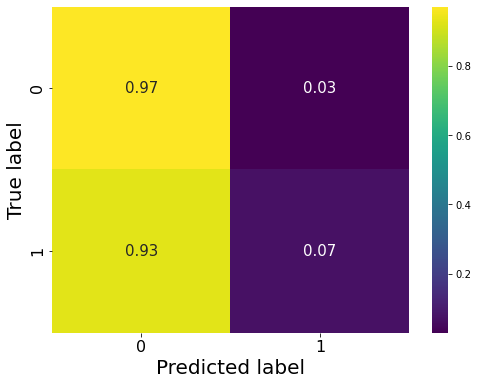

In [30]:
cm_test = confusion_matrix(y_test, best_estimator.predict(X_test), normalize='true')
mmh.plot_confusion_matrix(cm_test, [0, 1])

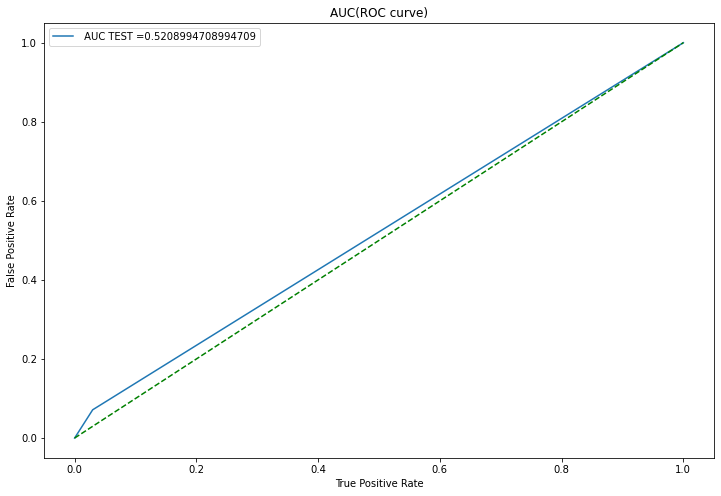

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, best_estimator.predict(X_test))
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)